In [2]:
import math 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import quaternion as Quaternion
from matplotlib.ticker import ScalarFormatter

import pca

from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import decimate, resample_poly, resample
from scipy.interpolate import PchipInterpolator

from ahrs.filters.madgwick import Madgwick #ahrs library requires git clone, do not pip install


In [3]:

xl1 = pd.read_csv("imu_raw/xl1.csv")
xl2 = pd.read_csv("imu_raw/xl2.csv")
xl3 = pd.read_csv("imu_raw/xl3.csv")

mg1 = pd.read_csv("imu_raw/mg1.csv")
mg2 = pd.read_csv("imu_raw/mg2.csv")
gy = pd.read_csv("imu_raw/gy.csv")

#collect first 1000 intervals
xl1_group = xl1.groupby('interval')
first_10_xl = [group[['interval','timestamp','xl1.x','xl1.y','xl1.z']] for i, (name,group) in enumerate(xl1_group) if i < 1000]
xl_dat = pd.concat(first_10_xl).values

mg1_group = mg1.groupby('interval')
first_10_mg = [group[['interval','timestamp','mg1.x','mg1.y','mg1.z']] for i, (name,group) in enumerate(mg1_group) if i < 1000]
mg_dat = pd.concat(first_10_mg).values

gy_group = gy.groupby('interval')
first_10_gy = [group[['interval','timestamp','gy.x','gy.y','gy.z']] for i, (name,group) in enumerate(gy_group) if i < 1000]
gy_dat = pd.concat(first_10_gy).values

print(gy_dat.shape, mg_dat.shape, xl_dat.shape)

(933740, 5) (18427, 5) (930064, 5)


In [4]:
def gyr_offset_radians(gyr_dat, offset):
    """Put gy data in radians, remove measured error """
    gyr_off = gyr_dat - offset
    gyro_rad = gyr_off * ( np.pi / 180)
    
    return gyro_rad

def microtesla_to_nanotesla(value_µT):
    return value_µT * 1000

def clip_xl(xl_dat, clip):
    """
    XL sensors above certain thresholds are defective
    """
    xl_clipped = np.where(xl_dat > clip, clip, xl_dat)
    xl_clipped = np.where(xl_clipped < -1*clip, -1*clip, xl_clipped)
    return xl_clipped

def correct_data(dat):
    """ 
    Sorts sensor data by timestamp and removes duplicates
    Params: 
        dat: sensor data 
    """
    dat = np.array(dat).astype(float)
    sorted_dat = dat[dat[:,0].argsort()]

    _, unique_indices = np.unique(sorted_dat[:,0], return_index = True)
    processed_data = sorted_dat[unique_indices]
    return processed_data

def preprocess_imu(xl_raw, mag_raw, gyr_raw, gyr_offset = np.array([.58, .42, -.3])):
    """
    correct units, remove gyr offset
    Returns:
        data_matrix: (xl, mag, gyr)
    """
    xl_raw = clip_xl(xl_raw, 2)
    xl = xl_raw * 9.810665
    gyr_offset = gyr_offset # Ahmed: how were these offset values chosen?
    gyr = gyr_offset_radians(gyr_raw, gyr_offset)
    mag = microtesla_to_nanotesla(mag_raw)
    return xl, mag, gyr

In [5]:

def quatConjucate(q):
        w,x,y,z = q
        q_star = np.array([w,-x,-y,-z])
        return q_star
        
def quatProduct(q, p):
        q = np.array(q)
        p = np.array(p)
        w, x, y, z = list(q)

        q_matrix = np.array([
            [w, -x, -y, -z],
            [x, w, -z, y],
            [y, z, w, -x],
            [z, -y, x, w]
        ])
        return q_matrix @ p

def inverse(q):
    q_star = quatConjucate(q)
    mag =  np.sqrt(np.sum(np.square(q)))
    if  0.998 < mag < 1.001:
        return q_star
    else:
        q_inverse = q_star / mag**2
        return q_inverse
      
def rotate_vector(q, v, active=True):
        v = np.insert(np.array(v), 0, 0)  # convert to pure quaternion
        q_inv = inverse(q)
        if active: # object rotation
            q_product = quatProduct(q, v)
            q_rot = quatProduct(q_product, q_inv)
        else: # coordinate rotation
            q_product = quatProduct(q_inv, v)
            q_rot = quatProduct(q_product, q)

        return q_rot[1:]

def R(q_w, q_x, q_y, q_z):
    """
    Direction Cosine Matrix to rotate between two frames
    """
    # rotation_matrix = np.array([
    #     [q_w**2+q_x**2-q_y**2-q_z**2, 2*(q_x*q_y-q_w*q_z), 2*(q_x*q_z+q_w*q_y)],
    #     [2*(q_x*q_y+q_w*q_z), q_w**2-q_x**2+q_y**2-q_z**2, 2*(q_y*q_z-q_w*q_x)],
    #     [2*(q_x*q_z-q_w*q_y), 2*(q_w*q_x+q_y*q_z), q_w**2-q_x**2-q_y**2+q_z**2]
    # ])
            
    rotation_matrix = np.array([
        [1.0-2.0*(q_y**2+q_z**2), 2.0*(q_x*q_y-q_w*q_z), 2.0*(q_x*q_z+q_w*q_y)],
        [2.0*(q_x*q_y+q_w*q_z), 1.0-2.0*(q_x**2+q_z**2), 2.0*(q_y*q_z-q_w*q_x)],
        [2.0*(q_x*q_z-q_w*q_y), 2.0*(q_w*q_x+q_y*q_z), 1.0-2.0*(q_x**2+q_y**2)]
        ])
    return rotation_matrix

def rotate_to_ned(q, vec, madg):
    """
    rotates raw data by quaternion into global frame
    # """
    if (madg == True):
        rotation_matrix = R(*q) 
        global_estimate = rotation_matrix.T @ vec 
    else:
        global_estimate = rotate_vector(q, vec, active=False)

    return global_estimate


In [6]:
def interpolate_points(dat_ned, timestamps, odr):
    
    X_interpolate = np.arange(odr)
    interpolated_data = []

    for ax in range(3):
        spline = PchipInterpolator(timestamps, dat_ned[:,ax])
        interolated_points = spline(X_interpolate)

        interpolated_data.append(interolated_points)
    return np.array(interpolated_data).T

def time_align(xyz, sensor_odr, interval_odr, name):
    """ 
    Upsample data 2x interval odr(fourier signal), decimate data back down(lowpass filter), interpolate to desired interval odr, select current interval points
    """
    xyz_w = []
    len_w = []
    for i, itvl in enumerate(xyz):
        xyz_w.append(itvl)
        len_w.append(len(itvl))

    xyz_w = np.vstack(xyz_w)

    #resample/decimate/interpolate for entire window 
    xyz_r = resample(xyz_w, num=(sensor_odr*len(len_w))*2, axis=0) # set upsample 2x odr
    # print('xyz_r', xyz_r.shape)

    factor = xyz_r.shape[0]//((sensor_odr*len(len_w))) #set to downsample back to sensor odr
    xyz_d = decimate(xyz_r, q=factor, axis=0)
    # print('xyz_d', xyz_d.shape)
    
    new_points = interpolate_points(xyz_d, np.arange(xyz_d.shape[0]), interval_odr*3)
    current_points = new_points[interval_odr:interval_odr*2] #assumes window size 3 here 
    
    return np.array(current_points)

In [7]:
def imu_processing(xl, mg, gy, interval_odr, madg = True):
    """
    Main function, group data by intervals, build window of adjacent intervals for time alignment, this fixes errors on ends from resampling and decimating
    """

    sensor_odr = {"xl":1000, 'gy':1000, 'mg':20}
    sensor_dt = {'xl':.001, 'gy':.001, 'mg':.05}

    cols =['interval','timestamp','x', 'y', 'z']
    xl_df = pd.DataFrame(xl, columns=cols)
    mg_df = pd.DataFrame(mg, columns=cols)
    gy_df = pd.DataFrame(gy, columns=cols)

    xl_group = xl_df.groupby('interval')
    mg_group = mg_df.groupby('interval')
    gy_group = gy_df.groupby('interval')

    # print(list(xl_group))

    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) => window size 3, n points, xyz axis
    gy_w = []
    mg_w = []

    for (name1, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):

        xl_ = correct_data(xl_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values)
        xl_p, mg_p, gy_p = preprocess_imu(xl_[:,1:], mg_[:,1:], gy_[:,1:])

        xl_w.append(xl_p)
        mg_w.append(mg_p)
        gy_w.append(gy_p)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 

        xl_t = time_align(xl_w, 1000, interval_odr, 'xl')
        mg_t = time_align(mg_w, 20, interval_odr, 'mg')
        gy_t = time_align(gy_w, 1000, interval_odr, 'gy')

        #Madgwick model gives quaternion vectors that rotate xl vector from sensor to ned frame
        model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency=interval_odr, q0 = prev_q)
        prev_q = model.Q[-1]

        for q,x in zip(model.Q, xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec = rotate_to_ned(q, norm_vec, madg)
            ned_vec *= mag
            ned_vec[2] -= 9.810665 #in ned frame, assume z axis aligns with gravity, subtract it off
            xl_global.append(ned_vec)
        
    return xl_global

In [8]:
xl_ned = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100))
print(np.array(xl_ned).shape)

(99800, 3)


In [9]:
def combine_xl(xl1, xl2, xl3): 

    xl1_xl3 = np.where(xl3 > 2, xl3, xl1)
    xl1_xl3 = np.where(xl3 < -2, xl3, xl1_xl3)

    final_xl = np.where(xl2 > 4, xl2, xl1_xl3)
    final_xl = np.where(xl2 < -4, xl2, final_xl)

    return final_xl

def time_align_combined(xyz, sensor_odr, interval_odr, name, interpolate=False):
    """ 
    Upsample data 2x interval odr(fourier signal), decimate data back down(lowpass filter), interpolate to desired odr, select current interval points
    """
    xyz_w = []
    len_w = []
    for i, ts in enumerate(xyz):
        xyz_w.append(ts)
        len_w.append(len(ts))

    xyz_w = np.vstack(xyz_w)

    xyz_r = resample(xyz_w, num=(sensor_odr*3)*2, axis=0)
    factor = xyz_r.shape[0]//((sensor_odr*3))
    xyz_d = decimate(xyz_r, q=factor, axis=0)
    # print('decimate', xyz_d.shape[0])

    if interpolate:
        new_points = interpolate_points(xyz_d, np.arange(xyz_d.shape[0]), interval_odr*3)
    else:
        new_points = xyz_d

    current_points = new_points[interval_odr:interval_odr*2]
    
    # print('final', np.array(current_points).shape)
    return np.array(current_points)

def recompute_t(xl):
    new_ts_col = []
    curr_ts = 0
    dt = 1/1000
    for _, row in xl.iterrows():
        if curr_ts == 0:
            curr_ts = float(int(row['timestamp']))
            new_ts_col.append(curr_ts)
        else:
            new_ts = round(new_ts_col[-1] + dt, 3)
            new_ts_col.append(new_ts)
    
    return new_ts_col

def new_preprocess_imu(xl_raw, mag_raw, gyr_raw, gyr_offset, clip_val, clip = False):
    """
    correct units, remove gyr offset
    Returns:
        data_matrix: (xl, mag, gyr)
    """
    if clip == True:
        xl_raw = clip_xl(xl_raw, clip_val)
 
    xl = xl_raw * 9.810665
    gyr = gyr_offset_radians(gyr_raw, gyr_offset)
    mag = microtesla_to_nanotesla(mag_raw)
    
    return xl, mag, gyr
 

# def align_xl(xl1, xl2, xl3):
#     cols =['interval','timestamp','x', 'y', 'z']
#     xl1_df = pd.DataFrame(xl1, columns=cols)
#     xl2_df = pd.DataFrame(xl2, columns=cols)
#     xl3_df = pd.DataFrame(xl3, columns=cols)

#     xl1_group = xl1_df.groupby('interval')
#     xl2_group = xl2_df.groupby('interval')
#     xl3_group = xl3_df.groupby('interval')

#     xl1_w = []
#     xl2_w = []
#     xl3_w = []

#     xl1_aligned = []
#     xl2_aligned = []
#     xl3_aligned = []

#     xl_combined = []

#     for (name1, xl1_grp), (name2, xl2_grp), (name3, xl3_grp) in zip(xl1_group, xl2_group, xl3_group):

#         xl_1 = correct_data(xl1_grp.drop(columns=['interval']).values)
#         xl_2 = correct_data(xl2_grp.drop(columns=['interval']).values)
#         xl_3 = correct_data(xl3_grp.drop(columns=['interval']).values)

#         xl_1 = xl_1[:, 1:]
#         xl_2 = xl_2[:, 1:]
#         xl_3 = xl_3[:, 1:]

#         xl1_clipped = clip_xl(xl_1, 2)
#         xl2_clipped = clip_xl(xl_2, 8)
#         xl3_clipped = clip_xl(xl_3, 4)

#         xl1_w.append(xl1_clipped)
#         xl2_w.append(xl2_clipped)
#         xl3_w.append(xl3_clipped)

#         if len(xl1_w) > 3: 
#             xl1_w.pop(0)
#             xl2_w.pop(0)
#             xl3_w.pop(0)
        
#         if len(xl1_w) != 3:
#             continue

#         xl1_ta = time_align_combined(xl1_w, 1000, 1000, 'xl', False)
#         xl2_ta = time_align_combined(xl2_w, 1000, 1000, 'xl', False)
#         xl3_ta = time_align_combined(xl3_w, 1000, 1000, 'xl', False)

#         xl1_aligned.append(xl1_ta)
#         xl2_aligned.append(xl2_ta)
#         xl3_aligned.append(xl3_ta)

#         final_xl = combine_xl(xl1_ta, xl2_ta, xl3_ta)
#         xl_combined.append(final_xl)

#     xl1_aligned = np.array(xl1_aligned).reshape(-1, 3)
#     xl2_aligned = np.array(xl2_aligned).reshape(-1, 3)
#     xl3_aligned = np.array(xl3_aligned).reshape(-1, 3)
#     xl_combined = np.array(xl_combined).reshape(-1, 3)

#     return xl1_aligned, xl2_aligned, xl3_aligned, xl_combined

def align_xl(xl1, xl2, xl3):
    cols =['interval','timestamp','x', 'y', 'z']
    xl1_df = pd.DataFrame(xl1, columns=cols)
    xl2_df = pd.DataFrame(xl2, columns=cols)
    xl3_df = pd.DataFrame(xl3, columns=cols)

    xl1_group = xl1_df.groupby('interval')
    xl2_group = xl2_df.groupby('interval')
    xl3_group = xl3_df.groupby('interval')

    xl1_w = []
    xl2_w = []
    xl3_w = []

    xl1_aligned = []
    xl2_aligned = []
    xl3_aligned = []

    xl_combined = []

    for (name1, xl1_grp), (name2, xl2_grp), (name3, xl3_grp) in zip(xl1_group, xl2_group, xl3_group):
        if name1 != name2 or name2 != name3:
            continue

        xl_1 = correct_data(xl1_grp.drop(columns=['interval']).values)
        xl_2 = correct_data(xl2_grp.drop(columns=['interval']).values)
        xl_3 = correct_data(xl3_grp.drop(columns=['interval']).values)

        xl_1 = xl_1[:, 1:]
        xl_2 = xl_2[:, 1:]
        xl_3 = xl_3[:, 1:]

        xl1_clipped = clip_xl(xl_1, 2)
        xl2_clipped = clip_xl(xl_2, 8)
        xl3_clipped = clip_xl(xl_3, 4)

        xl1_w.append(xl1_clipped)
        xl2_w.append(xl2_clipped)
        xl3_w.append(xl3_clipped)


        if len(xl1_w) > 3: 
            xl1_w.pop(0)
            xl2_w.pop(0)
            xl3_w.pop(0)
        
        if len(xl1_w) != 3:
            continue

        xl1_ta = time_align_combined(xl1_w, 1000, 1000, 'xl', False)
        xl2_ta = time_align_combined(xl2_w, 1000, 1000, 'xl', False)
        xl3_ta = time_align_combined(xl3_w, 1000, 1000, 'xl', False)

        xl1_aligned.append(xl1_ta)
        xl2_aligned.append(xl2_ta)
        xl3_aligned.append(xl3_ta)

        ts1 = xl1_grp.iloc[xl1_grp.shape[0]//2]['timestamp']
        ts2 = xl2_grp.iloc[xl2_grp.shape[0]//2]['timestamp']
        ts3 = xl3_grp.iloc[xl3_grp.shape[0]//2]['timestamp']
        
        assert int(ts1) == int(ts2) == int(ts3), print('Ts out of order')
        ts_column = [ts1 for _ in range(xl1_ta.shape[0])]

        final_xl = combine_xl(xl1_ta, xl2_ta, xl3_ta)
        final_xl = np.column_stack([final_xl, ts_column])
        xl_combined.append(final_xl)

    xl1_aligned = np.array(xl1_aligned).reshape(-1, 3)
    xl2_aligned = np.array(xl2_aligned).reshape(-1, 3)
    xl3_aligned = np.array(xl3_aligned).reshape(-1, 3)
    xl_combined = np.array(xl_combined).reshape(-1, 4)

    return xl1_aligned, xl2_aligned, xl3_aligned, xl_combined


In [10]:
def imu_processing_combined(xl1, xl1_interval_ids, mg, gy, interval_odr, gyr_offset, og_odr, sub_mg):
    """
    Main function, group data by intervals, build window of adjacent intervals for time alignment, this fixes large values on ends
    """

    sensor_odr = {"xl":1000, 'gy':1000, 'mg':20}
    sensor_dt = {'xl':.001, 'gy':.001, 'mg':.05}

    cols =['interval','timestamp','x', 'y', 'z']

    # xl1_df = pd.DataFrame(xl1, columns=cols)
    # xl1_group = xl1_df.groupby('interval')
    
    mg_df = pd.DataFrame(mg, columns=cols)
    gy_df = pd.DataFrame(gy, columns=cols)

    xl_dat_df = pd.DataFrame(xl_dat, columns = cols)
    timestamps_column = recompute_t(xl_dat_df)

    n_intervals = len(np.unique(xl1_interval_ids))
    interval_ids = np.repeat(np.arange(998), 1000)

    xl1_mod = np.column_stack([xl1, interval_ids])
    xl1_df = pd.DataFrame(xl1_mod, columns=['x','y','z','timestamp', 'interval'])
    
    xl1_group = xl1_df.groupby('interval')
    mg_group = mg_df.groupby('interval')
    gy_group = gy_df.groupby('interval')

    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) history of 3, n data , xyz 
    gy_w = []
    mg_w = []

    for (name1, xl1_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl1_group, mg_group, gy_group):
        assert name1 == name2 == name3, f"Group names don't match: {name1}, {name2}, {name3}" #groups all must belong to the same interval 

        # gyr_offset = np.array([.58, .42, -.3])
        # xl_ = correct_data(xl1_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values) #remove unique values 
        # xl_p, mg_p, gy_p = preprocess_imu(xl_1[:,1:], mg_[:,1:], gy_[:,1:], gyr_offset, 2, clip=False)
        xl_w.append(xl1_grp.drop(columns=['interval', 'timestamp']).values)
        mg_w.append(mg_[:,1:])
        gy_w.append(gy_[:,1:])

        if len(xl_w) > 3: 
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 
            
        interval_q = []

        if og_odr == True: 
            interpolate = False

            # xl_t = time_align(xl_w, 1000, 1000, 'xl', interpolate)
            xl_t = np.array(xl_w).reshape(-1,3)[interval_odr:2*interval_odr]
            mg_t = time_align_combined(mg_w, 20, 20, 'mg', interpolate)
            gy_t = time_align_combined(gy_w, 1000, 1000, 'gy', interpolate)

            xl_p, mg_p, gy_p = new_preprocess_imu(xl_t, mg_t, gy_t, gyr_offset, clip_val = 2, clip = False)
            mg_idx = 0  

            model = Madgwick(acc=xl_p, gyr=gy_p, dt=1/interval_odr, q0 = prev_q)
            prev_q = model.Q[-1]

            # print(prev_q)
            interval_q.append(prev_q)
        
        else:
            interpolate = True

            xl_t = time_align(xl_w, 1000, interval_odr, 'xl', interpolate)
            mg_t = time_align(mg_w, 20, interval_odr, 'mg', interpolate)
            gy_t = time_align(gy_w, 1000, interval_odr, 'gy', interpolate)

            model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency = interval_odr, q0 = prev_q)
            prev_q = model.Q[-1]
            interval_q = model.Q

        # print(interval_q)
        # print("----------------------")
        # print(xl_t.shape)
        # print(len(interval_q))

        group_xl_ned = []
        for q,x in zip(np.array(interval_q), xl_t):
            x*=9.8
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec_1 = rotate_to_ned(q, norm_vec, madg = True)
            vec1 = np.round(ned_vec_1,4)
            print(q)

            mag =  np.sqrt(np.sum(np.square(q)))
            q = q / mag
            ned_vec_2 = rotate_vector(q, norm_vec, active=False)
            vec2 = np.round(ned_vec_2,4)

            # print(ned_vec_1)
            # print(ned_vec_2)

            assert np.allclose(vec1, vec2) , f"Not equal vec1: {vec1}, vec2: {vec2}"

            ned_vec_1 *= mag
            ned_vec_1[2] -= 9.810665
            # xl_global.append(ned_vec_1)
            group_xl_ned.append(ned_vec_1)
        
        group_ts = [xl1_grp.iloc[xl1_grp.shape[0]//2]['timestamp'] for _ in range(np.array(group_xl_ned).shape[0])]
        group_interval = [xl1_grp.iloc[xl1_grp.shape[0]//2]['interval'] for _ in range(np.array(group_xl_ned).shape[0])]

        group_xl_ned = np.column_stack([group_xl_ned, group_ts, group_interval])
        xl_global.append(group_xl_ned)

        # print(np.array(xl_grp).shape)
        # plt.plot(np.arange(gy_t.shape[0]), gy_t[:,2]-9.8)
        # plt.show()
        # plt.plot(np.array(gy_t)[:,2])
        # plt.show()
        # print(np.array(gy_t).shape[0])
        # print('dfdf')
        # break

    return np.vstack(xl_global)

In [11]:
print(xl1.columns)
print(xl2.columns)
print(xl3.columns)

Index(['interval', 'timestamp', 'xl1.x', 'xl1.y', 'xl1.z'], dtype='object')
Index(['interval', 'timestamp', 'xl2.x', 'xl2.y', 'xl2.z'], dtype='object')
Index(['interval', 'timestamp', 'xl3.x', 'xl3.y', 'xl3.z'], dtype='object')


In [12]:

xl1_a, xl2_a, xl3_a, xl_comb = align_xl(xl1.values, xl2.values, xl3.values)
xl1_interval_ids = np.arange(0, 1000, 1)

xl_ned_global = imu_processing_combined(xl_comb, xl1_interval_ids, mg_dat, gy_dat, interval_odr = 1000, 
                                        gyr_offset = np.array([.58, .42, -.3]), og_odr = True, sub_mg = False)

print(xl_ned_global.shape)


[ 0.99697678 -0.03216708 -0.06169954  0.0345796 ]
[ 0.987238    0.00860206 -0.14648552  0.06187994]
[ 0.99258714 -0.02303587 -0.03622613  0.1137004 ]
[ 0.99234846 -0.01938245 -0.02554167  0.11923287]
[ 0.9899162  -0.01816797 -0.05193866  0.13053052]
[0.99089159 0.0019299  0.01130198 0.13417301]
[ 0.98339186  0.0352557  -0.07781701  0.16013122]
[ 0.98555246  0.04224916 -0.04123112  0.15874936]
[ 0.98158124  0.0119895  -0.03150485  0.18804778]
[ 0.97686429  0.01754038 -0.0344679   0.21033416]
[ 0.97113204  0.01404503 -0.0205445   0.23724087]
[ 0.96867947  0.02465126 -0.04947106  0.24208471]
[ 0.9540511  -0.00677506 -0.05049725  0.29528057]
[ 0.94691368  0.04469923 -0.05963702  0.31272973]
[ 0.94127814  0.02400996 -0.08555127  0.32572991]
[ 0.94759836 -0.01025803 -0.0128873   0.31903924]
[ 0.93967787  0.01257064 -0.06745693  0.33510751]
[ 0.92738319 -0.00863281 -0.04286955  0.37154824]
[ 0.92142247  0.03558642 -0.03447696  0.38539018]
[ 0.91798618  0.04825967 -0.0605553   0.38897998]
[ 0.

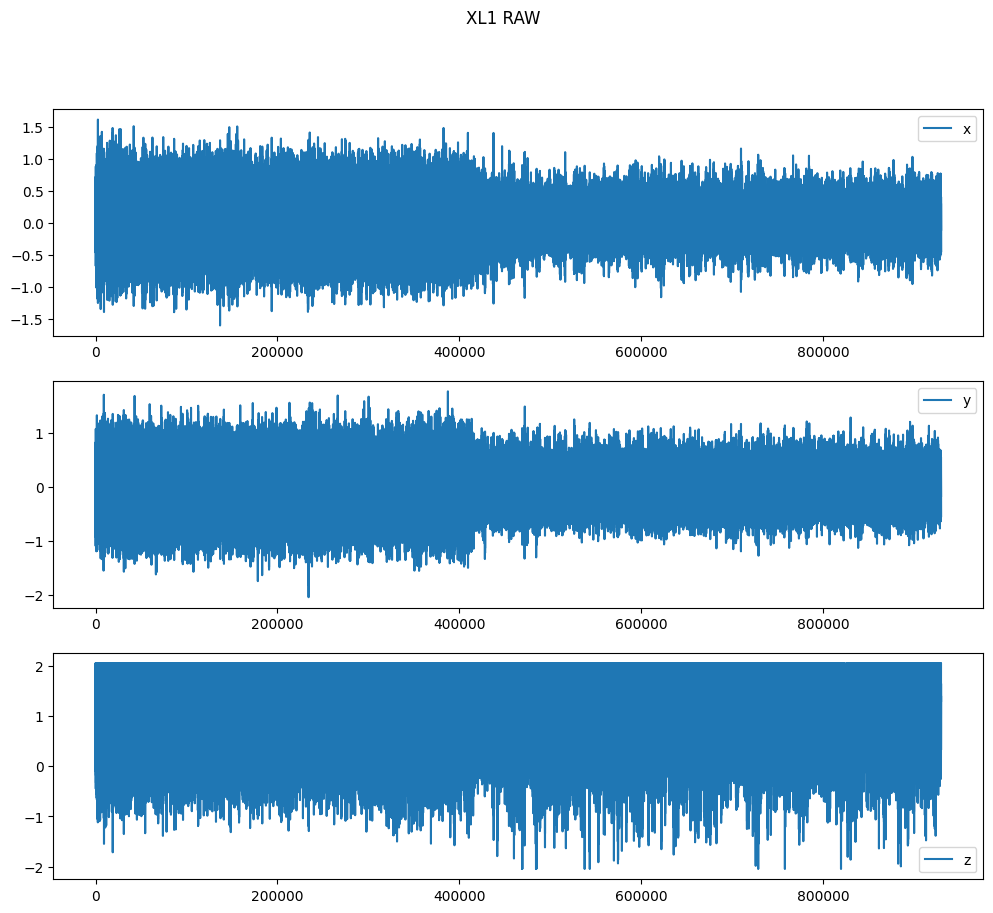

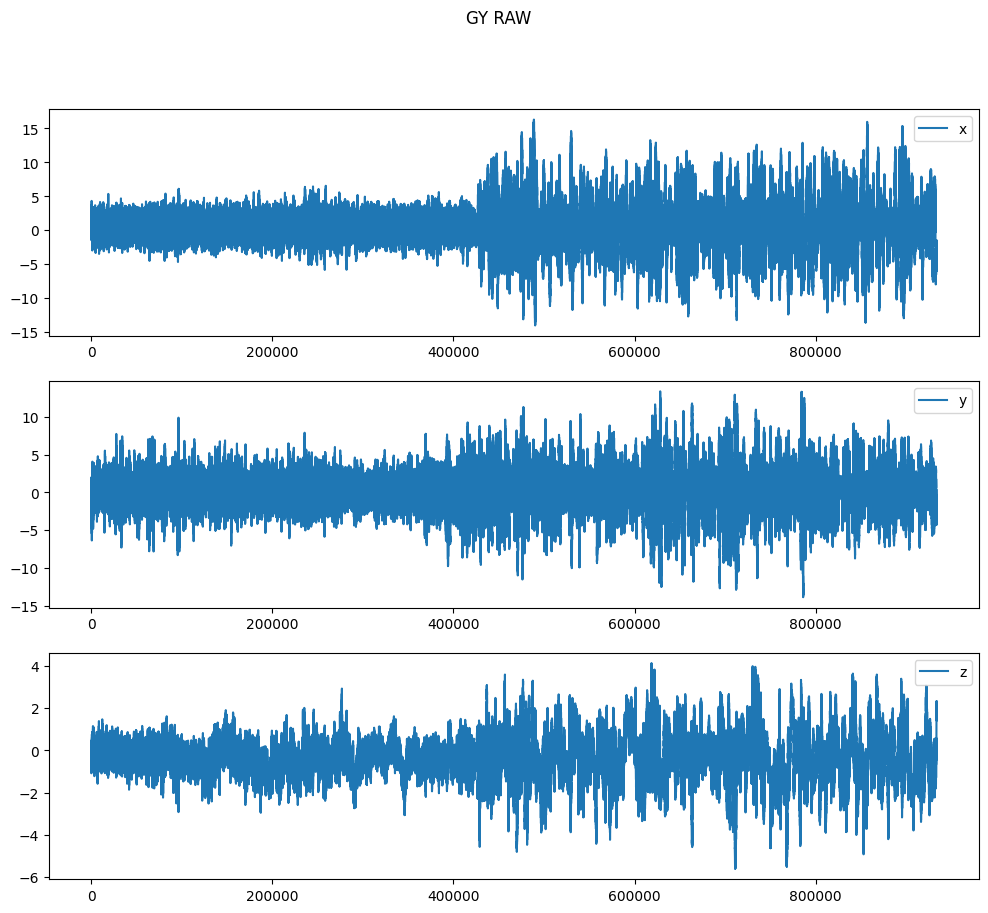

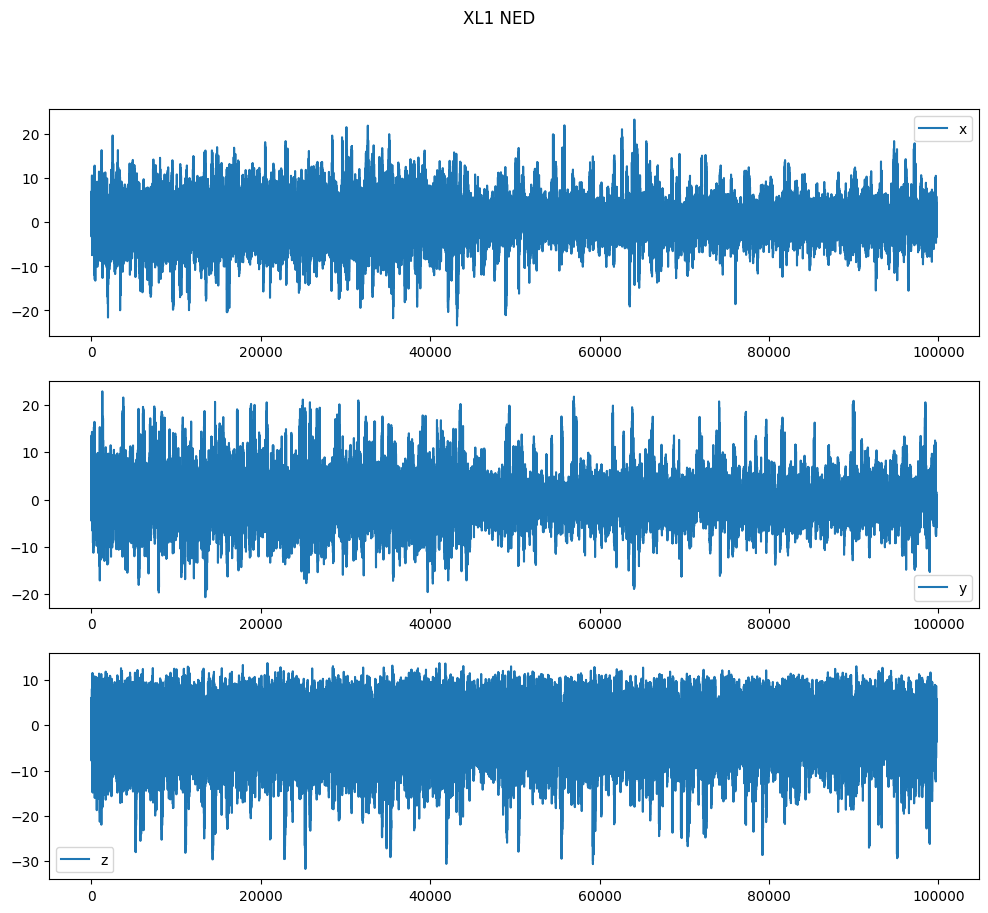

In [13]:
fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_dat[:,2], label='x') #(interval, timestamp, x,y,z)
axes[1].plot(xl_dat[:,3], label='y')
axes[2].plot(xl_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(gy_dat[:,2], label='x')#(interval, timestamp, x,y,z)
axes[1].plot(gy_dat[:,3], label='y')
axes[2].plot(gy_dat[:,4], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('GY RAW')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned[:,0], label='x')
axes[1].plot(xl_ned[:,1], label='y')
axes[2].plot(xl_ned[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED')
plt.show()

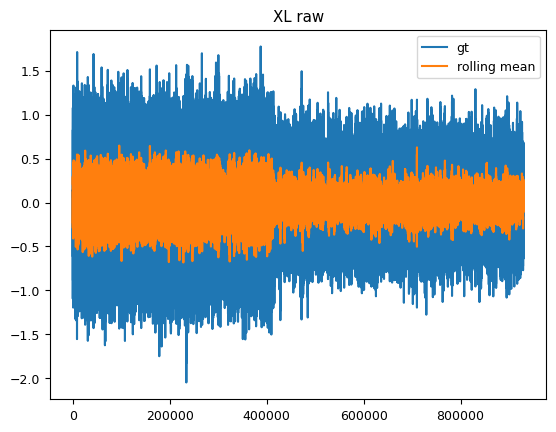

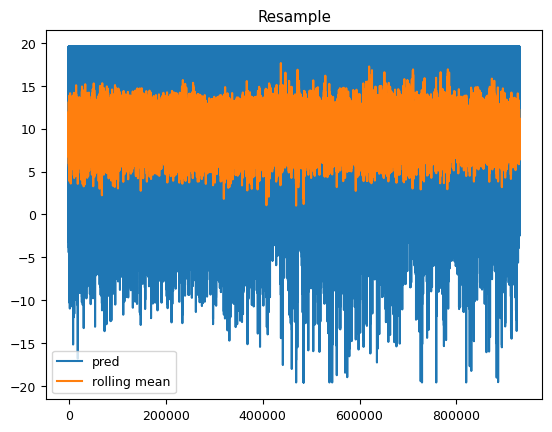

C:\Users\ChoudhryAhmed\AppData\Local\Temp\ipykernel_29792\3606981718.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


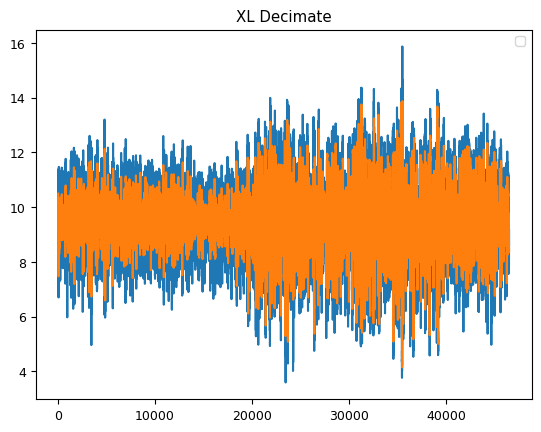

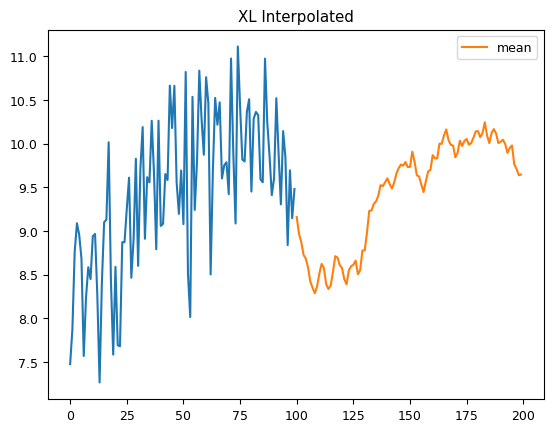

[3.4255787382188974, 3.442200551475739, 3.44965605778517, 3.4527380006194517, 3.4542654815083806, 3.4551254809076535, 3.4556546565777913, 3.4560028534471043, 3.456243537771085, 3.4564167088061764]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[3.9401952314011375, 4.727060783754079, 4.386568981492892, 4.21551606020661, 4.388205628053257, 4.343535204643161, 4.351167635677766, 4.4722981783317275, 4.619971109707533, 4.290150948930207, 3.9913611154954887, 4.085113978931611, 3.969608361853871, 4.277358651716196, 3.965275555014029, 4.167862619910155, 3.6950597104499647, 4.646669402200438, 4.514124872408555, 4.277019849688096, 4.304291702420849, 3.9089755367592267, 4.0737480065716465, 4.083632871469059, 3.823965107256125, 4.0676027564096495, 4.092953727009607, 3.76364858012084, 4.014223415438168, 4.233348059893756, 3.739881810254934, 4.287516623003412, 4.273018704639458, 4.060662987283319, 4.223828650433217, 4.125741068306293, 3.927978986005923, 4.187640555173215, 4.063056822954873, 4.1

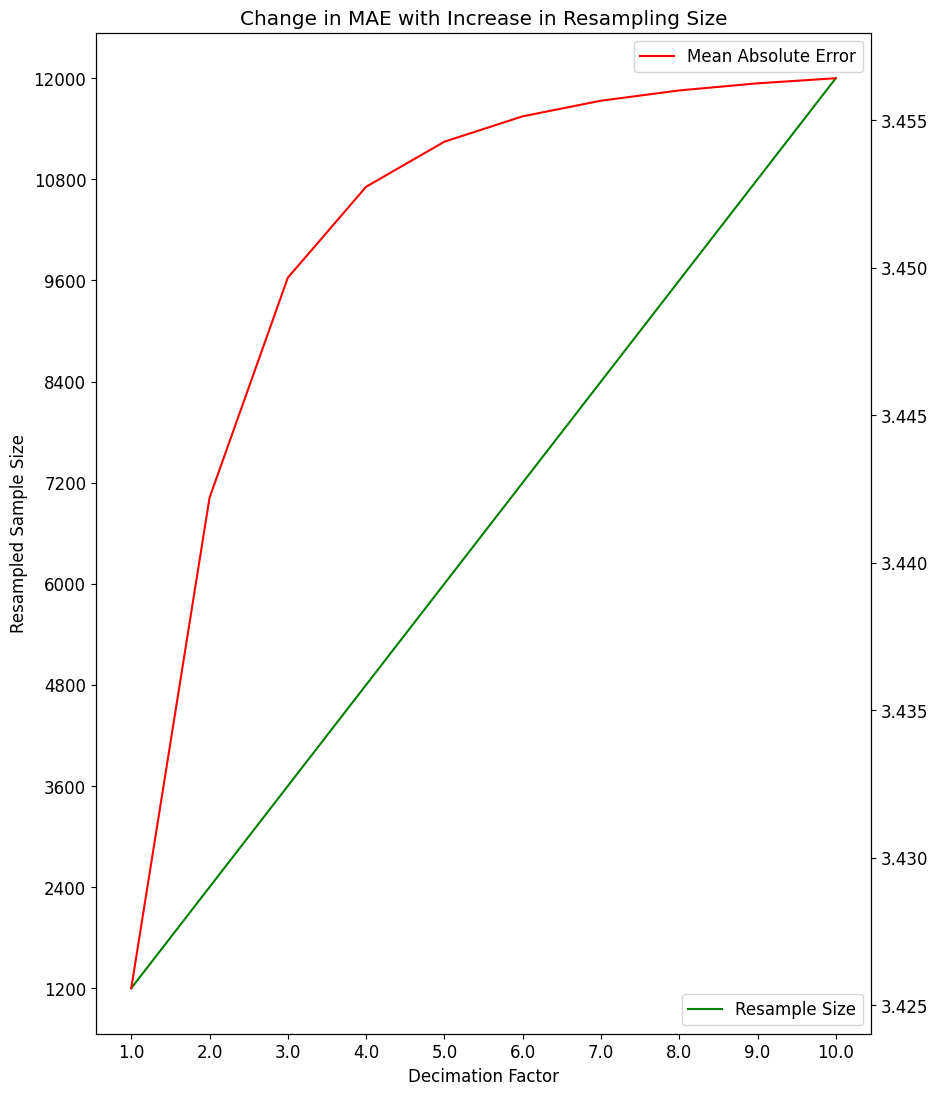

In [14]:
plt.rcParams.update({'font.size': 9})

def keep_every_k_of_n(arr, k, n,):
    """
    Keeps `k` elements for every `n` elements from the array, simulate missing data 
    """
    kept = []
    i = 0
    while i < len(arr):
        kept.extend(arr[i:i+k])
        i += n
    return kept

# xl_missing = np.array(keep_every_k_of_n(xl_dat[:1000,:], 400, 500))
# print(np.array(xl_missing).shape)

#helper functions for experimenting with different parameters, plot rolling means  
xl_ = correct_data(xl_dat[:,1:])
xl_ = clip_xl(xl_, 2)
xl_ *= 9.8
xl_resample = resample(xl_[:,3], num=930064)
xl_decimate = decimate(xl_resample, q=20)

#raw data
rolling_mean = pd.Series(xl_dat[:,3]).rolling(window=10).mean()
plt.plot(xl_dat[:,3], label='gt')
plt.plot(rolling_mean, label='rolling mean')
plt.legend()
plt.title('XL raw')
plt.show()

#xl resample
rolling_mean = pd.Series(xl_resample).rolling(window=10).mean()
plt.plot(xl_resample, label='pred')
plt.plot(rolling_mean, label='rolling mean')
plt.title('Resample')
plt.legend()
plt.show()

#xl decimate
rolling_mean = pd.Series(xl_decimate).rolling(window=10).mean()
plt.plot(xl_decimate)
plt.plot(rolling_mean)
plt.title('XL Decimate')
plt.legend()
plt.show()

spline = PchipInterpolator(np.arange(xl_decimate.shape[0]), xl_decimate)
interpolated_points = spline(np.arange(0, 930064, 1))

rolling_mean = pd.Series(interpolated_points[:300]).rolling(window=10).mean()
plt.plot(interpolated_points[100:200])
plt.plot(rolling_mean[100:200], label='mean')
plt.title("XL Interpolated")
plt.legend()
plt.show()

# Resampling and Decimating

cols =['interval','timestamp','x', 'y', 'z']
xl_df = pd.DataFrame(xl_dat, columns=cols)
mg_df = pd.DataFrame(mg_dat, columns=cols)
gy_df = pd.DataFrame(gy_dat, columns=cols)

xl_group = xl_df.groupby('interval')
mg_group = mg_df.groupby('interval')
gy_group = gy_df.groupby('interval')

resample_sizes = []
mean_squared_list = []
decimate_sizes = []

total_interval_vals =[] # a list of lists of all MSE values per decimation factor

for i in range(1, 11, 1):
    xl_global = []
    xl_w = []
    counter = 0
    total_mse = 0
    check = False
    interval_vals = [] # a list of all MSE values per decimation factor
    for (name, xl_grp), (name, mg_grp), (name, gy_grp) in zip(xl_group, mg_group, gy_group):
        xl_required = correct_data(xl_grp.drop(columns=['interval']).values)
        xl_required = clip_xl(xl_required[:,1:], 2)
        xl_test = xl_required * 9.810665  # ground truth data 

        xl_w.append(xl_test)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
    
        if len(xl_w) != 3:
            continue

        new_xl_w = [] # to unpack all 3 intervals for the window
        len_w = []
        for j, itvl in enumerate(xl_w):
            new_xl_w.append(itvl)
            len_w.append(len(itvl)) 
        
        new_xl_w = np.vstack(new_xl_w)

        if (new_xl_w.shape[0] == 3000):
            check = True
            xl_simulate = new_xl_w[1000:2000,:]

            xl_missing = keep_every_k_of_n(xl_simulate, 400, 500) # removes 200 data points for each 1000 point interval
            xl_to_use = np.vstack([new_xl_w[0:1000], xl_missing, new_xl_w[2000:3000]])

            xl_r = resample(xl_to_use, num = 1200*i, axis = 0)
            factor = xl_r.shape[0]/1200
            # factor = round(factor, 2)
            factor_rounded = int(xl_r.shape[0]/1200) # this ensures that data is always downsampled to 1200
            xl_d = decimate(xl_r, q = factor_rounded, axis = 0)  

            interval_mse = mean_absolute_error(np.array(xl_d[100:1100]), new_xl_w[1000:2000,:])
            counter += 1
            total_mse += interval_mse
            
            interval_vals.append(interval_mse)

    if len(xl_w) != 3:
        continue

    if (check == True):
        average_mse = total_mse / counter
        resample_sizes.append(1200*i)
        decimate_sizes.append(factor)

        mean_squared_list.append(average_mse)

        total_interval_vals.append(interval_vals)

print(mean_squared_list)
print(decimate_sizes)
print(total_interval_vals)
print(np.array(total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
ax_t = ax1.twinx()
ax1.plot(decimate_sizes, resample_sizes, label = "Resample Size", c= 'green')
ax_t.plot(decimate_sizes, mean_squared_list, label = "Mean Absolute Error", c="red")
ax1.set_xticks(decimate_sizes, labels=list(decimate_sizes))
ax1.set_yticks(resample_sizes, labels=list(resample_sizes))
ax1.set_xlabel("Decimation Factor")
ax1.set_ylabel("Resampled Sample Size")
ax1.set_title("Change in MAE with Increase in Resampling Size")
ax1.legend(loc = "lower right")
ax_t.legend()
plt.show()

590
590
590
590
590
590
590
590
590
590
[294.7926582200421, 294.9111743702205, 294.90571853426053, 294.9101152129471, 294.9135242230738, 294.91549079458787, 294.91709170132435, 294.91851129342234, 294.92369495779775, 294.92814333015576]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[238.17637440401117, 215.49346363511123, 265.82921895139253, 209.072830045622, 242.43265195668923, 225.2395465105177, 249.98980174040324, 233.46049519241774, 219.37853707097722, 240.5259184731996, 207.61580150602103, 247.72864082135334, 227.13204040766956, 245.86306695408635, 240.3382194570644, 260.0739828207458, 246.700639426434, 217.6127790961492, 279.7446888555316, 234.30775335411866, 285.17872400658774, 223.88580455679667, 250.79836705842993, 243.39769022986778, 222.49708790572365, 226.74300373828783, 237.53438194641373, 226.6377132867176, 247.67637991081358, 233.2784458075199, 226.03477766001765, 251.75023670278043, 231.55038793209485, 296.71700627340823, 222.3708501532018, 288.83556063859083, 28

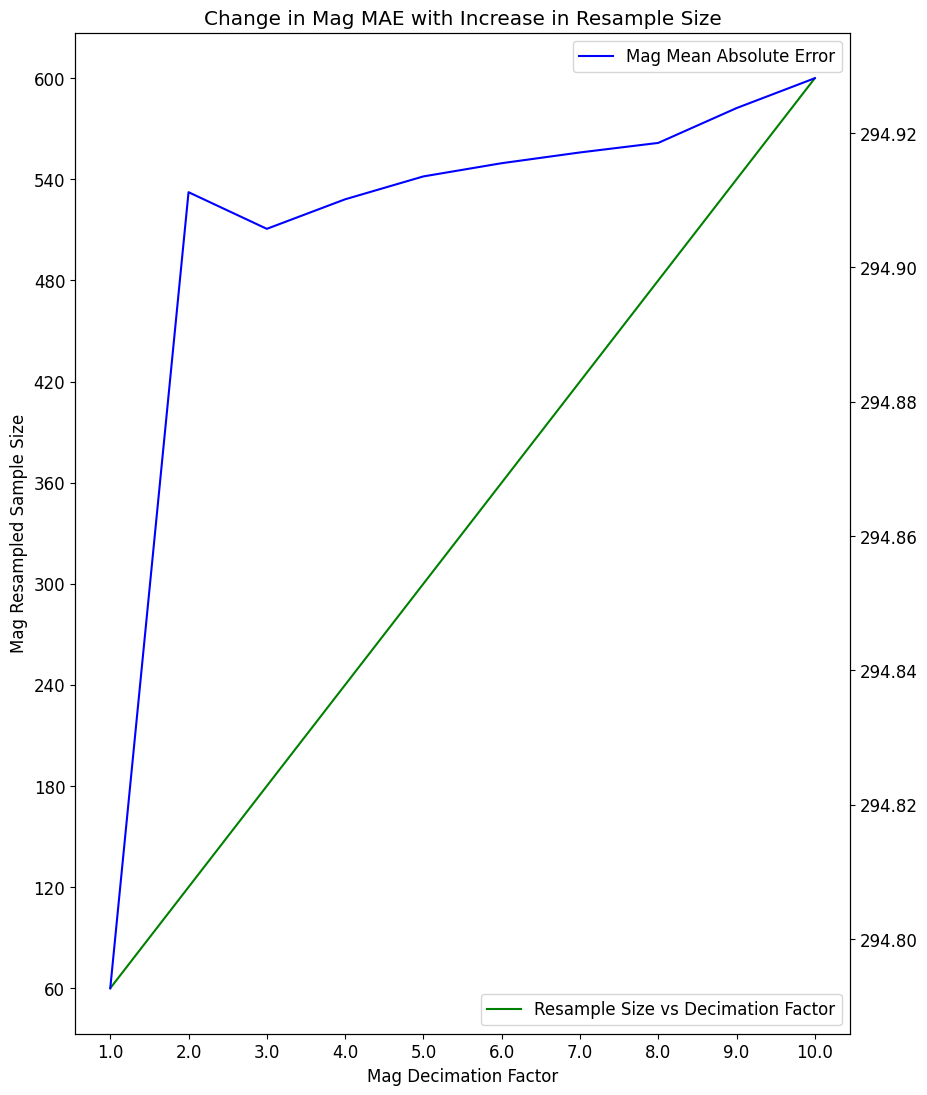

In [15]:
# Resampling and Decimating Magnetometer Data

plt.rcParams.update({'font.size': 12})
mag_resample_sizes = []
mag_mean_squared_list = []
mag_decimate_sizes = []

mag_total_interval_vals = [] # a list of lists of all MSE values per decimation factor
for i in range(1, 11, 1):
    mag_global = []
    mag_w = []
    mag_counter = 0
    mag_total_mse = 0
    mag_check = False
    mag_interval_vals = [] # a list of all MSE values for per decimation factor
    for (name, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):
        mag_required = correct_data(mg_grp.drop(columns=['interval']).values)
        mag_test = microtesla_to_nanotesla(mag_required[:,1:]) 

        mag_w.append(mag_test)

        if len(mag_w) > 3: #build window  
            mag_w.pop(0)
  
        if len(mag_w) != 3:
            continue

        new_mag_w = [] # to unpack all 3 intervals for the window
        mag_len_w = []
        for mag_j, mag_itvl in enumerate(mag_w):
            new_mag_w.append(mag_itvl)
            mag_len_w.append(len(mag_itvl)) 
        
        new_mag_w = np.vstack(new_mag_w)

        if (new_mag_w.shape[0] == 60):
            mag_check = True
            mag_simulate = new_mag_w[20:40]

            mag_missing = keep_every_k_of_n(mag_simulate, 15, 20) # removes 5 data points for each 20 point interval
            mag_to_use = np.vstack([new_mag_w[0:20], mag_missing, new_mag_w[40:60]])

            mag_r = resample(mag_to_use, num = 60*i, axis = 0)
            mag_factor = mag_r.shape[0]/60
            mag_factor = round(mag_factor, 2)
            mag_factor_rounded = int(mag_r.shape[0]/60) # this ensures that data is always downsampled to 60
            mag_d = decimate(mag_r, q = mag_factor_rounded, axis = 0)  

            mag_interval_mse = mean_absolute_error( new_mag_w[20:40,:], np.array(mag_d[20:40]))
            mag_counter += 1
            mag_total_mse += mag_interval_mse
            
            mag_interval_vals.append(mag_interval_mse)

    if len(mag_w) != 3:
        continue

    if (mag_check == True):
        print(mag_counter)
        mag_total_interval_vals.append(mag_interval_vals)
        # mag_average_mse = np.mean(mag_total_mse)
        mag_average_mse = mag_total_mse / mag_counter
        # mag_average_mse = round(mag_average_mse, 4)
        mag_resample_sizes.append(60*i)
        mag_decimate_sizes.append(mag_factor)

        mag_mean_squared_list.append(mag_average_mse)

print(mag_mean_squared_list)
print(mag_decimate_sizes)

print(mag_total_interval_vals)
print(np.array(mag_total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
ax_t = ax1.twinx()
ax1.plot(mag_decimate_sizes, mag_resample_sizes, label = "Resample Size vs Decimation Factor", c = "green")
ax_t.plot(mag_decimate_sizes, mag_mean_squared_list, label="Mag Mean Absolute Error", c="blue")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(mag_decimate_sizes, labels=list(mag_decimate_sizes))
ax1.set_yticks(mag_resample_sizes, labels=list(mag_resample_sizes))
ax1.set_xlabel("Mag Decimation Factor")
ax1.set_ylabel("Mag Resampled Sample Size")
ax1.legend(loc = "lower right")
ax1.set_title("Change in Mag MAE with Increase in Resample Size")
ax_t.legend()
plt.legend()
plt.show()

589
589
589
589
589
589
589
589
589
589
[0.011016878736096388, 0.011010963539238347, 0.011013109666946769, 0.011013717901759281, 0.011013957105832141, 0.011014074375651252, 0.011014140560685465, 0.011014181655944895, 0.01101420896671181, 0.01101422806982687]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[0.011491874831907785, 0.013949334732438297, 0.012008595165628064, 0.011875091487797695, 0.012096647407097786, 0.013032898240050309, 0.013248042771293085, 0.013542039318743503, 0.013589633295604824, 0.014067182419478325, 0.010830734017837067, 0.012065264017287044, 0.011685817202094545, 0.01274048865174676, 0.01144169301613396, 0.012633001388541072, 0.00983874963316613, 0.01323116559969994, 0.013266794694343343, 0.01276574518006012, 0.013248077903252562, 0.0101143292338406, 0.011287831114435926, 0.0110036829479003, 0.011579636169531247, 0.011270590923818472, 0.013485596224421225, 0.011087477544584633, 0.01157021892041811, 0.012372179782249887, 0.010209871924757785, 0.0122086792395

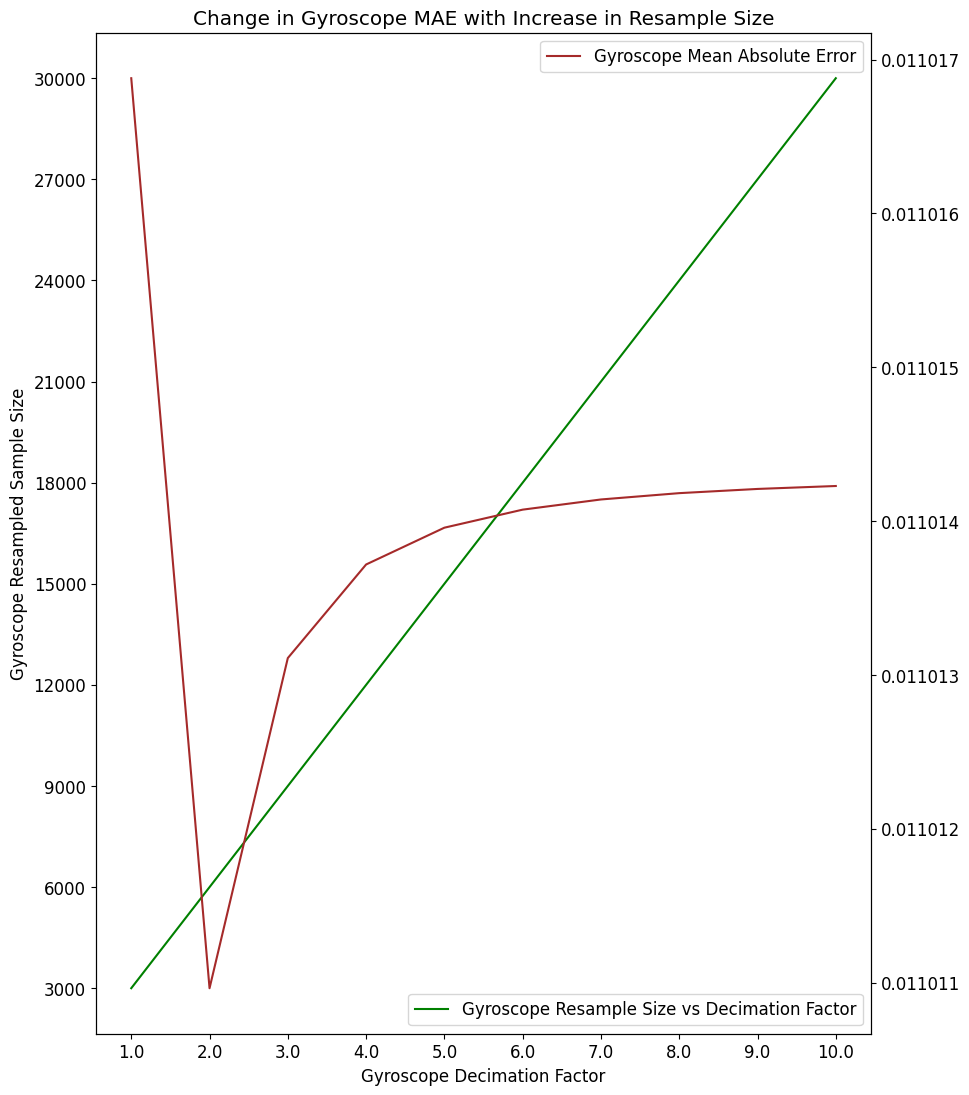

In [16]:
# Resampling and Decimating Gyroscope Data

plt.rcParams.update({'font.size': 12})
gy_resample_sizes = []
gy_mean_squared_list = []
gy_decimate_sizes = []

gy_total_interval_vals = [] # a list of lists of all MSE values per decimation factor
for i in range(1, 11, 1):
    gy_global = []
    gy_w = []
    gy_counter = 0
    gy_total_mse = 0
    gy_check = False
    gy_interval_vals = [] # a list of all MSE values for per decimation factor
    for (name, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):
        gy_required = correct_data(gy_grp.drop(columns=['interval']).values)
        gy_test = gyr_offset_radians(gy_required[:,1:], np.array([.58, .42, -.3]))

        gy_w.append(gy_test)

        if len(gy_w) > 3: #build window  
            gy_w.pop(0)
  
        if len(gy_w) != 3:
            continue

        new_gy_w = [] # to unpack all 3 intervals for the window
        gy_len_w = []
        for gy_j, gy_itvl in enumerate(gy_w):
            new_gy_w.append(gy_itvl)
            gy_len_w.append(len(gy_itvl)) 
        
        new_gy_w = np.vstack(new_gy_w)

        if (new_gy_w.shape[0] == 3000):
            gy_check = True
            gy_simulate = new_gy_w[1000:2000]

            gy_missing = keep_every_k_of_n(gy_simulate, 400, 500) # removes 200 data points for each 1000 point interval
            gy_to_use = np.vstack([new_gy_w[0:1000], gy_missing, new_gy_w[2000:3000]])

            gy_r = resample(gy_to_use, num = 3000*i, axis = 0)
            gy_factor = gy_r.shape[0]/3000
            gy_factor = round(gy_factor, 2)
            gy_factor_rounded = int(gy_r.shape[0]/3000) # this ensures that data is always downsampled to 3000
            gy_d = decimate(gy_r, q = gy_factor_rounded, axis = 0)  

            gy_interval_mse = mean_absolute_error( new_gy_w[1000:2000,:], np.array(gy_d[1000:2000]))
            gy_counter += 1
            gy_total_mse += gy_interval_mse
            
            gy_interval_vals.append(gy_interval_mse)

    if len(gy_w) != 3:
        continue

    if (gy_check == True):
        print(gy_counter)
        gy_total_interval_vals.append(gy_interval_vals)
        gy_average_mse = gy_total_mse / gy_counter
        gy_resample_sizes.append(3000*i)
        gy_decimate_sizes.append(gy_factor)

        gy_mean_squared_list.append(gy_average_mse)

print(gy_mean_squared_list)
print(gy_decimate_sizes)

print(gy_total_interval_vals)
print(np.array(gy_total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
ax_t = ax1.twinx()
ax1.plot(gy_decimate_sizes, gy_resample_sizes, label = "Gyroscope Resample Size vs Decimation Factor", c = "green")
ax_t.plot(gy_decimate_sizes, gy_mean_squared_list, label="Gyroscope Mean Absolute Error", c="brown")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(gy_decimate_sizes, labels=list(gy_decimate_sizes))
ax1.set_yticks(gy_resample_sizes, labels=list(gy_resample_sizes))
ax1.set_xlabel("Gyroscope Decimation Factor")
ax1.set_ylabel("Gyroscope Resampled Sample Size")
ax1.legend(loc = "lower right")
ax1.set_title("Change in Gyroscope MAE with Increase in Resample Size")
ax_t.legend()
plt.legend()
plt.show()

Total Variance of MAE for Accelerometer
8.559675167480198e-05
---------------------------
Total Variance of MAE for Magnetometer
0.0014062820567353799
---------------------------
Total Variance of MAE for Gyroscope
1.8506201066498484e-12
---------------------------
Individual MAE Standard Deviation List
[np.float64(0.6436686688513023), np.float64(0.6488638150353342), np.float64(0.6505143881878748), np.float64(0.6510694920734554), np.float64(0.6513164144114708), np.float64(0.6514464918158966), np.float64(0.6515233904238941), np.float64(0.6515728110197826), np.float64(0.6516062474213804), np.float64(0.6516300263131211)]
---------------------------


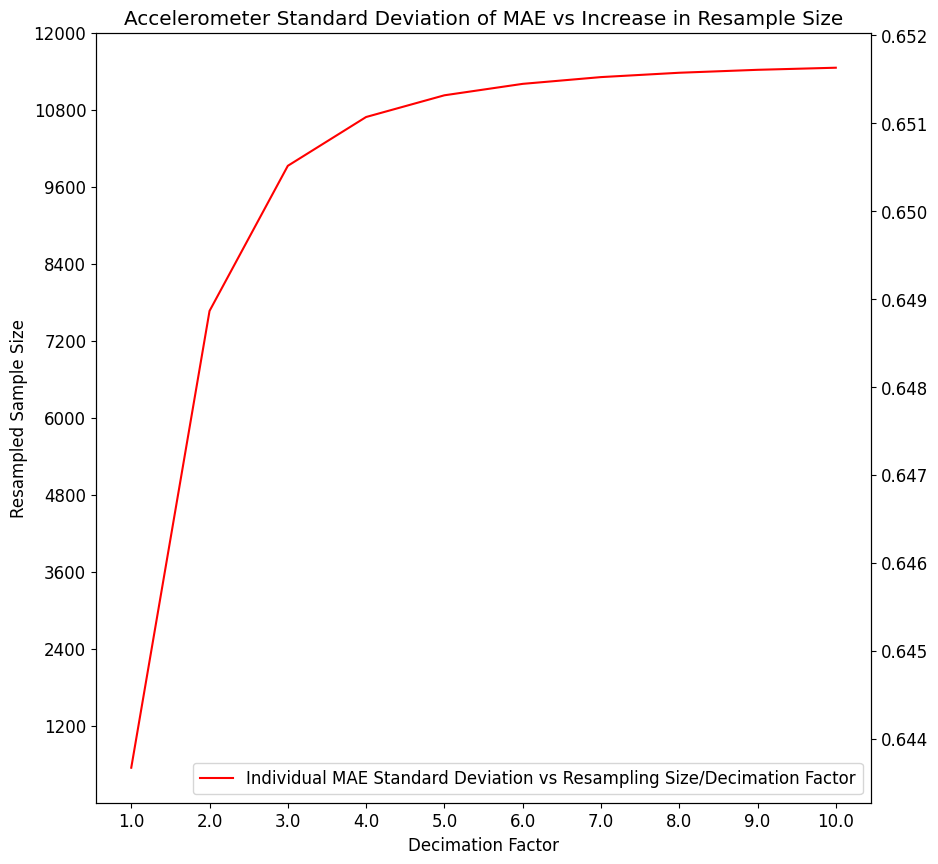

Magnetometer Individual MAE Standard Deviation List
[np.float64(76.99665408010975), np.float64(77.12870632745297), np.float64(77.13264985645536), np.float64(77.14101369778498), np.float64(77.146179689432), np.float64(77.14893652455639), np.float64(77.15084021277971), np.float64(77.1525501098232), np.float64(77.15845650322242), np.float64(77.16367244169288)]
---------------------------


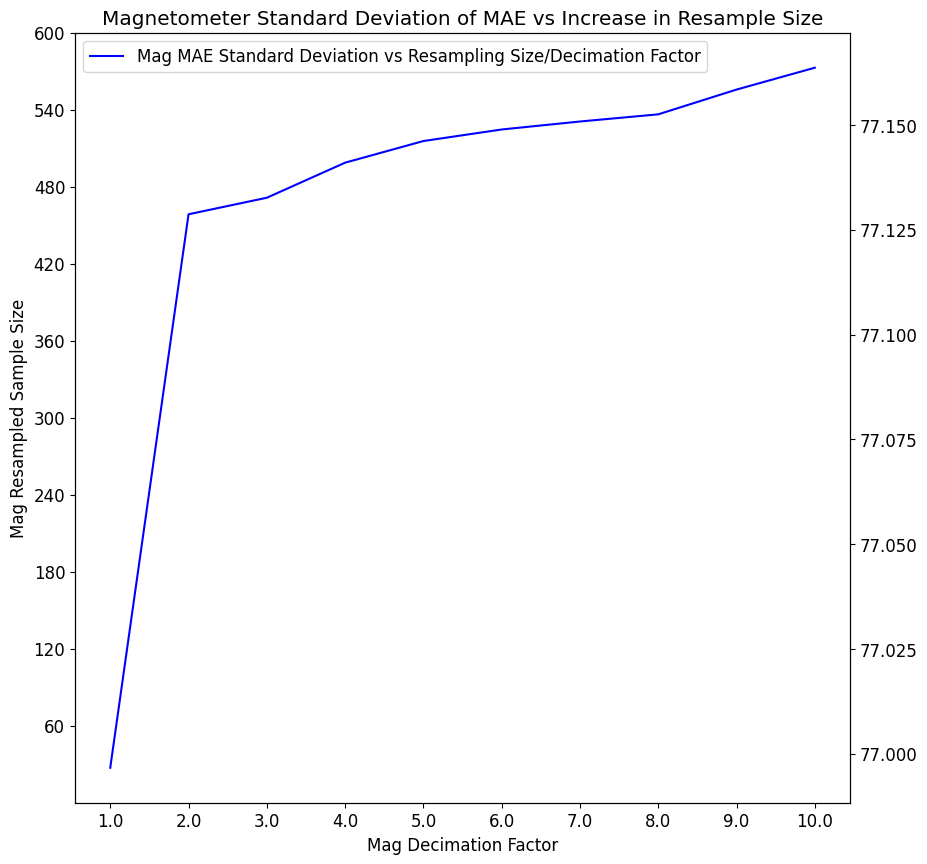

Gyroscope Individual MAE Standard Deviation List
[np.float64(0.0018748899027328687), np.float64(0.00187502785447516), np.float64(0.0018751839371261162), np.float64(0.0018752055452476311), np.float64(0.0018752082049231854), np.float64(0.001875207647478418), np.float64(0.0018752065982872458), np.float64(0.0018752056297485628), np.float64(0.001875204838229329), np.float64(0.00187520420596832)]
---------------------------


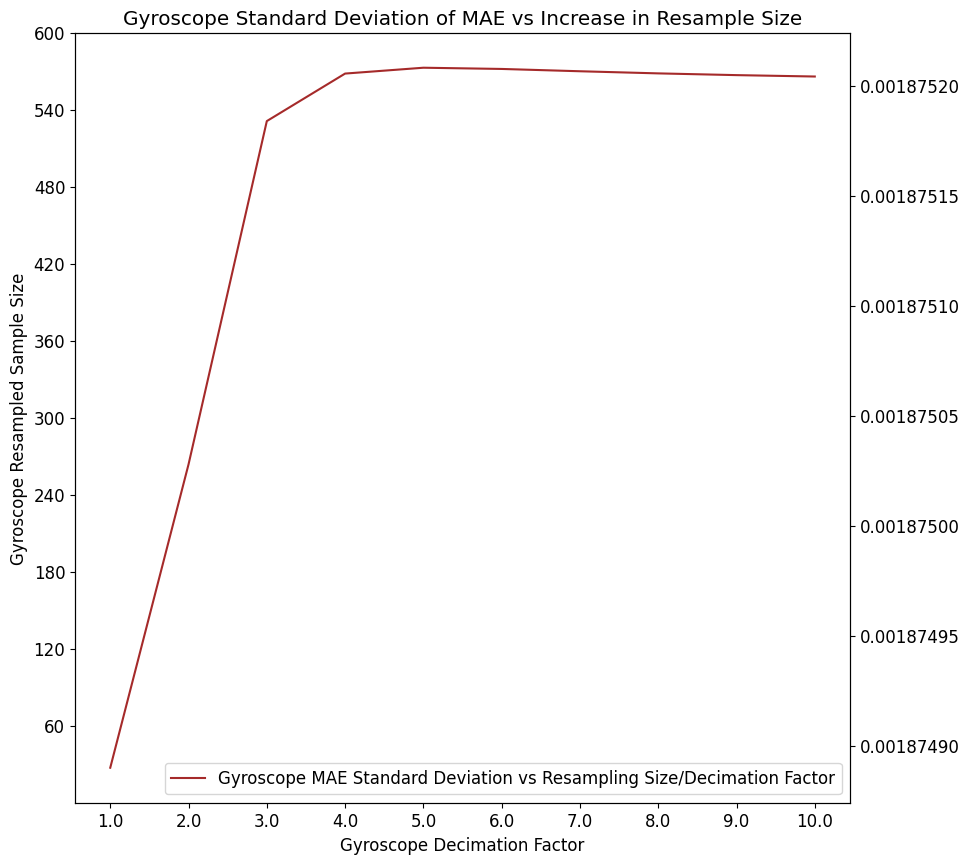

Accelerometer Standard Deviation Average:
0.6503211745553512
---------------------------
Magnetometer Standard Deviaion Average:
77.13196594433096
---------------------------
Gyroscope Variance Average:
0.0018751544364216835


In [ ]:
# Calculating Total MAE Variance/Standard Deviation

mse_variance_xl = np.var(mean_squared_list)
print("Total Variance of MAE for Accelerometer")
print(mse_variance_xl)
print("---------------------------")

mse_variance_mag = np.var(mag_mean_squared_list)
print("Total Variance of MAE for Magnetometer")
print(mse_variance_mag)
print("---------------------------")

mse_variance_gy = np.var(gy_mean_squared_list)
print("Total Variance of MAE for Gyroscope")
print(mse_variance_gy)
print("---------------------------")

#  Calculating Individual MAE Variance/Standard Deviation for Accelerometer
variance_list = []
for interval in total_interval_vals:
    interval_var = np.std(interval)
    variance_list.append(interval_var)

print("Individual MAE Standard Deviation List")
print(variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(decimate_sizes, variance_list, label="Individual MAE Standard Deviation vs Resampling Size/Decimation Factor", c="red")
ax1.set_xticks(decimate_sizes, labels=list(decimate_sizes))
ax1.set_yticks(resample_sizes, labels=list(resample_sizes))
ax1.set_xlabel("Decimation Factor")
ax1.set_ylabel("Resampled Sample Size")
ax1.set_title("Accelerometer Standard Deviation of MAE vs Increase in Resample Size")
plt.legend()
plt.show()

#  Calculating Individual MAE Variance/Standard Deviation for Magnetometer
mag_variance_list = []
for mag_interval in mag_total_interval_vals:
    mag_interval_var = np.std(mag_interval)
    mag_variance_list.append(mag_interval_var)
    
print("Magnetometer Individual MAE Standard Deviation List")
print(mag_variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(mag_decimate_sizes, mag_variance_list, label="Mag MAE Standard Deviation vs Resampling Size/Decimation Factor", c="blue")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(mag_decimate_sizes, labels=list(mag_decimate_sizes))
ax1.set_yticks(mag_resample_sizes, labels=list(mag_resample_sizes))
ax1.set_xlabel("Mag Decimation Factor")
ax1.set_ylabel("Mag Resampled Sample Size")
ax1.set_title("Magnetometer Standard Deviation of MAE vs Increase in Resample Size")
plt.legend()
plt.show()

#  Calculating Individual MAE Variance/Standard Deviation for Gyroscope
gy_variance_list = []
for gy_interval in gy_total_interval_vals:
    gy_interval_var = np.std(gy_interval)
    gy_variance_list.append(gy_interval_var)
    
print("Gyroscope Individual MAE Standard Deviation List")
print(gy_variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
ax_t = ax1.twinx()
ax_t.plot(gy_decimate_sizes, gy_variance_list, label="Gyroscope MAE Standard Deviation vs Resampling Size/Decimation Factor", c="brown")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax_t.yaxis.set_major_formatter(formatter)
ax1.set_xticks(gy_decimate_sizes, labels=list(gy_decimate_sizes))
ax1.set_yticks(gy_resample_sizes, labels=list(mag_resample_sizes))
ax1.set_xlabel("Gyroscope Decimation Factor")
ax1.set_ylabel("Gyroscope Resampled Sample Size")
ax1.set_title("Gyroscope Standard Deviation of MAE vs Increase in Resample Size")
plt.legend()
plt.show()


# Average of Accelerometer Variance List
xl_var_avg = np.average(variance_list)
print("Accelerometer Standard Deviation Average:")
print(xl_var_avg)
print("---------------------------")

# Average of Magnetometer Variance List
mag_var_avg = np.average(mag_variance_list)
print("Magnetometer Standard Deviaion Average:")
print(mag_var_avg)
print("---------------------------")

# Average of Gyroscope Variance List
gy_var_avg = np.average(gy_variance_list)
print("Gyroscope Variance Average:")
print(gy_var_avg)


In [18]:
# Deducing errors due to Resampling and Decimating on Analysis

len_w = 3000
print(np.array(total_interval_vals).shape)
print(np.array(mag_total_interval_vals).shape)
print(np.array(gy_total_interval_vals).shape)


(10, 582)
(10, 590)
(10, 589)


590
[237.91008395837176, 215.26077967352168, 266.0456635725015, 208.28774437671984, 242.55560817792966, 225.47286848516103, 249.8281586035586, 233.61756595215573, 219.70563205001181, 241.25405330438036, 207.19826869264008, 247.48064330745763, 227.5792743369053, 245.7325802246227, 241.01900067953684, 259.98099371675204, 246.7978920327615, 218.43663260052753, 279.6022335847643, 234.50591603894134, 285.1728349972237, 223.30065862907813, 250.71080386281724, 243.26342817872833, 223.06806707804049, 226.6991391785294, 237.44531318809467, 226.6432448021601, 248.2465236131828, 233.82735925990096, 225.7986235460427, 251.70347138356087, 230.99698037802364, 296.7927768114776, 222.42508638055824, 289.35057482962617, 286.59219423960377, 249.27630288231342, 269.6777165605076, 225.93441044554038, 248.51547946765768, 255.6305913079344, 205.19527880632117, 270.2535832123628, 266.5358110576199, 306.11668004331614, 234.2754020720753, 253.1475545163074, 230.24276982966512, 232.20114632942216, 216.666032527

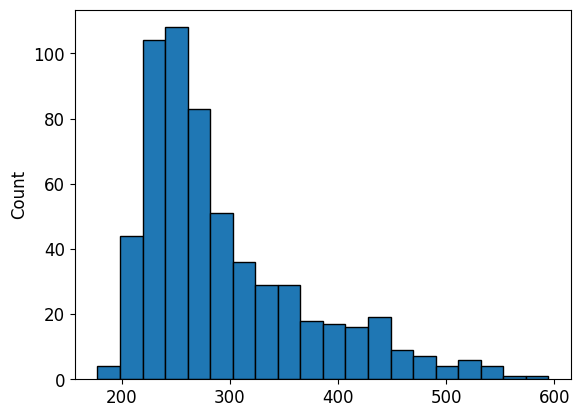

In [19]:
# MSE Histogram of Magnetometer with Resampling Rate of 60*2 = 120

print(len(mag_total_interval_vals[1]))
print(mag_total_interval_vals[1])
plt.hist(mag_total_interval_vals[1], bins = 20, edgecolor="black")
plt.ylabel("Count")
plt.show()

[[ 2.32653854  1.91878047 -0.11537844 ...  1.22973646 -0.90074102
  -1.76238194]
 [ 2.32653854  1.91913856 -0.11473602 ...  1.16408923 -1.00157868
  -1.86721923]
 [ 2.32653854  1.91912972 -0.11422609 ...  1.14814972 -0.98900284
  -1.86164865]
 ...
 [ 2.32653854  1.91943389 -0.11474037 ...  1.11562253 -1.10904194
  -1.97033317]
 [ 2.32653854  1.91916321 -0.11489437 ...  1.16594093 -1.01172155
  -1.87487205]
 [ 2.32653854  1.91902701 -0.11480143 ...  1.18191043 -0.96480064
  -1.83110497]]


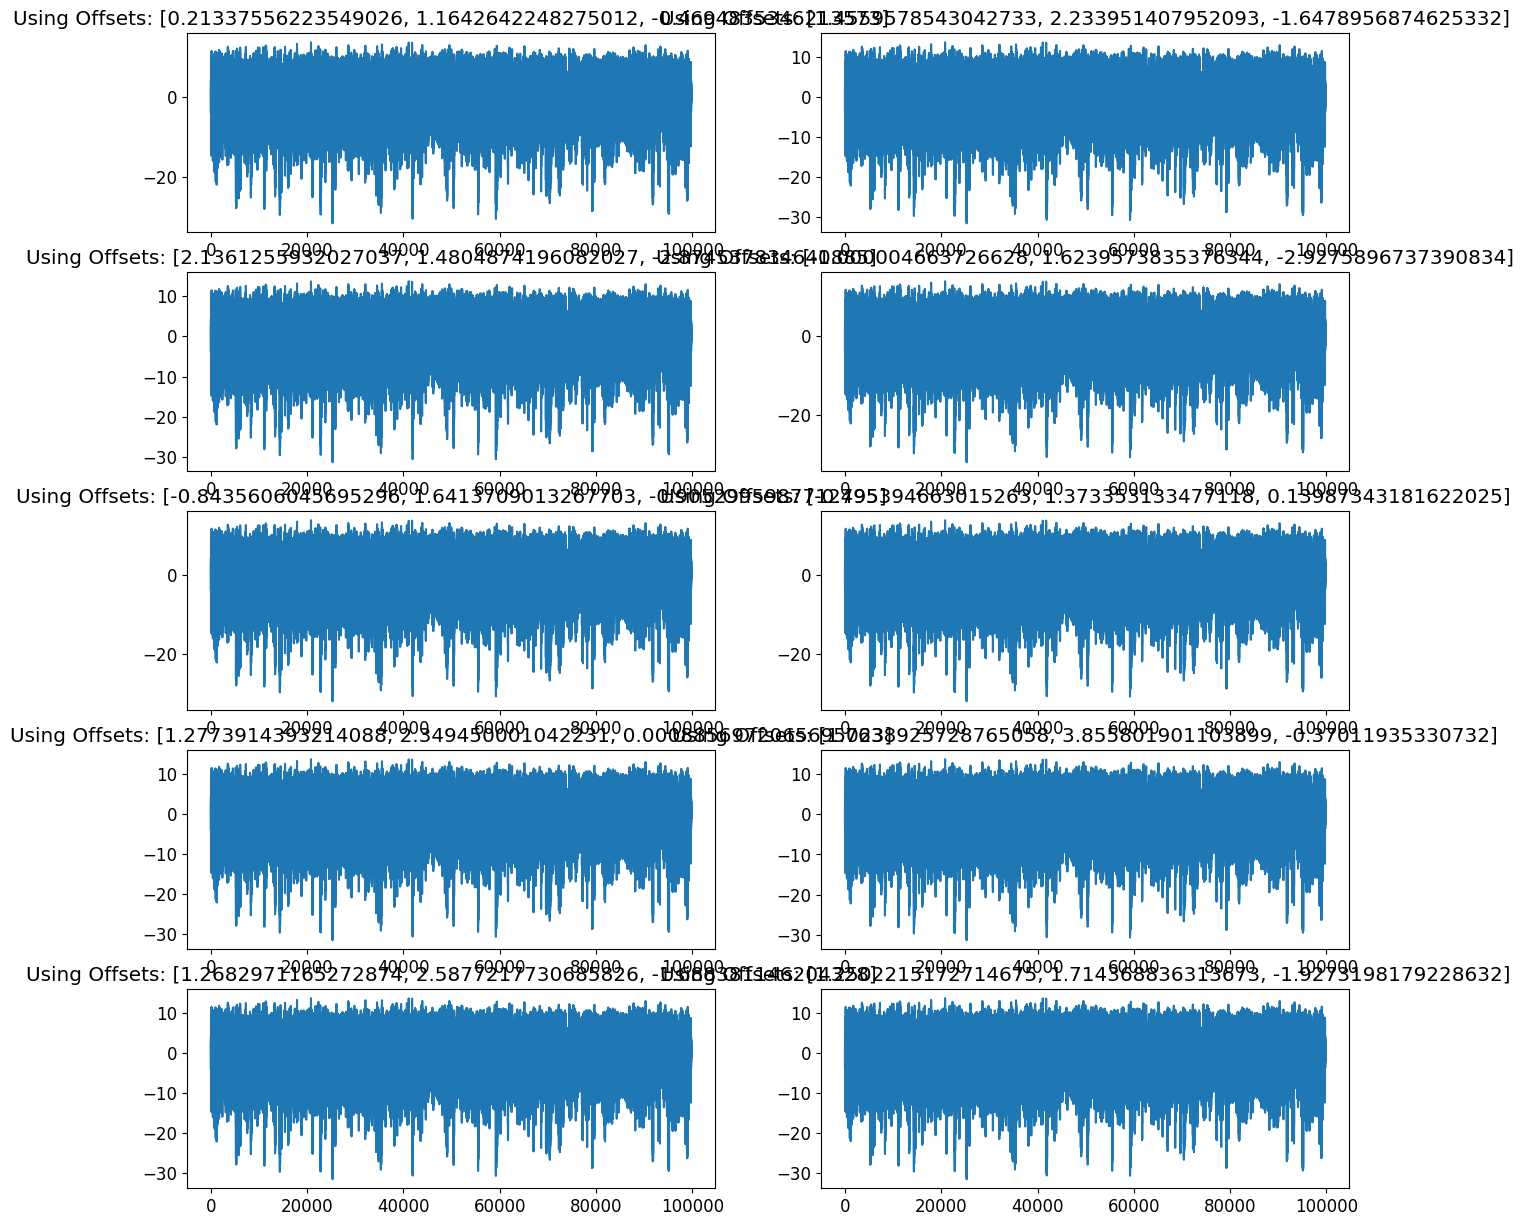

0        2.326539
1        2.122660
2        1.376647
3        0.336951
4       -0.537798
           ...   
99795   -2.499300
99796   -2.503406
99797   -2.507981
99798   -2.505068
99799   -2.498891
Length: 99800, dtype: float64
-1.9333902304453954
0        2.326539
1        2.122839
2        1.376980
3        0.337796
4       -0.536552
           ...   
99795   -2.495800
99796   -2.499779
99797   -2.504370
99798   -2.501487
99799   -2.495302
Length: 99800, dtype: float64
-1.936349614042283
0        2.326539
1        2.122834
2        1.377147
3        0.338224
4       -0.535872
           ...   
99795   -2.485331
99796   -2.489378
99797   -2.494023
99798   -2.491056
99799   -2.484809
Length: 99800, dtype: float64
-1.9320307612353211
0        2.326539
1        2.122599
2        1.376338
3        0.336163
4       -0.539013
           ...   
99795   -2.513528
99796   -2.517593
99797   -2.522084
99798   -2.519252
99799   -2.513140
Length: 99800, dtype: float64
-1.9384359918064493
0        

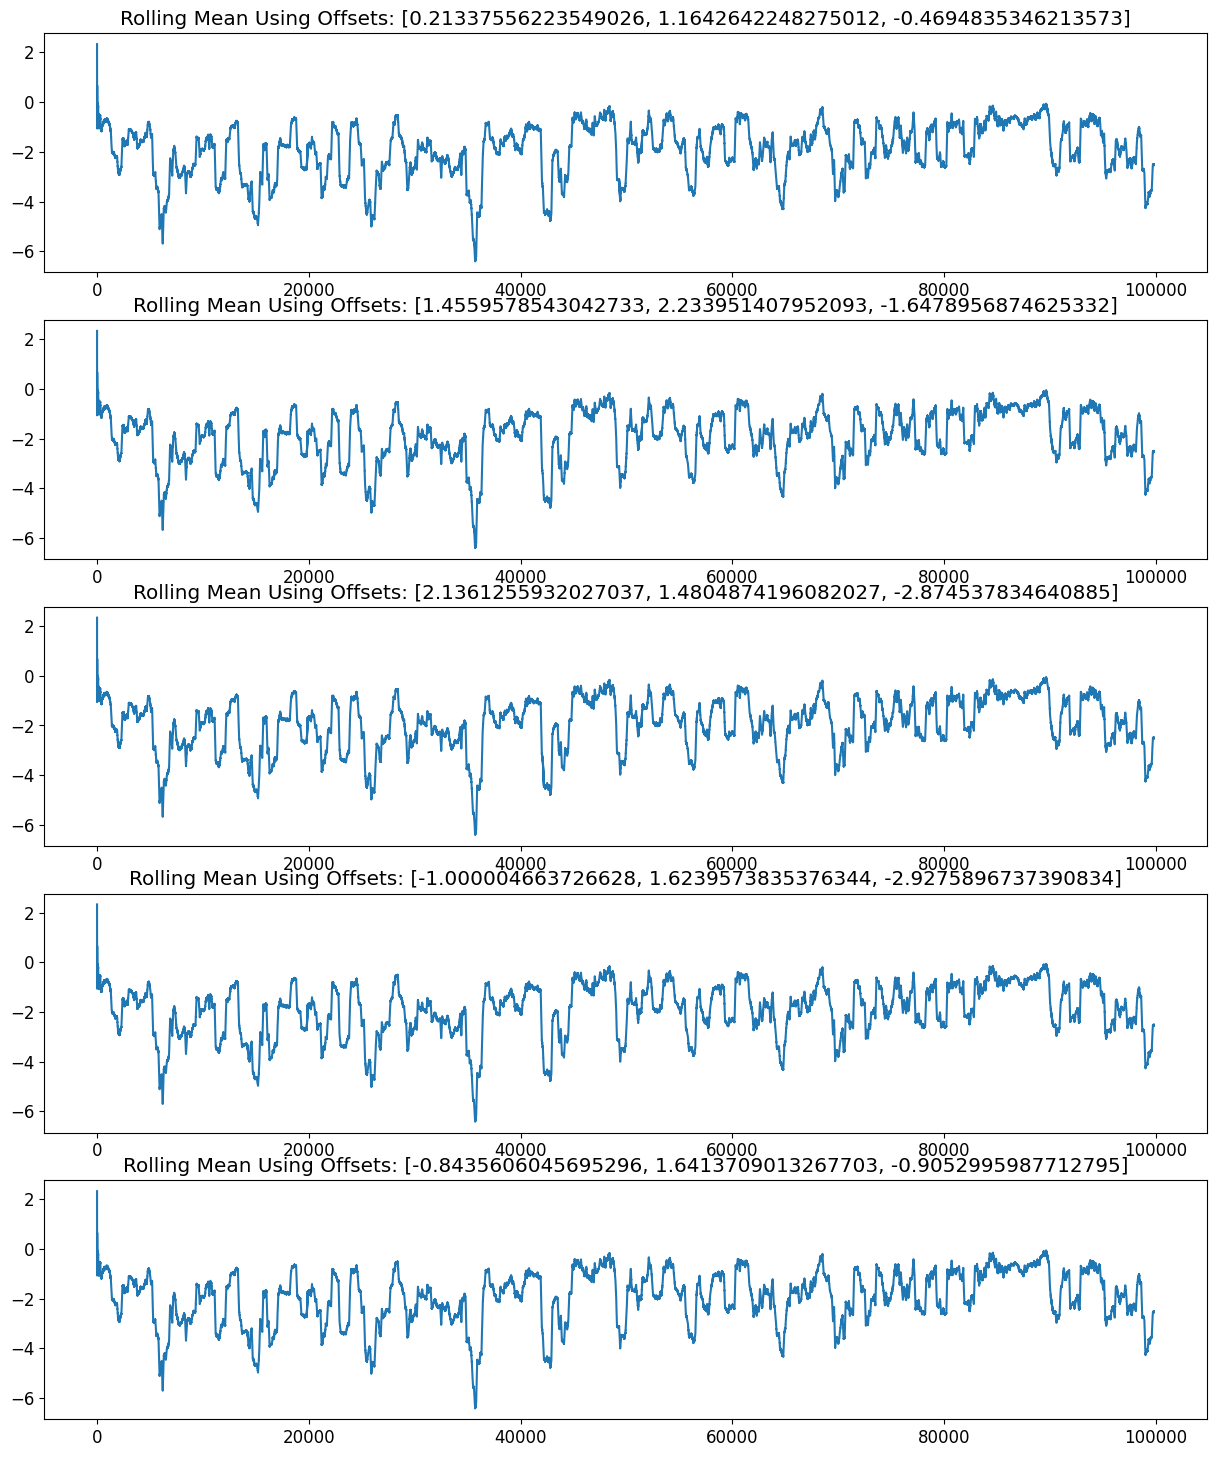

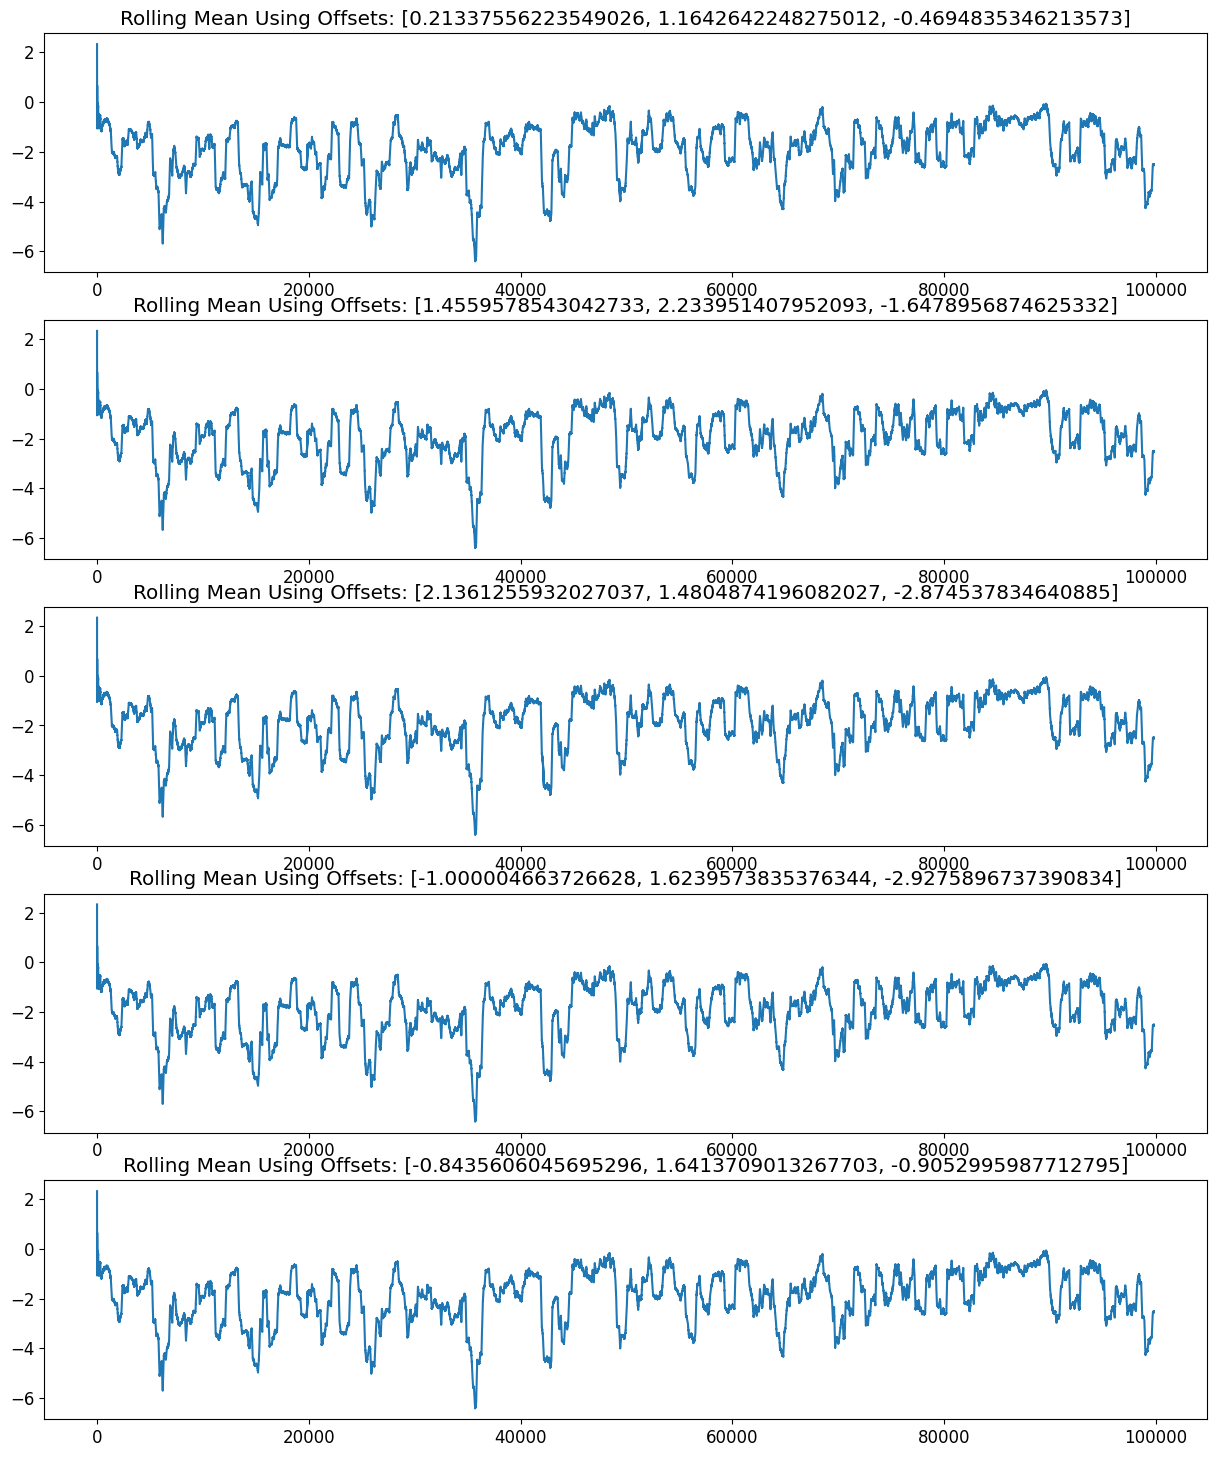

In [20]:
# Visualizing Gyr Offset Effects

interval_odr = 100
init_offset = [.58, .42, -.3]
ned_lists = []

offset_list = []

for _ in range(10):
    gyr_offsets = [np.random.normal(init_offset[i], 1) for i in range(3)]
    xl_global = []
    prev_q = [1,0,0,0]

    xl_w = [] #(3, n, 3) => window size 3, n points, xyz axis
    gy_w = []
    mg_w = []

    for (name1, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):

        xl_ = correct_data(xl_grp.drop(columns=['interval']).values)
        mg_ = correct_data(mg_grp.drop(columns=['interval']).values)
        gy_ = correct_data(gy_grp.drop(columns=['interval']).values)
        xl_p, mg_p, gy_p = preprocess_imu(xl_[:,1:], mg_[:,1:], gy_[:,1:], gyr_offset = gyr_offsets)

        xl_w.append(xl_p)
        mg_w.append(mg_p)
        gy_w.append(gy_p)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
            mg_w.pop(0)
            gy_w.pop(0)
    
        if len(xl_w) != 3:
            continue 

        new_xl_w = [] # to unpack all 3 intervals for the window
        new_mg_w = []
        new_gy_w = []
        len_w = []
        len_mg_w = []
        len_gy_w = []

        for j, itvl in enumerate(xl_w):
            new_xl_w.append(itvl)
            len_w.append(len(itvl)) 
        for k, itvl in enumerate(mg_w):
            new_mg_w.append(itvl)
            len_mg_w.append(len(itvl))
        for l, itvl in enumerate(gy_w):
            new_gy_w.append(itvl)
            len_gy_w.append(len(itvl))

        new_xl_w = np.vstack(new_xl_w)
        new_mg_w = np.vstack(new_mg_w)
        new_gy_w = np.vstack(new_gy_w)

        xl_t = time_align(xl_w, 1000, interval_odr, 'xl')
        mg_t = time_align(mg_w, 20, interval_odr, 'mg')
        gy_t = time_align(gy_w, 1000, interval_odr, 'gy')

        # xl_t = resample(new_xl_w, num = 6000, axis = 0)
        # xl_t = decimate(xl_t, q = 2, axis = 0)

        # mg_t = resample(new_mg_w, num = 120, axis = 0)
        # mg_t = decimate(mg_t, q = 2, axis = 0)

        # gy_t = resample(new_gy_w, num = 6000, axis = 0)
        # gy_t = decimate(gy_t, q = 2, axis = 0)

        #Madgwick model gives quaternion vectors that rotate xl vector from sensor to ned frame
        model = Madgwick(acc=xl_t, mag=mg_t, gyr=gy_t, frequency=interval_odr, q0 = prev_q)
        prev_q = model.Q[-1]

        for q,x in zip(model.Q, xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec = rotate_to_ned(q, norm_vec, madg = True)
            ned_vec *= mag
            ned_vec[2] -= 9.810665 #in ned frame, assume z axis aligns with gravity, subtract it off
            xl_global.append(ned_vec)

    xl_global = np.array(xl_global)

    offset_list.append(gyr_offsets)

    init_offset = gyr_offsets
    ned_lists.append(xl_global[:,-1])

print(np.array(ned_lists))
    
fig, axes = plt.subplots(5, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
row_count = 0
for i in range(0, 9, 2):
    axes[row_count, 0].plot(ned_lists[i])
    axes[row_count, 0].set_title("Using Offsets: " + str(offset_list[i]))
    axes[row_count, 1].plot(ned_lists[i+1])
    axes[row_count, 1].set_title("Using Offsets: " + str(offset_list[i+1]))
    row_count += 1
plt.show()

fig, axes = plt.subplots(5, 1)
fig.set_figheight(18)
fig.set_figwidth(15)
averages = []
for j in range(5):
    rolling_mean = pd.Series(ned_lists[j]).rolling(window = 1000, min_periods = 1).mean()
    print(rolling_mean)
    axes[j].plot(rolling_mean)
    axes[j].set_title("Rolling Mean Using Offsets: " + str(offset_list[j]))
    print(np.average(rolling_mean))
    averages.append(np.average(rolling_mean))

fig, axes = plt.subplots(5, 1)
fig.set_figheight(18)
fig.set_figwidth(15)
for k in range(5):
    rolling_mean = pd.Series(ned_lists[k]).rolling(window = 1000, min_periods = 1).mean()
    print(rolling_mean)
    axes[k].plot(rolling_mean)
    axes[k].set_title("Rolling Mean Using Offsets: " + str(offset_list[k]))
    print(np.average(rolling_mean))
    averages.append(np.average(rolling_mean))

print("Rolling Mean Averages: " + str(averages))

plt.show()

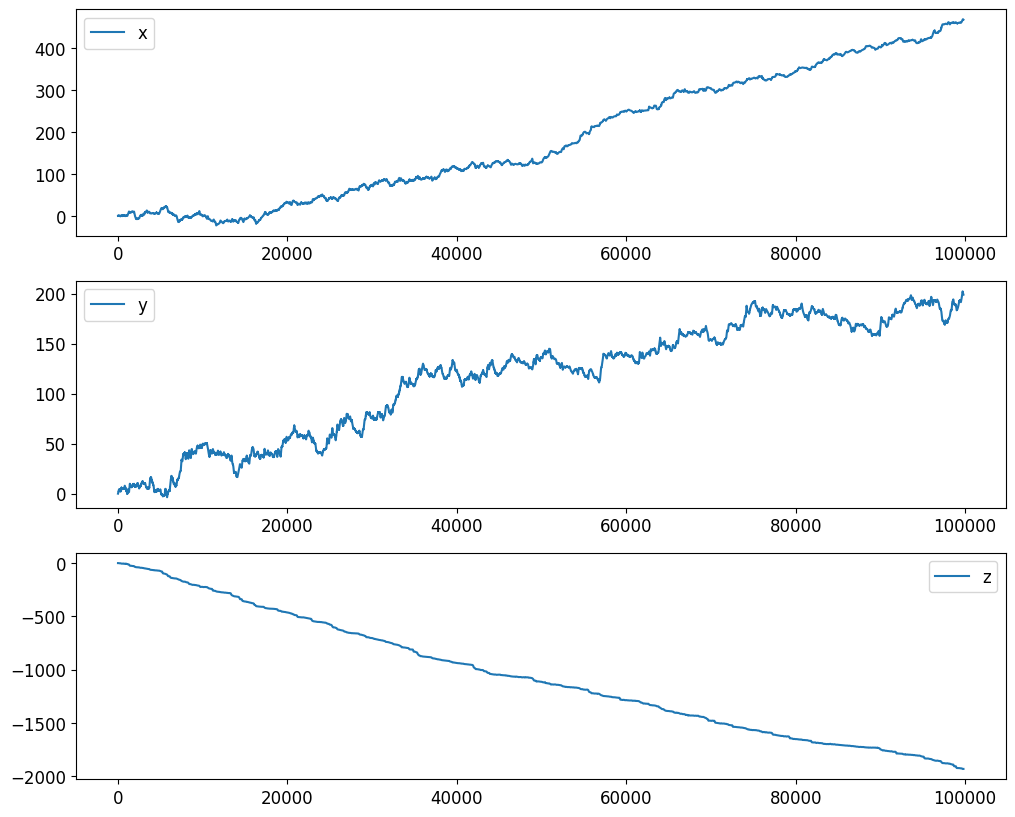

In [21]:
def imu_dead_reckoning(xl_ned, dt):
    """Calculate position, velocity and bearing from xl/mag sensors in NED frame
    Args:
        xl_ned, mag_ned: sensor data in NED frame
        dt: timestamp delta
    Retuns:
        position, velocity, bearing 
    """
    velocity = np.zeros((len(xl_ned), 3))
    position = np.zeros((len(xl_ned), 3))

    for t in range(1, len(xl_ned)):
        velocity[t] = velocity[t-1] + (xl_ned[t-1] * dt)
        position[t] = position[t-1] + (velocity[t] * dt)
    
    fig, axes = plt.subplots(3, figsize=(12,10))
    axes[0].plot(velocity[:,0], label='x')
    axes[1].plot(velocity[:,1], label='y')
    axes[2].plot(velocity[:,2], label='z')

    for ax in axes:
        ax.legend()

    plt.show()

    return position, velocity

xl_ned_pos, xl_ned_vel = imu_dead_reckoning(xl_ned, 1/100) #dt is set to 1/100, I downsampled to 100 points per second 

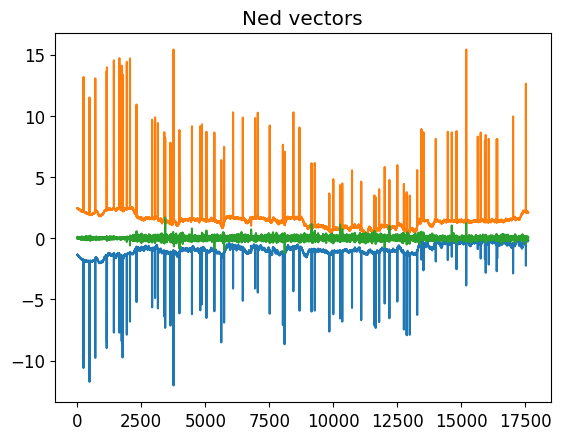

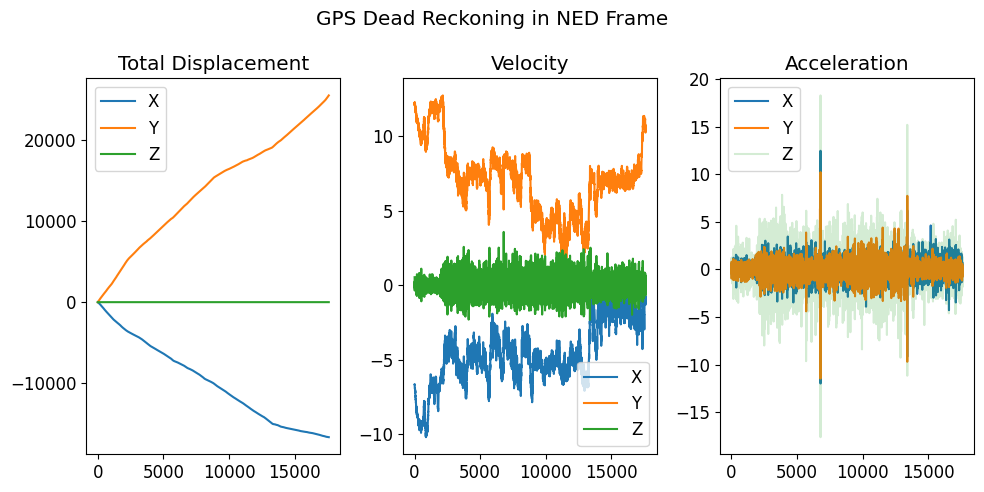

In [22]:
# Pasting relevant GPS dead_reckoning functions for ewma implementation

gps_gf = np.load("gps_data.npy")
gps_df = pd.DataFrame(gps_gf[1:,:], columns=gps_gf[0,:])
cols_to_convert = gps_df.columns[gps_df.columns != 'interval_id']
gps_df[cols_to_convert] = gps_df[cols_to_convert].apply(pd.to_numeric, errors='coerce') 

def rotation_ned(lat, lon):
    R_ned = np.array([[-np.sin(lat)*np.cos(lon), -np.sin(lat)*np.sin(lon), np.cos(lat)],
                     [-np.sin(lon), np.cos(lon),0],
                     [-np.cos(lat)*np.cos(lon), -np.cos(lat)*np.sin(lon), -np.sin(lat)]])
    return R_ned 
    
def ecef_to_ned(gps_pos_ref):
    deltas = (gps_pos_ref[['Node[1].ECEF.X', 'Node[1].ECEF.Y', 'Node[1].ECEF.Z']].values /1000) - (gps_pos_ref[['Node[1].ECEF.X.ref', 'Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref']].values/1000)   
    
    #use reference lat and lon points 
    lons = gps_pos_ref['Node[1].LLH.Lon.ref'] * (np.pi/180) 
    lats = gps_pos_ref['Node[1].LLH.Lat.ref'] * (np.pi/180)

    ned_values = []
    mags = []
    for i, (lat, lon) in enumerate(zip(lats, lons)): 
        rotation_matrix = rotation_ned(lat,lon)
        norm = np.linalg.norm(deltas[i,:])
        ned_vec = rotation_matrix @ deltas[i,:] / norm
        ned_mag = np.linalg.norm(ned_vec)
        mags.append(ned_mag )
        ned_values.append(ned_vec * norm)
    ned_values = np.array(ned_values)
    return ned_values, np.array(mags)

def gps_dead_reckoning(gps_ned, dt, start, end):
    
    plt.plot(gps_ned[:,0], label="x")
    plt.plot(gps_ned[:,1], label="y")
    plt.plot(gps_ned[:,2], label="z")
    plt.title("Ned vectors")
    plt.show()

    vel_ned = gps_ned / dt.values[:, np.newaxis]
    acc_ned = np.diff(vel_ned, axis=0) / dt.values[1:, np.newaxis]  

    displacement = [np.cumsum(gps_ned[:, 0], axis=0), 
                    np.cumsum(gps_ned[:, 1], axis=0),
                    np.cumsum(gps_ned[:, 2], axis=0)]
    
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].plot(np.cumsum(gps_ned[start:end, 0], axis=0), label='X')  
    axes[0].plot(np.cumsum(gps_ned[start:end, 1], axis=0), label='Y') 
    axes[0].plot(np.cumsum(gps_ned[start:end, 2], axis=0), label='Z')  
    axes[0].legend()
    axes[0].set_title("Total Displacement")

    vel_norm = np.linalg.norm(vel_ned[:,:2], axis=1)
    axes[1].plot(vel_ned[start:end, 0], label='X') 
    axes[1].plot(vel_ned[start:end, 1], label='Y')
    axes[1].plot(vel_ned[start:end, 2], label='Z')
    axes[1].legend()    
    axes[1].set_title("Velocity")

    axes[2].plot(acc_ned[start:end, 0], label='X')  
    axes[2].plot(acc_ned[start:end, 1], label='Y')  
    axes[2].plot(acc_ned[start:end, 2], label='Z', alpha=.2) 
    axes[2].legend()
    axes[2].set_title("Acceleration")
    fig.suptitle("GPS Dead Reckoning in NED Frame")
    plt.tight_layout()
    plt.show()

    return displacement, vel_ned, acc_ned

new_gps = gps_df.copy()
modified_shift = gps_df[['Node[1].ECEF.modified', 'timestamp']][1:]

new_gps[['Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref','Node[1].LLH.Lat.ref','Node[1].LLH.Lon.ref','timestamp_ref']] = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y","Node[1].ECEF.Z",'Node[1].LLH.Lat','Node[1].LLH.Lon', 'timestamp']].shift(1)

gps_pos_ref = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y","Node[1].ECEF.Z",'Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref',
                      'Node[1].LLH.Lat.ref', 'Node[1].LLH.Lon.ref','timestamp','timestamp_ref','interval_id']].dropna()

gps_ned, ned_mags = ecef_to_ned(gps_pos_ref)

dt = gps_pos_ref['timestamp'] - gps_pos_ref['timestamp_ref']
pos_gps , vel_gps, acc_ned = gps_dead_reckoning(gps_ned, dt, start=0, end=-1)

In [23]:
new_xl_global_ned = np.genfromtxt('node1_global_xl_combined.csv', delimiter=',')
print(new_xl_global_ned.shape)
print(new_xl_global_ned[1:,:])

(996001, 6)
[[ 0.00000000e+00 -1.11028382e+00  2.28551608e+00 -2.97470529e+00
   4.67577905e+07  2.00000000e+00]
 [ 1.00000000e+00 -8.70748107e-01  5.57548860e+00 -8.26840511e+00
   4.67577905e+07  2.00000000e+00]
 [ 2.00000000e+00 -2.09536998e+00  3.74270554e+00 -8.58355728e+00
   4.67577905e+07  2.00000000e+00]
 ...
 [ 9.95997000e+05  1.83567696e+00  7.24284192e+00 -4.19273567e+00
   4.67587953e+07  9.97000000e+02]
 [ 9.95998000e+05  9.77170124e-01  6.46475761e+00 -4.81899961e+00
   4.67587953e+07  9.97000000e+02]
 [ 9.95999000e+05  1.83146425e+00  6.32867066e+00 -2.77915181e+00
   4.67587953e+07  9.97000000e+02]]


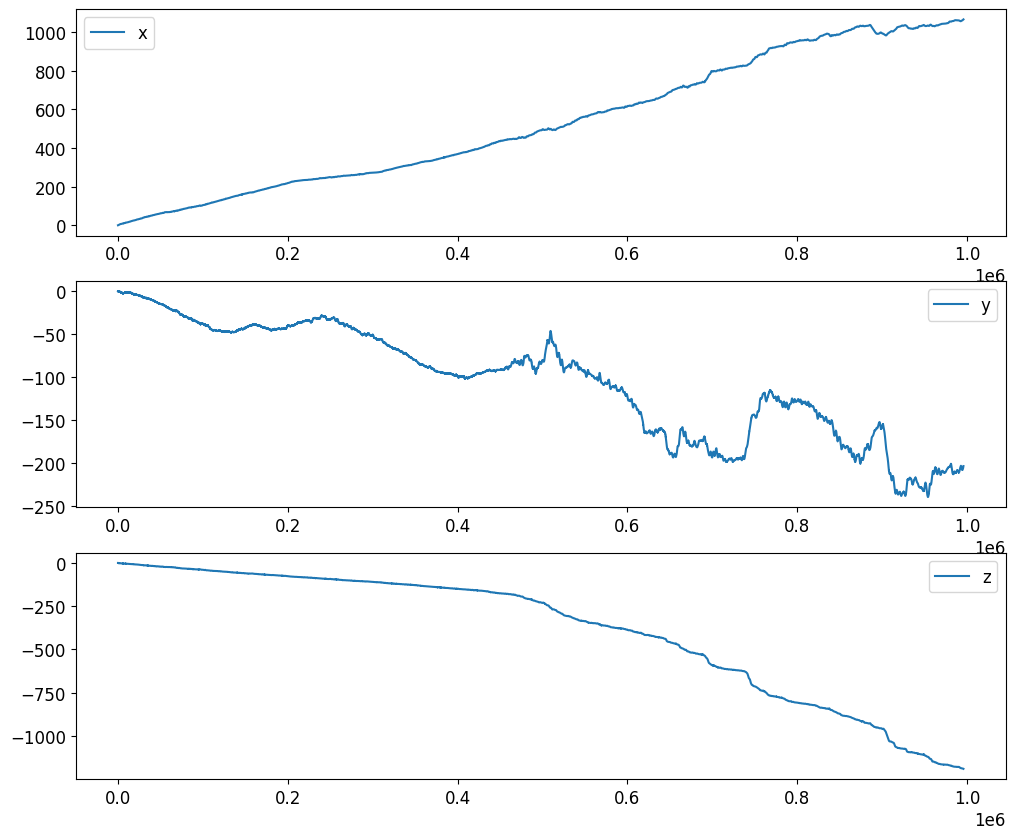

(996000, 3)
(996000,)


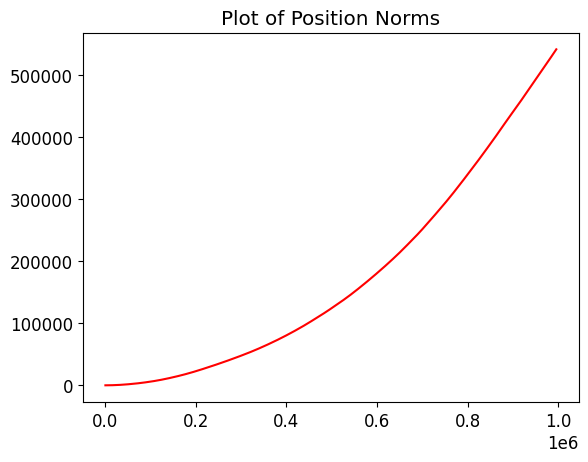

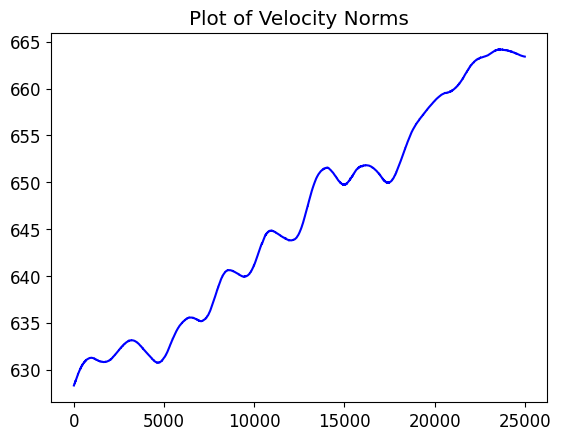

In [24]:
new_xl_global_ned = np.genfromtxt('node1_global_xl_combined.csv', delimiter=',')
new_xl_ned_pos, new_xl_ned_vel = imu_dead_reckoning(new_xl_global_ned[1:,1:4], 1/1000) 

print(new_xl_ned_pos.shape)

xl_pos_norm = np.linalg.norm(new_xl_ned_pos[:,:2], axis = 1)
xl_vel_norm = np.linalg.norm(new_xl_ned_vel[:,:2], axis = 1)

print(xl_pos_norm.shape)

plt.plot(xl_pos_norm, label = "Norm of Position", c = "red")
plt.title("Plot of Position Norms")
plt.show()

plt.plot(xl_vel_norm[600000:625000], label = "Norm of Velocity", c = "blue")
plt.title("Plot of Velocity Norms")
plt.show()

In [25]:
def recompute_t(xl):
    new_ts_col = []
    xl_dt = 1/1000
    for ts in np.unique(xl[1:, 4].astype(int)):
        curr_ts = ts
        for _ in range(1000):
            new_ts_col.append(curr_ts)
            curr_ts += xl_dt

    print(len(new_ts_col))

    return new_ts_col

(17609, 3)
(996000, 3)
(996000, 3)
996000
[46757790.    46757790.001 46757790.002 ... 46758795.997 46758795.998
 46758795.999]
[46757787.  46757787.2 46757787.4 ... 46761384.4 46761384.6 46761384.8]
(996000, 2)
4900
[[2.22689323e+01 7.03902380e+00]
 [2.54092776e-06 2.54092776e-03]
 [1.06069843e-05 8.10678000e-03]
 ...
 [5.41375220e+05 1.08578390e+03]
 [5.41376306e+05 1.08578435e+03]
 [5.41377391e+05 1.08578410e+03]]
(996000, 2)


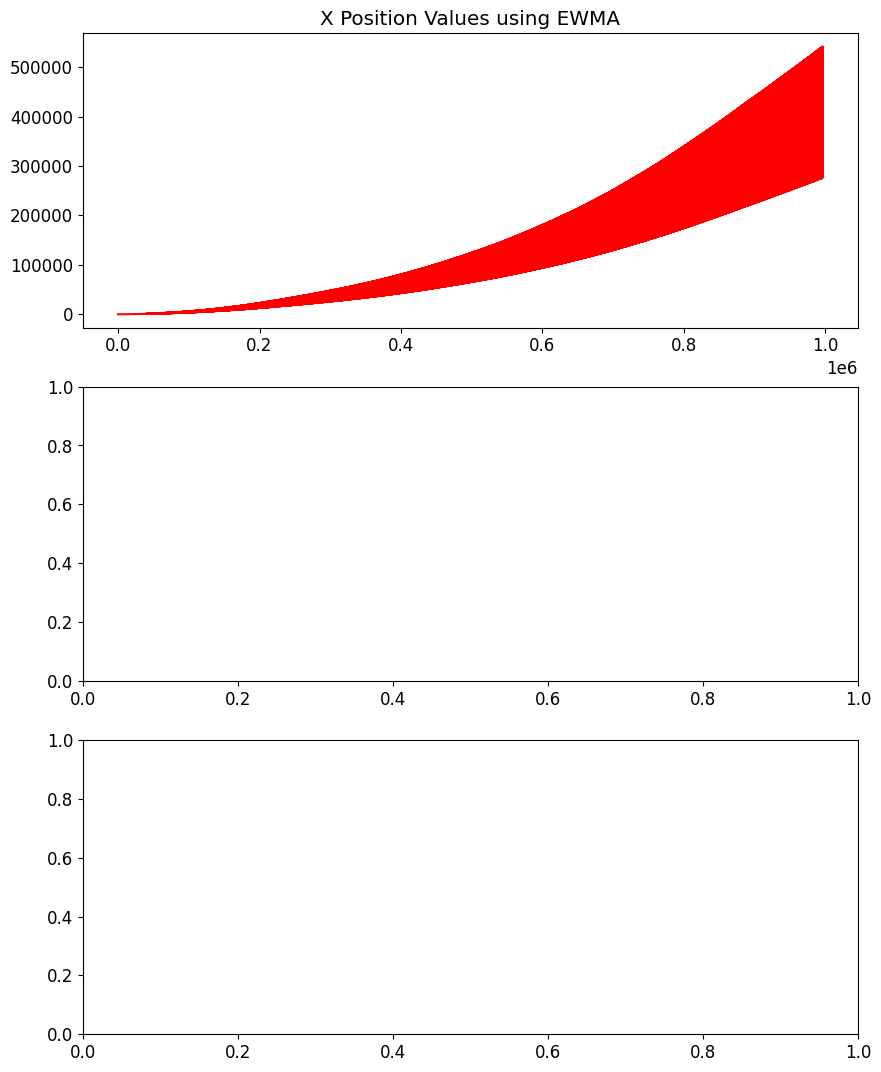

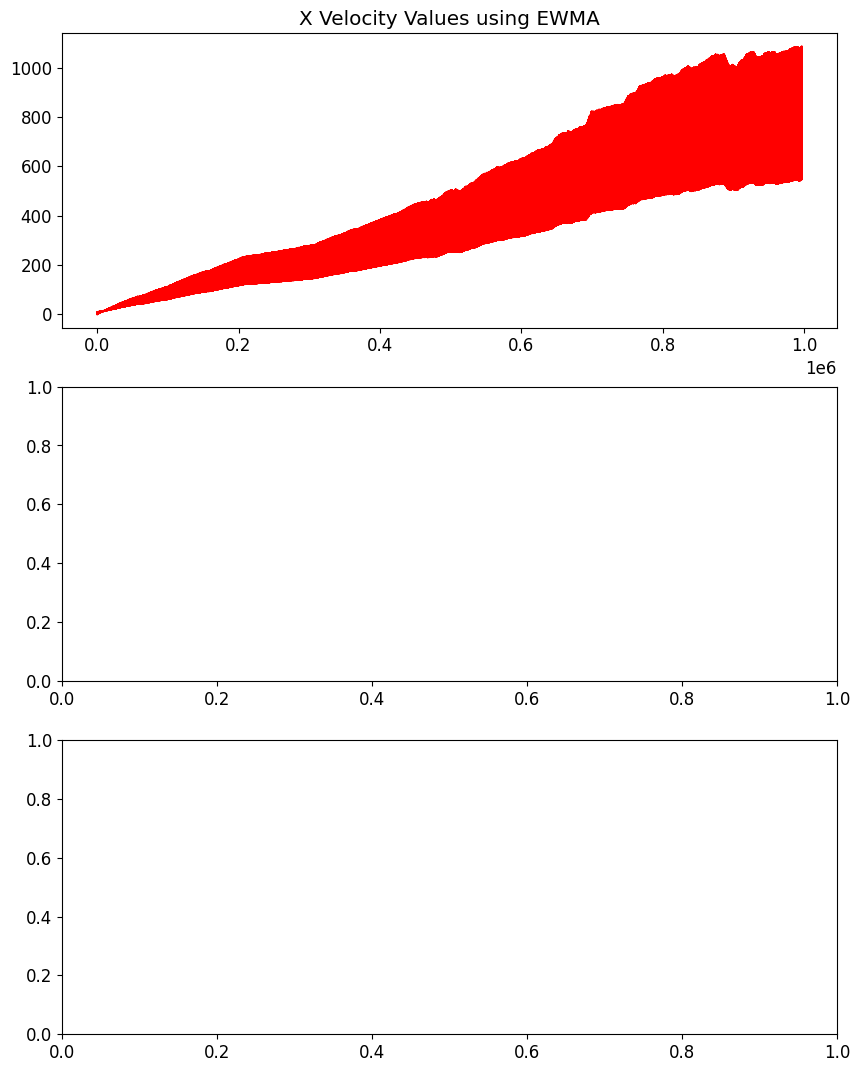

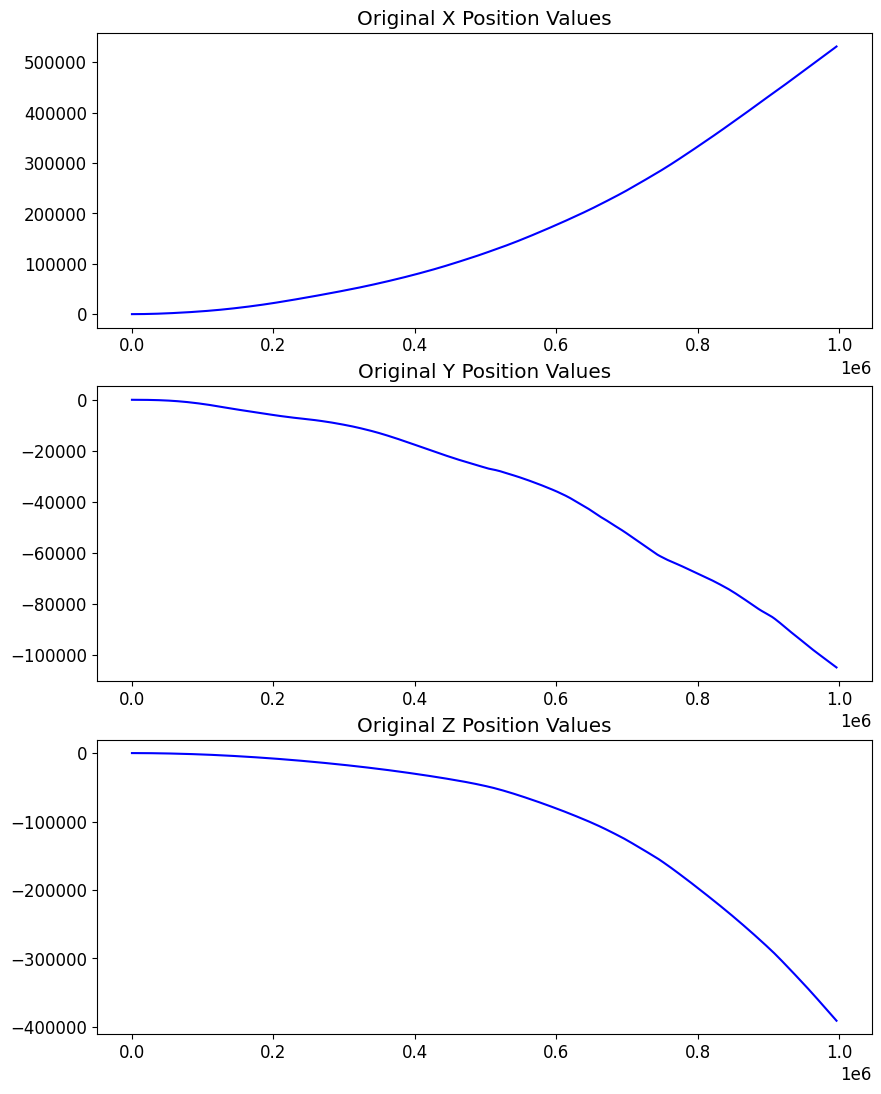

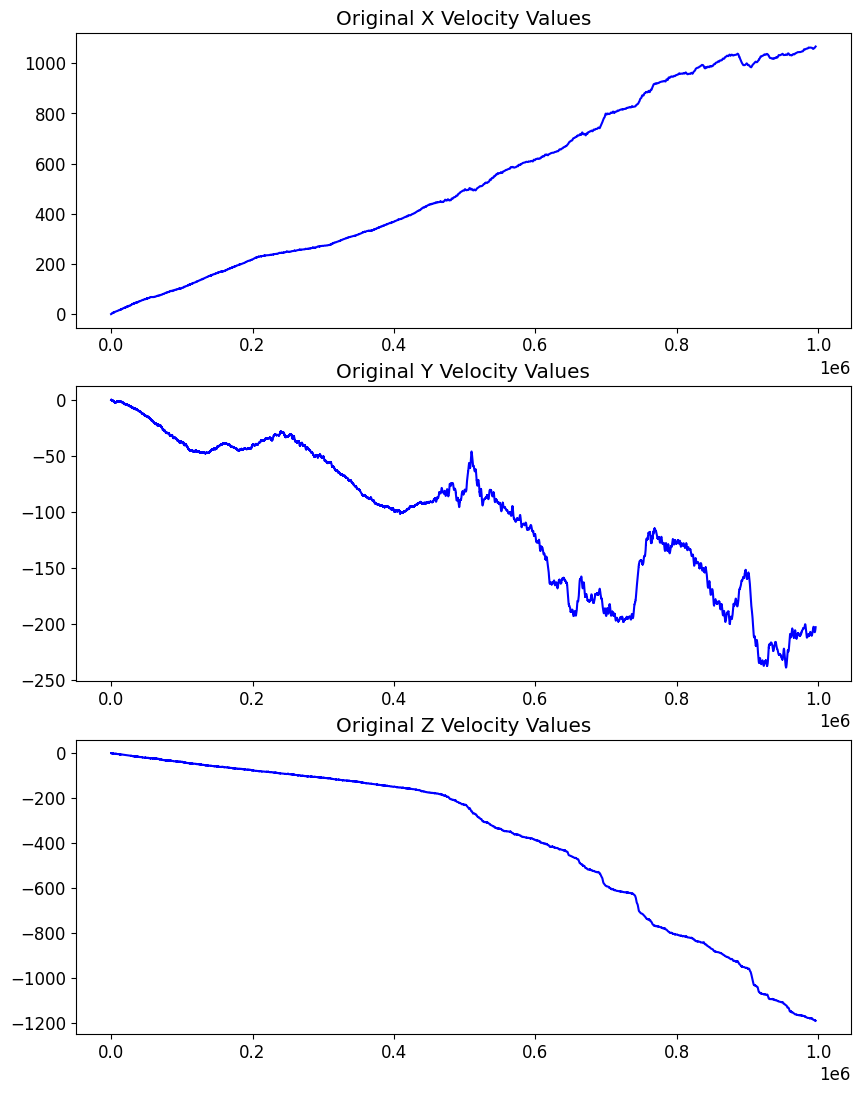

In [26]:
# EWMA with plots

# Recomputing new timestamps for xl_ned
# def recompute_t(xl):
#     new_timestamps = []
#     for i in range(1, 999, 1):
#         interval_loc = np.where(xl[:,0] == i)[0]
#         timestamp_list =  np.linspace(xl[(interval_loc[0]),1], xl[(interval_loc[-1]) + 1,1], num = 100)
#         # modified_list = np.linspace(timestamp_list[0], timestamp_list[-1], num = 100)
#         new_timestamps.append(timestamp_list)
#     new_timestamps = np.array(new_timestamps)
#     new_timestamps = new_timestamps.flatten()
#     print(new_timestamps.shape)
    
#     return new_timestamps

# xl_global['timestamp_aligned'] = pd.Series(new_ts_col)


# EWMA function
def ewma(alpha, gps_p = pos_gps, gps_vel = vel_gps, xl_p = new_xl_ned_pos,
          xl_vel = new_xl_ned_vel, xl = new_xl_global_ned, gps = gps_df):
    gps_p = np.array(gps_p)
    gps_p = gps_p.T
    gps_vel = np.array(gps_vel)

    print(gps_p.shape)
    print(xl_p.shape)
    print(xl_vel.shape)

    # determining the new timestamp calculations
    xl_timestamps = recompute_t(xl)

    gps_timestamps = np.array(gps['timestamp'])
    # xl_timestamps = xl[:,1]
    xl_timestamps = np.round(xl_timestamps, decimals=3)

    print(xl_timestamps)
    print(gps_timestamps)

    imu_arr = np.column_stack((np.linalg.norm(xl_p[:,:2], axis = 1), np.linalg.norm(xl_vel[:,:2], axis = 1)))
    # imu_arr = np.reshape(imu_arr, (996000, 2))
    print(imu_arr.shape)
    
    counter = 0
    for i in range(gps_timestamps.shape[0]):
        index_list = np.where(xl_timestamps == gps_timestamps[i])[0]
        if len(index_list) > 0:
            counter += 1
            for item in index_list:
                norm_p = np.linalg.norm(xl_p[item,:2])
                norm_v = np.linalg.norm(xl_vel[item,:2])
                prev_state = np.hstack((norm_p, norm_v))
                                        
                gps_norm_p = np.linalg.norm(gps_p[i,:2])
                gps_norm_v = np.linalg.norm(gps_vel[i,:2])
                gps_state = np.hstack((gps_norm_p, gps_norm_v))

                curr_state = prev_state + alpha*(gps_state - prev_state)
                imu_arr[item] = curr_state
    print(counter)
    
    return imu_arr

new_arr = ewma(0.5)

# print(np.hstack((xl_ned_pos, xl_ned_vel)).shape)
# print(np.hstack((xl_ned_pos, xl_ned_vel)))

print(np.array(new_arr))
print(np.array(new_arr).shape)

new_arr = np.array(new_arr)

# assert np.array_equal(new_arr[:,:3], xl_ned_pos), "Arrays should not be equal"

# Plot of the EWMA result:

fig, axes = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(13)
axes[0].plot(new_arr[:,0], color = 'red')
axes[0].set_title("X Position Values using EWMA")

# axes[1].plot(new_arr[800000:801000,1], color = 'red')
# axes[1].set_title("Y Position Values using EWMA")

# axes[2].plot(new_arr[800000:801000,2], color = 'red')
# axes[2].set_title("Z Position Values using EWMA")

fig, axes = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(13)
axes[0].plot(new_arr[:,1], color = 'red')
axes[0].set_title("X Velocity Values using EWMA")

# axes[1].plot(new_arr[:,4], color = 'red')
# axes[1].set_title("Y Velocity Values using EWMA")

# axes[2].plot(new_arr[:,5], color = 'red')
# axes[2].set_title("Z Velocity Values using EWMA")

fig, axes = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(13)
axes[0].plot(new_xl_ned_pos[:,0], color = 'blue')
axes[0].set_title("Original X Position Values")

axes[1].plot(new_xl_ned_pos[:,1], color = 'blue')
axes[1].set_title("Original Y Position Values")

axes[2].plot(new_xl_ned_pos[:,2], color = 'blue')
axes[2].set_title("Original Z Position Values")

fig, axes = plt.subplots(3, 1)
fig.set_figwidth(10)
fig.set_figheight(13)
axes[0].plot(new_xl_ned_vel[:,0], color = 'blue')
axes[0].set_title("Original X Velocity Values")

axes[1].plot(new_xl_ned_vel[:,1], color = 'blue')
axes[1].set_title("Original Y Velocity Values")

axes[2].plot(new_xl_ned_vel[:,2], color = 'blue')
axes[2].set_title("Original Z Velocity Values")
plt.show()


In [27]:
# Correct EWMA method

def get_acc(row):
    acc = np.sqrt(row['x']**2 + row['y']**2)
    if row['x'] < 0:
        acc*=-1
 
    return acc
 
def new_ewma(xl_global, gps_df, init_x, alpha=.7):
    
    x_history = [init_x]
    
    for i, row in xl_global.iterrows():
           
        acc = get_acc(row)
        state_prev = x_history[-1]
        prev_pos = state_prev[0]
        prev_vel = state_prev[1]

        # vel_update = prev_vel + (acc * xl_dt)
        # pos_update = prev_pos + (vel_update * xl_dt)
       
        if i != 0:
            dt = xl_global.loc[i,'timestamp_aligned'] - xl_global.loc[i - 1,'timestamp_aligned']
        else:
            dt = 1/1000
 
        xl_ts = row['timestamp_aligned']
        match = gps_df[round(gps_df['timestamp'],3) == round(xl_ts,3)]
       
        if xl_ts > gps_df.iloc[-1]['timestamp']:
            print('Exceeded gps timestamps')
            break
 
        if not match.empty and i != 0:
            vel_xyz = match[['vel.x', 'vel.y']]
            pos_xyz = match[['pos.x', 'pos.y']]
            gps_vel = np.linalg.norm(vel_xyz, axis=1)
            gps_pos = np.linalg.norm(pos_xyz, axis=1)
            gps_state = np.array([gps_pos[0], gps_vel[0]])
 
            state_pred = x_history[-1]
            # print(i)
            # print('state_prev',state_prev)
            # print('gps_state',gps_state)
            gps_update = state_pred + alpha * (gps_state - state_pred)
            # gps_update = (1-alpha) * state_pred + alpha * (gps_state)
            # print('gps_update',gps_update)
            x_history.append(gps_update)

        else:
            u = get_acc(row)
            state_update =  np.array([[1, dt],[0, 1]]) @ np.array(state_prev) + np.array([(dt**2)/2, dt]) * u
            x_history.append(state_update)
 
        # if i == 1000:
        #     break
       
    return np.array(x_history)

In [28]:
# Implementing the correct EWMA method
def new_ecef_to_ned(gps_pos_ref):
    deltas = (gps_pos_ref[['Node[1].ECEF.X', 'Node[1].ECEF.Y', 'Node[1].ECEF.Z']].values /1000) - (gps_pos_ref[['Node[1].ECEF.X.ref', 'Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref']].values/1000)   
    
    #use reference lat and lon points 
    lons = gps_pos_ref['Node[1].LLH.Lon.ref'] * (np.pi/180) 
    lats = gps_pos_ref['Node[1].LLH.Lat.ref'] * (np.pi/180)

    ned_values = []
    mags = []
    timestamps = []
    for i, (lat, lon) in enumerate(zip(lats, lons)): 
        rotation_matrix = rotation_ned(lat,lon)
        norm = np.linalg.norm(deltas[i,:])
        ned_vec = rotation_matrix @ deltas[i,:] / norm
        ned_mag = np.linalg.norm(ned_vec)
        mags.append(ned_mag )
        ned_values.append(ned_vec * norm)
        timestamps.append(gps_pos_ref.iloc[i]['timestamp'])
    ned_values = np.array(ned_values)
    return ned_values, np.array(mags), np.array(timestamps)


def gps_pos_vel(gps_ned, dt): 

    vel_ned = gps_ned / dt.values[:, np.newaxis]
    acc_ned = np.diff(vel_ned, axis=0) / dt.values[1:, np.newaxis]  
    displacement = np.cumsum(gps_ned, axis=0)
    return vel_ned, acc_ned, displacement

new_gps = gps_df.copy()
new_gps[['Node[1].ECEF.X.ref','Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref',
         'Node[1].LLH.Lat.ref','Node[1].LLH.Lon.ref','timestamp_ref']] = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y",
                                                                                  "Node[1].ECEF.Z",'Node[1].LLH.Lat',
                                                                                  'Node[1].LLH.Lon', 'timestamp']].shift(1)

gps_pos_ref = new_gps[["Node[1].ECEF.X", "Node[1].ECEF.Y",
                       "Node[1].ECEF.Z",'Node[1].ECEF.X.ref',
                       'Node[1].ECEF.Y.ref', 'Node[1].ECEF.Z.ref',
                      'Node[1].LLH.Lat.ref', 'Node[1].LLH.Lon.ref',
                      'timestamp','timestamp_ref','interval_id']].dropna()

gps_ned, ned_mags, timestamps = new_ecef_to_ned(gps_pos_ref) 
print(gps_ned.shape, timestamps.shape)

dt = gps_pos_ref['timestamp'] - gps_pos_ref['timestamp_ref']
vel_ned, acc_ned, displacement = gps_pos_vel(gps_ned, dt)
print(vel_ned.shape, acc_ned.shape, displacement.shape)
gps_vel_pos = np.column_stack([vel_ned, displacement, timestamps])

gps_vel_pos_df = pd.DataFrame(gps_vel_pos, columns=['vel.x', 'vel.y', 'vel.z', 'pos.x', 'pos.y', 'pos.z', 'timestamp'])


new_xl_global_df = pd.DataFrame(new_xl_global_ned[1:,:], columns = ['', 'x', 'y', 'z', 'timestamp', 'interval'])
inital_pos = np.linalg.norm([-20.153199, 36.532236])
inital_vel = np.linalg.norm([-6.823665, 12.101643])
init_x = np.array([inital_pos, inital_vel])

new_ts_aligned = []
xl_dt = 1/1000
for ts in np.unique(new_xl_global_df['timestamp'].astype(int)):
    curr_ts = ts
    for _ in range(1000):
        new_ts_aligned.append(curr_ts)
        curr_ts += xl_dt
 
new_xl_global_df['timestamp_aligned'] = new_ts_aligned

new_final_arr = new_ewma(new_xl_global_df, gps_vel_pos_df, init_x)
print(new_final_arr.shape)
print(new_final_arr)

(17609, 3) (17609,)
(17609, 3) (17608, 3) (17609, 3)
(996001, 2)
[[4.17223645e+01 1.38928819e+01]
 [4.17362561e+01 1.38903410e+01]
 [4.17501436e+01 1.38846979e+01]
 ...
 [1.11972419e+04 1.06073547e+01]
 [1.11972525e+04 1.06138929e+01]
 [1.11972631e+04 1.06204813e+01]]


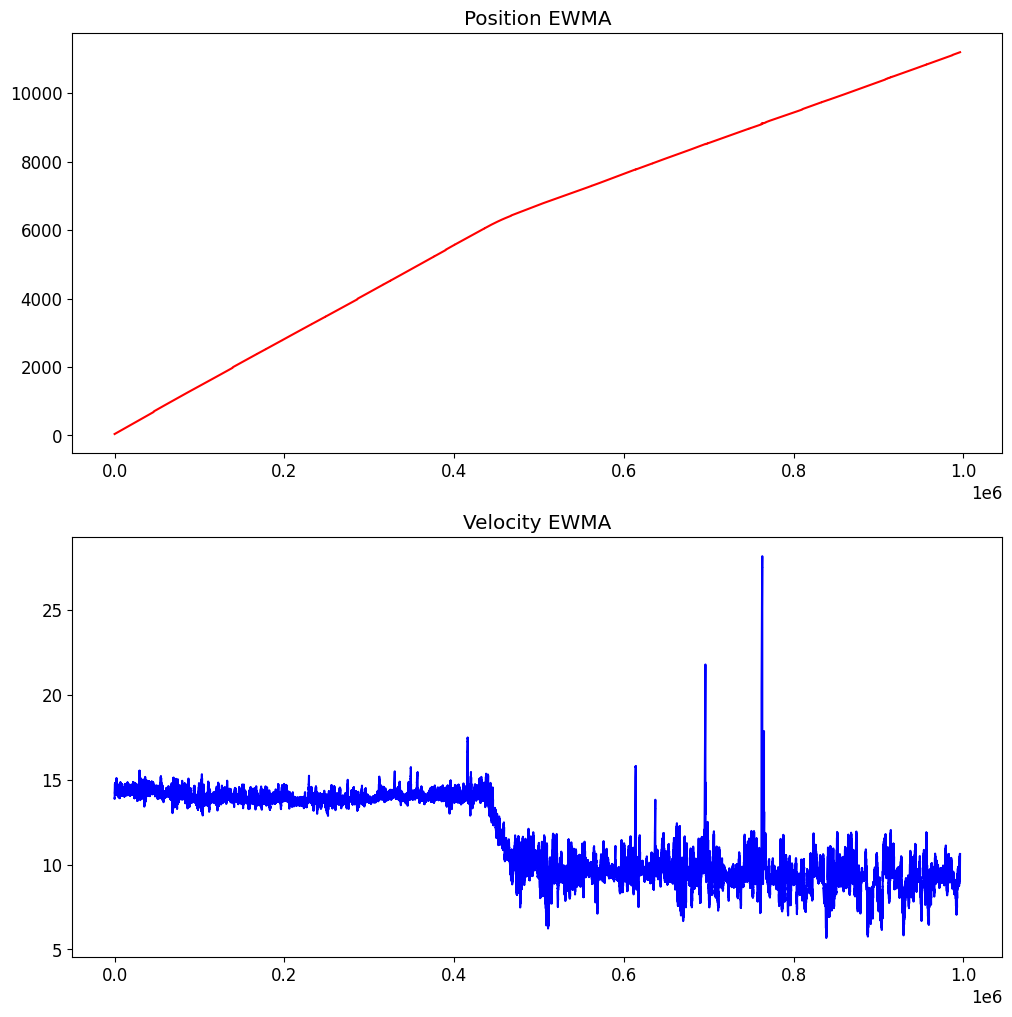

In [29]:
#Graph of EWMA Position

fig, axes = plt.subplots(2,1)
fig.set_figheight(12)
fig.set_figwidth(12)
axes[0].plot(new_final_arr[:,0], color = 'RED')
axes[0].set_title("Position EWMA")

axes[1].plot(new_final_arr[:,1], color = "BLUE")
axes[1].set_title("Velocity EWMA")

plt.show()


         interval     timestamp     xl1.x     xl1.y     xl1.z
0             0.0  7.713087e+07 -0.129141  0.055259 -0.165331
1             0.0  7.713087e+07 -0.129298  0.057177 -0.164711
2             0.0  7.713087e+07 -0.127036  0.065690 -0.161383
3             0.0  7.713087e+07 -0.126352  0.065464 -0.170536
4             0.0  7.713087e+07 -0.120614  0.055385 -0.174853
...           ...           ...       ...       ...       ...
1088995    1088.0  7.713196e+07 -0.094862  0.057676 -0.151877
1088996    1088.0  7.713196e+07 -0.204865  0.049349 -0.135265
1088997    1088.0  7.713196e+07 -0.044656  0.069691 -0.153100
1088998    1088.0  7.713196e+07 -0.245143  0.044911 -0.128822
1088999    1088.0  7.713196e+07 -0.015652  0.072416 -0.155169

[1089000 rows x 5 columns]


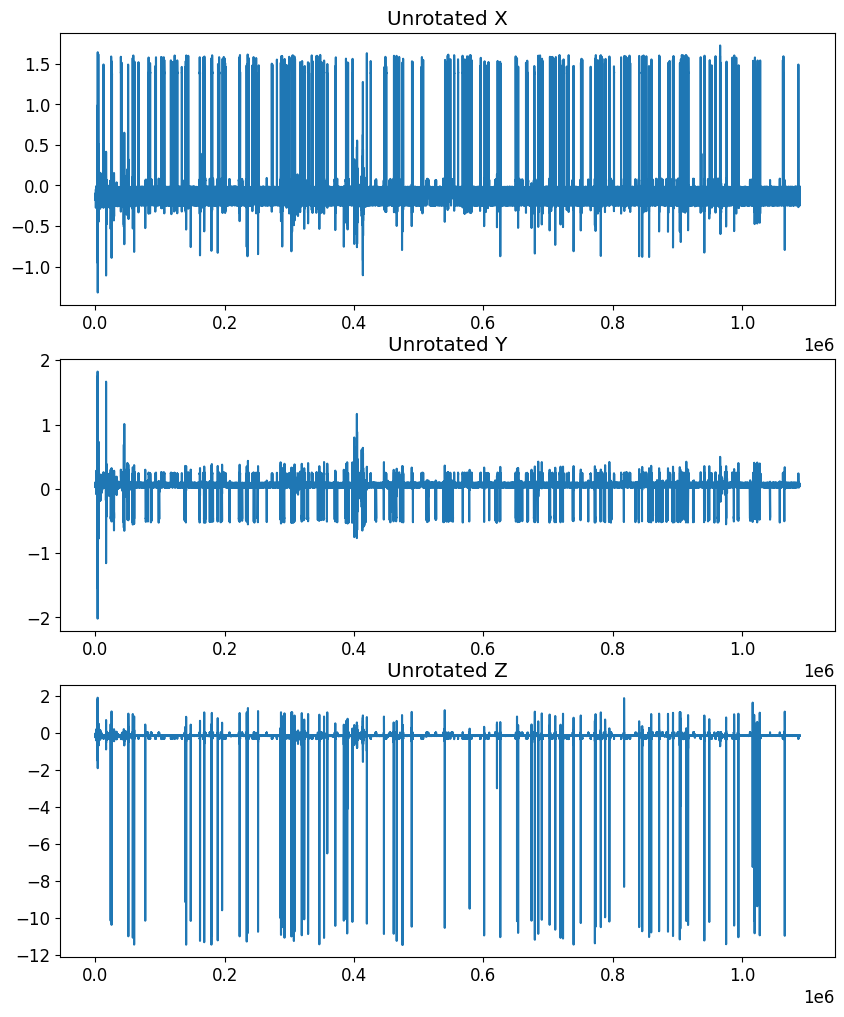

In [30]:
roof_xl_dat = pd.read_csv("roof_imu_data/xl1.csv")
roof_gy_dat = pd.read_csv("roof_imu_data/gy.csv")

roof_xl_dat.loc[:,"xl1.z"]-= 9.8

print(roof_xl_dat)

roof_xl_dat = roof_xl_dat.to_numpy()
roof_gy_dat = roof_gy_dat.to_numpy()

def unrotated_data(xl):
    fig, axes = plt.subplots(3, 1)
    fig.set_figwidth(10)
    fig.set_figheight(12)

    axes[0].plot(roof_xl_dat[:,2])
    axes[1].plot(roof_xl_dat[:,3])
    axes[2].plot(roof_xl_dat[:,4])

    axes[0].set_title("Unrotated X")
    axes[1].set_title("Unrotated Y")
    axes[2].set_title("Unrotated Z")

unrotated_data(roof_xl_dat)


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 9.99999976e-01  6.63378747e-05  1.94591674e-04  6.92988448e-05]
 [ 9.99999908e-01  1.46707191e-04  3.76903746e-04  1.41268165e-04]
 ...
 [-3.70427768e-01 -9.94510300e-02 -9.15463682e-01 -1.21733350e-01]
 [-3.70731048e-01 -9.94392036e-02 -9.15341485e-01 -1.21738656e-01]
 [-3.70519019e-01 -9.95726793e-02 -9.15388971e-01 -1.21917881e-01]]
1
(1089000, 3)
[[-1.26558654  0.54153362 -1.6202433 ]
 [-1.26641134  0.56029229 -1.61473884]
 [-1.24357688  0.6436463  -1.58267735]
 ...
 [ 1.47609855  0.1640476   0.83865155]
 [ 2.64061208 -0.17654943 -0.74501337]
 [ 1.29632185  0.20877972  1.05618913]]


array([[-1.26558654,  0.54153362, -1.6202433 ],
       [-1.26641134,  0.56029229, -1.61473884],
       [-1.24357688,  0.6436463 , -1.58267735],
       ...,
       [ 1.47609855,  0.1640476 ,  0.83865155],
       [ 2.64061208, -0.17654943, -0.74501337],
       [ 1.29632185,  0.20877972,  1.05618913]], shape=(1089000, 3))

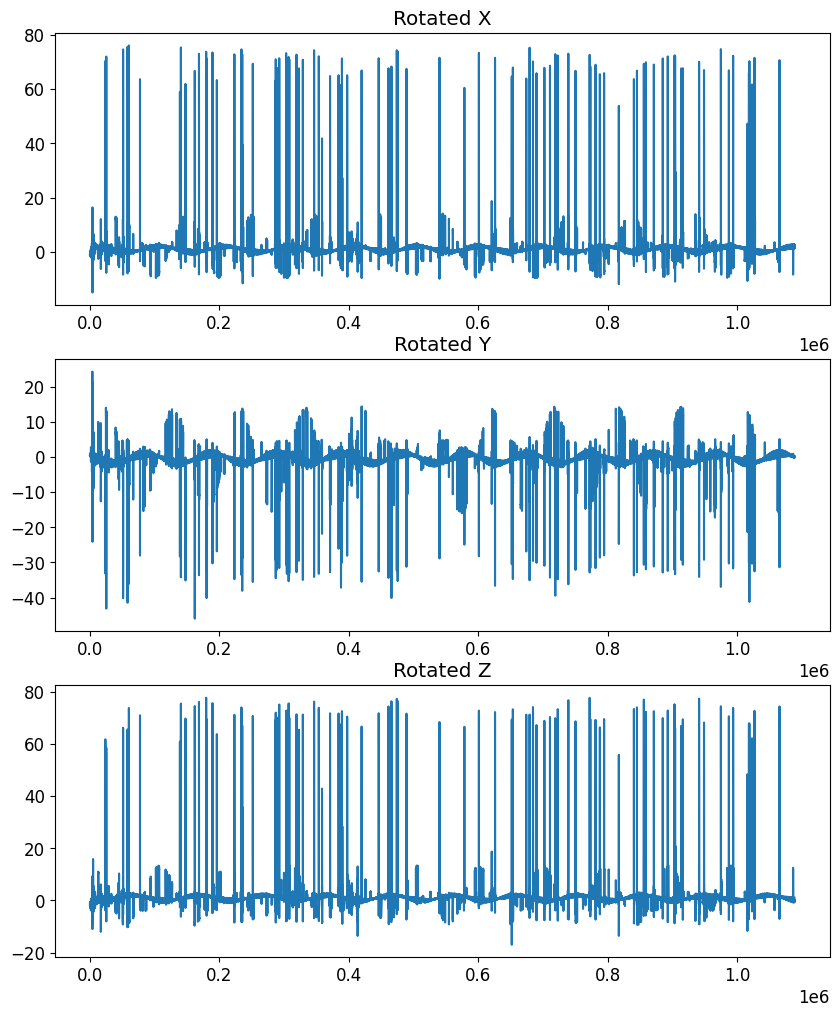

In [32]:
def rotated_data(roof_xl_d, roof_gy_d):

    prev_q = [1, 0, 0, 0]
    # interval_q = []
    roof_model = Madgwick(acc=roof_xl_d[:,2:], gyr=roof_gy_d[:,2:], dt=1/1000, q0 = prev_q)

    print(roof_model.Q)
    interval_q = roof_model.Q
    roof_data = roof_xl_d[:,2:]

    rotated_roof_data = []
    counter = 0
    for quart, item in zip(np.array(interval_q), roof_data):
        counter =+ 1
        item*=9.8
        mag = np.linalg.norm(item)
        norm_vec = item / mag
        ned_vec_1 = rotate_to_ned(quart, norm_vec, madg = True)
        ned_vec_1 *= mag
        rotated_roof_data.append(ned_vec_1)

    print(counter)
    # rotated_roof_data = np.vstack(rotated_roof_data)
    print(np.array(rotated_roof_data).shape)
    print(np.array(rotated_roof_data))

    rotated_roof_data = np.array(rotated_roof_data)

    fig, axes = plt.subplots(3, 1)
    fig.set_figwidth(10)
    fig.set_figheight(12)

    axes[0].plot(rotated_roof_data[:,0])
    axes[1].plot(rotated_roof_data[:,1])
    axes[2].plot(rotated_roof_data[:,2])

    axes[0].set_title("Rotated X")
    axes[1].set_title("Rotated Y")
    axes[2].set_title("Rotated Z")

    return rotated_roof_data

rotated_data(roof_xl_dat, roof_gy_dat)


1442557 Node[1].XL1.X
1442557 Node[1].XL1.timestamp
1442557 Node[1].XL1.interval_id
1442557 Node[1].XL1.Y
1442557 Node[1].XL1.Z
1503000 Node[1].GY1.X
1503000 Node[1].GY1.timestamp
1503000 Node[1].GY1.interval_id
1503000 Node[1].GY1.Y
1503000 Node[1].GY1.Z
30060 Node[1].MG1.X
30060 Node[1].MG1.timestamp
30060 Node[1].MG1.interval_id
30060 Node[1].MG1.Y
30060 Node[1].MG1.Z
30060 Node[1].MG2.X
30060 Node[1].MG2.timestamp
30060 Node[1].MG2.interval_id
30060 Node[1].MG2.Y
30060 Node[1].MG2.Z
1437796 Node[0].XL1.X
1437796 Node[0].XL1.timestamp
1437796 Node[0].XL1.interval_id
1437796 Node[0].XL1.Y
1437796 Node[0].XL1.Z
1502994 Node[0].GY1.X
1502994 Node[0].GY1.timestamp
1502994 Node[0].GY1.interval_id
1502994 Node[0].GY1.Y
1502994 Node[0].GY1.Z
30060 Node[0].MG1.X
30060 Node[0].MG1.timestamp
30060 Node[0].MG1.interval_id
30060 Node[0].MG1.Y
30060 Node[0].MG1.Z
30060 Node[0].MG2.X
30060 Node[0].MG2.timestamp
30060 Node[0].MG2.interval_id
30060 Node[0].MG2.Y
30060 Node[0].MG2.Z
1435741 Node[2].

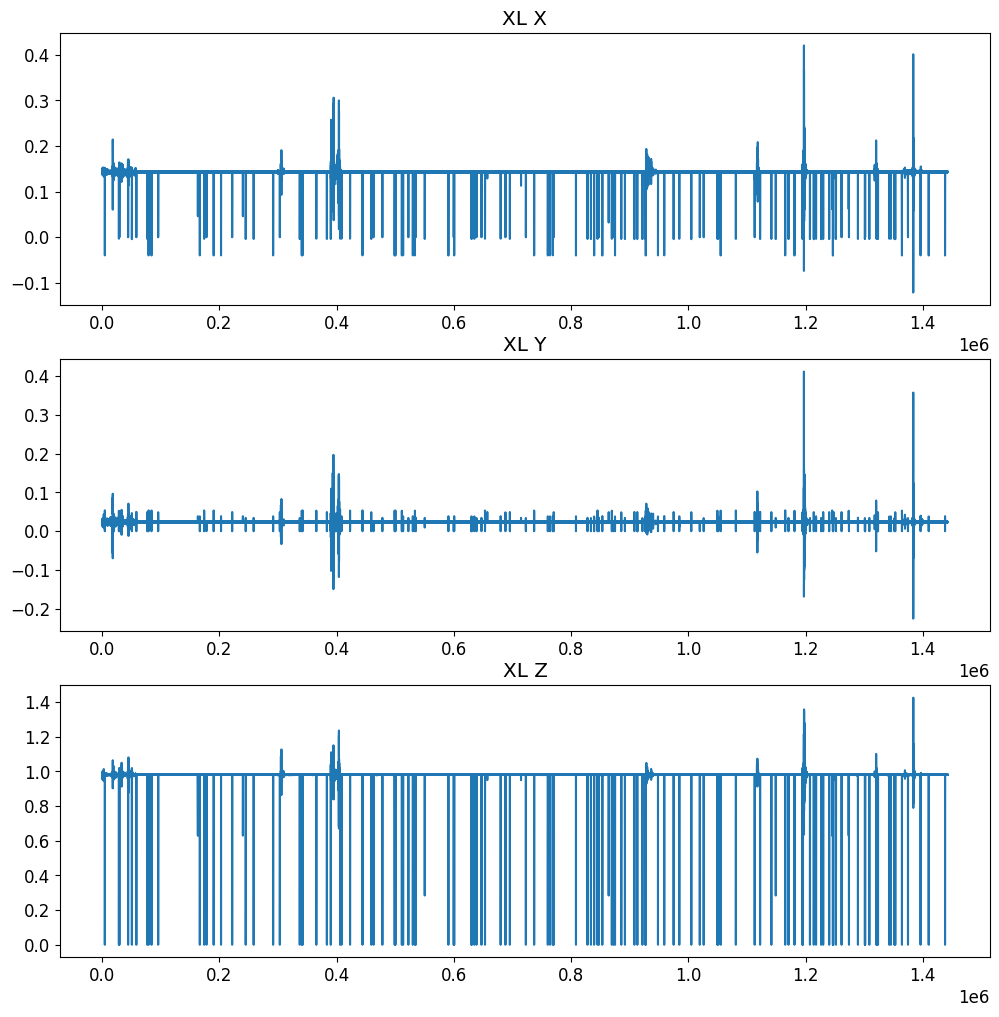

In [47]:
imu_gf = np.load("imu_data_raw.npz")
for key in imu_gf.files:
    print(len(imu_gf[key]), key)
 
imu_dic = {key: imu_gf[key] for key in imu_gf.files}

imu_arr = []
for key in imu_dic:
    imu_arr.append(imu_dic[key])

fig, axes = plt.subplots(3,1)
fig.set_figwidth(12)
fig.set_figheight(12)
axes[0].plot(imu_dic['Node[1].XL1.X'])
axes[1].plot(imu_dic['Node[1].XL1.Y'])
axes[2].plot(imu_dic['Node[1].XL1.Z'])
axes[0].set_title("XL X")
axes[1].set_title("XL Y")
axes[2].set_title("XL Z")

plt.show()

(1442557,) (1390076,) (1442557,) (1366449,) (1442557,) (1363710,)


Text(0.5, 1.0, 'XL Z')

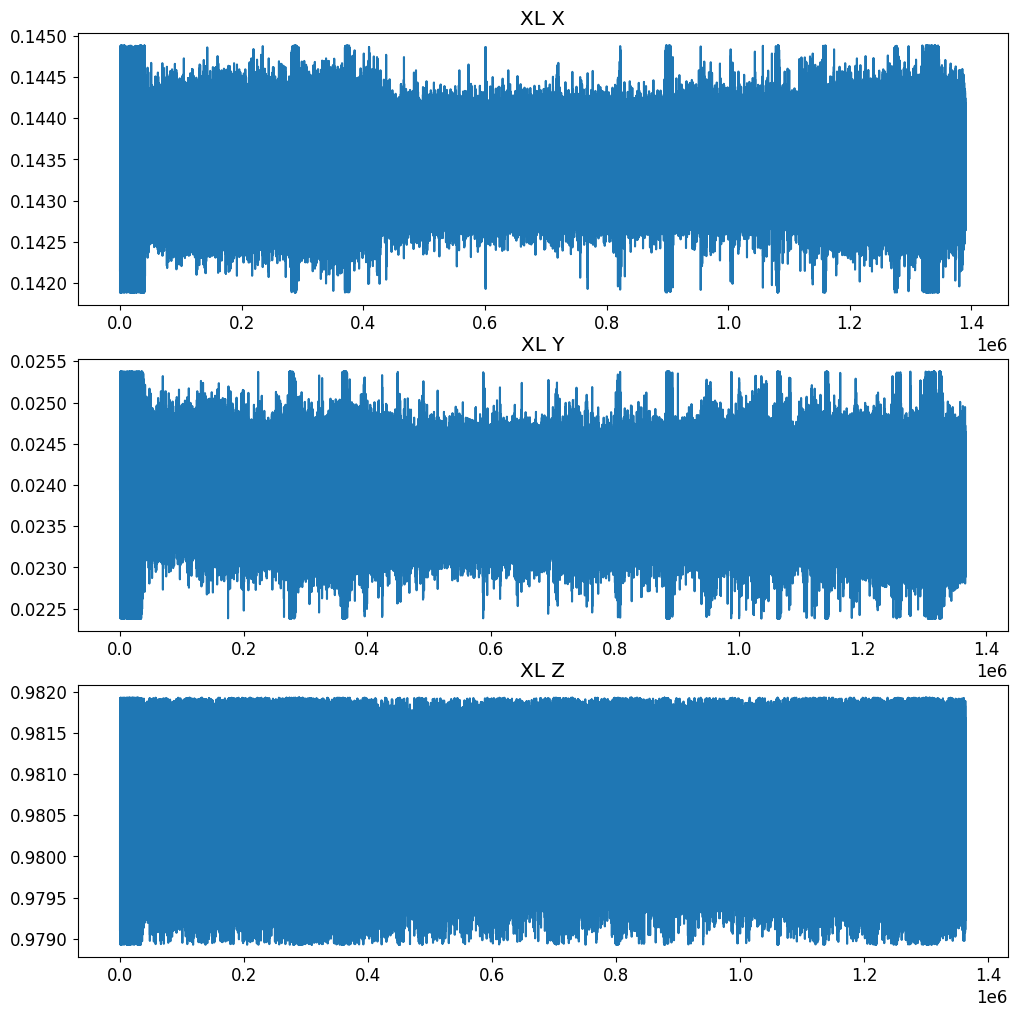

In [74]:
xl1x = imu_dic['Node[1].XL1.X']
xl1x_mean = np.mean(xl1x)
offset = 0.0015
mask_x = (xl1x < xl1x_mean + offset) & (xl1x > xl1x_mean - offset)
xlx_clip = xl1x[mask_x]
 
xly = imu_dic['Node[1].XL1.Y']
xly_mean = np.mean(xly)
offset = 0.0015
mask_y = (xly < xly_mean + offset) & (xly > xly_mean - offset)
xly_clip = xly[mask_y]
 
xlz = imu_dic['Node[1].XL1.Z']
xlz_mean = np.mean(xlz)
offset = 0.0015
mask_z = (xlz < xlz_mean + offset) & (xlz > xlz_mean - offset)
xlz_clip = xlz[mask_z]
 
print(imu_dic['Node[1].XL1.X'].shape, xlx_clip.shape, imu_dic['Node[1].XL1.Y'].shape, xly_clip.shape, imu_dic['Node[1].XL1.Z'].shape, xlz_clip.shape)

fig, axes = plt.subplots(3,1)
fig.set_figwidth(12)
fig.set_figheight(12)
axes[0].plot(xlx_clip)
axes[1].plot(xly_clip)
axes[2].plot(xlz_clip)
axes[0].set_title("XL X")
axes[1].set_title("XL Y")
axes[2].set_title("XL Z")

In [75]:
mask_combined = np.logical_and(mask_x, mask_y, mask_z)
timestamps = imu_dic["Node[1].XL1.timestamp"]
new_xl_ts = timestamps[mask_combined]

print(new_xl_ts.shape)
print(new_xl_ts)

print(mask_combined.shape)

# mask_x_filtered = np.where(mask_x)[0]
# mask_y_filtered = np.where(mask_y)[0]
# mask_z_filtered = np.where(mask_z)[0]
 
# xy_intersect = np.intersect1d(mask_x_filtered, mask_y_filtered)
# xyz_intersect = np.intersect1d(xy_intersect, mask_z_filtered)  

# timestamps = imu_dic["Node[1].XL1.timestamp"]
# new_xl_ts = timestamps[xyz_intersect]

# print(new_xl_ts.shape)

# print(xyz_intersect.shape)

(1348937,)
[77130870.0005 77130870.0015 77130870.0025 ... 77132372.9976 77132372.9986
 77132372.9996]
(1442557,)


(1503000,) (1499471,) (1503000,) (1496971,) (1503000,) (1499039,)


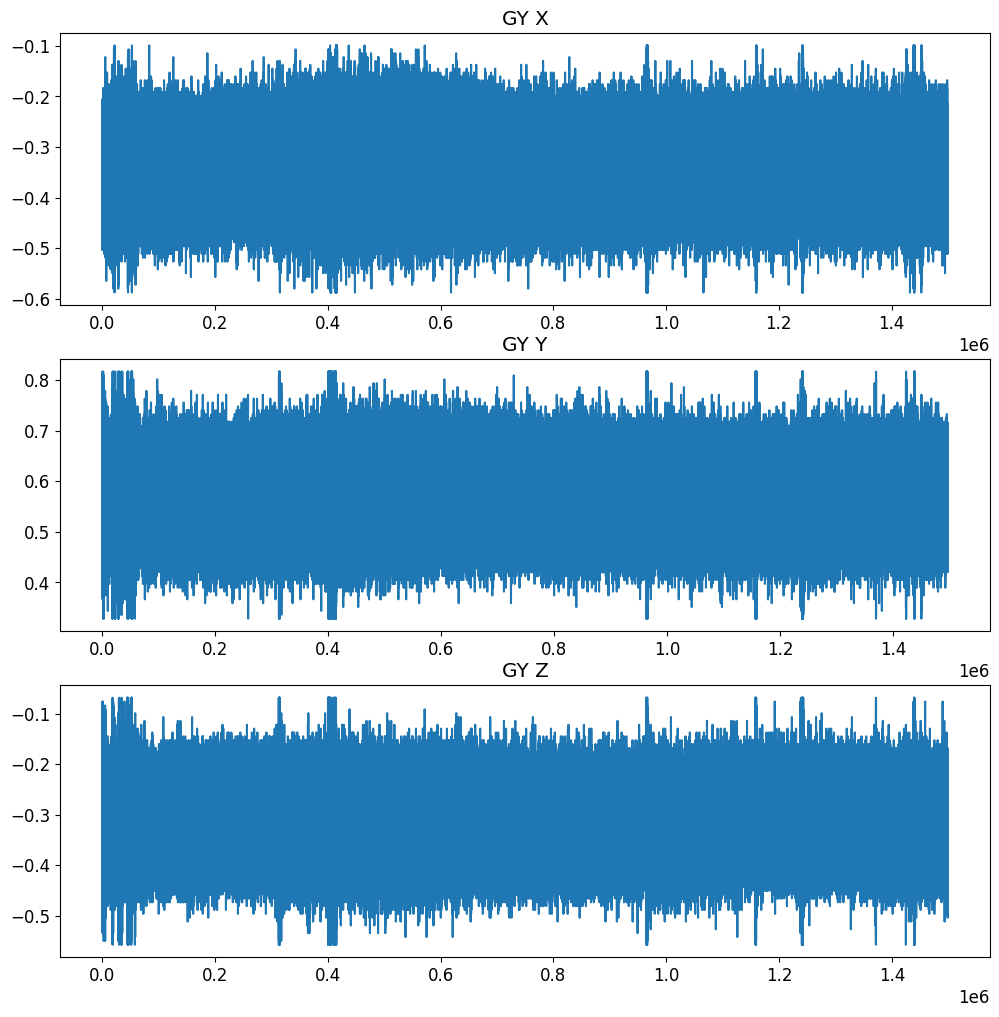

In [76]:
gy1x = imu_dic['Node[1].GY1.X']
gy1x_mean = np.mean(gy1x)
offset = 0.25
mask_x = (gy1x < gy1x_mean + offset) & (gy1x > gy1x_mean - offset)
gyx_clip = gy1x[mask_x]
 
gyy = imu_dic['Node[1].GY1.Y']
gyy_mean = np.mean(gyy)
offset = 0.25
mask_y = (gyy < gyy_mean + offset) & (gyy > gyy_mean - offset)
gyy_clip = gyy[mask_y]
 
gyz = imu_dic['Node[1].GY1.Z']
gyz_mean = np.mean(gyz)
offset = 0.25
mask_z = (gyz < gyz_mean + offset) & (gyz > gyz_mean - offset)
gyz_clip = gyz[mask_z]
 
print(imu_dic['Node[1].GY1.X'].shape, gyx_clip.shape, imu_dic['Node[1].GY1.Y'].shape, gyy_clip.shape, imu_dic['Node[1].GY1.Z'].shape, gyz_clip.shape)

fig, axes = plt.subplots(3,1)
fig.set_figwidth(12)
fig.set_figheight(12)
axes[0].plot(gyx_clip)
axes[1].plot(gyy_clip)
axes[2].plot(gyz_clip)
axes[0].set_title("GY X")
axes[1].set_title("GY Y")
axes[2].set_title("GY Z")
 
mask_combined_gy = np.logical_and(mask_x, mask_y, mask_z)
gy_timestamps = imu_dic["Node[1].GY1.timestamp"]
new_gy_ts = gy_timestamps[mask_combined_gy]



In [ ]:

def preprocess_sensor_updated(dat):
    """ 
    Sorts sensor data by timestamp and removes duplicates
    Params: 
        dat: sensor data 
    """
    dat = np.array(dat).astype(float)
    sorted_dat = dat[dat[:,0].argsort()]

    _, unique_indices = np.unique(sorted_dat[:,0], return_index = True)
    processed_data = sorted_dat[unique_indices]
    return processed_data

def clip_xl_updated(xl_dat, clip):
    """
    XL sensors above certain thresholds are defective
    """
    xl_clipped = np.where(xl_dat > clip, clip, xl_dat)
    xl_clipped = np.where(xl_clipped < -1*clip, -1*clip, xl_clipped)
    return xl_clipped

def preprocess_imu_updated(xl_raw, gyr_raw, gyr_offset):
    """
    correct units, remove gyr offset
    Returns:
        data_matrix: (xl, mag, gyr)
    """

    xl = xl_raw * 9.810665
    gyr = gyr_offset_radians(gyr_raw, gyr_offset)
    return xl, gyr

def gyr_offset_radians_updated(gyr_dat, offset):
    """Put gy data in radians, remove measured error """
    gyr_off = gyr_dat - offset
    gyro_rad = gyr_off * ( np.pi / 180)
    return gyro_rad

def time_align_updated(xyz, sensor_odr, interval_odr):
    """ 
    Upsample data 2x interval odr(fourier signal), decimate data back down(lowpass filter), interpolate to desired odr, select current interval points
    """
    xyz_w = []
    len_w = []
    for i, ts in enumerate(xyz):
        xyz_w.append(ts)
        len_w.append(len(ts))

    xyz_w = np.vstack(xyz_w)
    # if name == 'xl':
        # print('raw',xyz_w.shape)

    xyz_r = resample(xyz_w, num=(sensor_odr*3)*2, axis=0)
    factor = xyz_r.shape[0]//((sensor_odr*3))
    xyz_d = decimate(xyz_r, q=factor, axis=0)

    current_points = xyz_d[interval_odr:interval_odr*2]
    
    # print('final', np.array(current_points).shape)
    return np.array(current_points)

def normalize_updated(q): 
    #norm = np.sqrt(q @ q.T)
    norm = magnitude_updated(q)
    return q/norm 

def quatConjugate_updated(q):
        w,x,y,z = q
        q_star = np.array([w,-x,-y,-z])
        return q_star
        
def quatProduct_updated(q, p):
        q = np.array(q)
        p = np.array(p)
        w, x, y, z = list(q)

        q_matrix = np.array([
            [w, -x, -y, -z],
            [x, w, -z, y],
            [y, z, w, -x],
            [z, -y, x, w]
        ])
        return q_matrix @ p

def inverse_updated(q):
    q_star = quatConjugate_updated(q)
    mag = magnitude_updated(q)
    if  0.998 < mag < 1.001:
        return q_star
    else:
        q_inverse = q_star / mag**2
        return q_inverse
    
def magnitude_updated(q):
    return np.sqrt(q[0]**2 + q[1]**2 + q[2]**2 + q[3]**2)

def rotate_vector_updated(q, v, active=True):
    v = np.insert(np.array(v), 0, 0)  # convert to pure quaternion
    q_inv = inverse_updated(q)

    if active: # object rotation
        q_product = quatProduct_updated(q, v)
        q_rot = quatProduct_updated(q_product, q_inv)
    else: # coordinate rotation
        q_product = quatProduct_updated(q_inv, v)
        q_rot = quatProduct_updated(q_product, q)

    return q_rot[1:]

def R_updated(q_w, q_x, q_y, q_z):
    """
    Direction Cosine Matrix to rotate between two frames
    """
    # rotation_matrix = np.array([
    #     [q_w**2+q_x**2-q_y**2-q_z**2, 2*(q_x*q_y-q_w*q_z), 2*(q_x*q_z+q_w*q_y)],
    #     [2*(q_x*q_y+q_w*q_z), q_w**2-q_x**2+q_y**2-q_z**2, 2*(q_y*q_z-q_w*q_x)],
    #     [2*(q_x*q_z-q_w*q_y), 2*(q_w*q_x+q_y*q_z), q_w**2-q_x**2-q_y**2+q_z**2]
    # ])
            
    rotation_matrix = np.array([
        [1.0-2.0*(q_y**2+q_z**2), 2.0*(q_x*q_y-q_w*q_z), 2.0*(q_x*q_z+q_w*q_y)],
        [2.0*(q_x*q_y+q_w*q_z), 1.0-2.0*(q_x**2+q_z**2), 2.0*(q_y*q_z-q_w*q_x)],
        [2.0*(q_x*q_z-q_w*q_y), 2.0*(q_w*q_x+q_y*q_z), 1.0-2.0*(q_x**2+q_y**2)]
        ])
    return rotation_matrix

def rotate_to_ned_updated(q,vec):
    """
    rotates raw data by quaternion into global frame
    """
    rotation_matrix = R_updated(*q)
    global_estimate = rotation_matrix.T @ vec  #eq. 10 
    
    return global_estimate


def align_timestamps(xl, gy, interval_odr, gyr_offset):
    cols =['interval', 'timestamp','x', 'y', 'z']
    xl_df = pd.DataFrame(xl, columns=cols)
    xl_df.astype({'x': float, 'y': float, 'z': float, 'timestamp':float})
    xl_group = xl_df.groupby('interval')
 
    gy_df = pd.DataFrame(gy, columns=cols)
    gy_df.astype({'x': float, 'y': float, 'z': float, 'timestamp':float})
    gy_group = gy_df.groupby('interval')
 
    xl_global = []
    prev_q = [1,0,0,0]
 
    xl_w = [] #(3, n, 3) history of 3, n data , xyz
    gy_w = []
 
    for (name1, xl_grp), (name2, gy_grp) in zip(xl_group, gy_group):
       
        if name1 != name2:
            continue
 
        group_ts = [xl_grp.iloc[xl_grp.shape[0]//2]['timestamp'] for _ in range(interval_odr)]
        # group_interval = [xl_grp.iloc[xl_grp.shape[0]//2]['interval'] for _ in range(interval_odr)]

        print(xl_grp.shape, gy_grp.shape)

        xl_1 = preprocess_sensor_updated(xl_grp.drop(columns=['interval']).values)
        xl1_clipped = clip_xl(xl_1[:,1:], 2)
 
        gy_1 = preprocess_sensor_updated(gy_grp.drop(columns=['interval']).values) #remove unique values
        xl_p, gy_p = preprocess_imu_updated(xl1_clipped, gy_1[:,1:], gyr_offset)

        diff = np.unique
        print(xl1_clipped.shape, gy_1.shape)

        xl_w.append(xl_p)
        gy_w.append(gy_p)
 
        if len(xl_w) > 3:
            xl_w.pop(0)
            gy_w.pop(0)
 
        if len(xl_w) != 3:
            continue
 
        xl_t = time_align_updated(xl_w, 1000, interval_odr)
        gy_t = time_align_updated(gy_w, 1000, interval_odr)
 
        model = Madgwick(acc=xl_t, gyr=gy_t, dt=1/interval_odr, q0 = prev_q)
       
        prev_q = model.Q[-1]
        interval_q = model.Q
 
        group_xl_ned = []
        for q,x in zip(np.array(interval_q), xl_t):
            mag = np.linalg.norm(x)
            norm_vec = x / mag
            ned_vec_1 = rotate_to_ned_updated(q, norm_vec)
            vec1 = np.round(ned_vec_1,4)
 
            # q = normalize(q)
            # ned_vec_2 = rotate_vector(q, norm_vec, active=False)
            # vec2 = np.round(ned_vec_2,4)
 
            # assert np.allclose(vec1, vec2) , f"Not equal vec1: {vec1}, vec2: {vec2}"
            assert np.issubdtype(ned_vec_1.dtype, np.floating)
            vec1 *= mag
            vec1[2] -= 9.810665
            group_xl_ned.append(vec1)
       
        assert np.issubdtype(np.array(group_xl_ned).dtype, np.floating)
        group_xl_ned = np.column_stack([group_xl_ned, group_ts])
        xl_global.extend(group_xl_ned)
 
    return np.array(xl_global)

In [102]:
xl_stack = np.array([imu_dic['Node[1].XL1.interval_id'][mask_combined],imu_dic['Node[1].XL1.timestamp'][mask_combined], 
            imu_dic['Node[1].XL1.X'][mask_combined],imu_dic['Node[1].XL1.Y'][mask_combined],
              imu_dic['Node[1].XL1.Z'][mask_combined]])

gy_stack = np.array([imu_dic['Node[1].GY1.interval_id'][mask_combined_gy],imu_dic['Node[1].GY1.timestamp'][mask_combined_gy], 
            imu_dic['Node[1].GY1.X'][mask_combined_gy],
            imu_dic['Node[1].GY1.Y'][mask_combined_gy], imu_dic['Node[1].GY1.Z'][mask_combined_gy]])

offset = np.array([.58, .42, -.3])
xl_global = align_timestamps(xl_stack.T, gy_stack.T, 1000, offset)

(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(623, 5) (1000, 5)
(623, 3) (1000, 4)
(252, 5) (996, 5)
(252, 3) (996, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(999, 5) (1000, 5)
(999, 3) (1000, 4)
(832, 5) (1000, 5)
(832, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(780, 5) (1000, 5)
(780, 3) (1000, 4)
(455, 5) (1000, 5)
(455, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (1000, 5)
(1000, 3) (1000, 4)
(1000, 5) (100

In [93]:
xl_global = xl_global.astype(float)
print(xl_global.shape)
print(xl_global)

(835000, 4)
[[ 1.39471136e+00  2.35333528e-01 -3.09914281e-01  7.71308704e+07]
 [ 1.40064986e+00  2.31520313e-01 -3.09686193e-01  7.71308704e+07]
 [ 1.40558753e+00  2.28660173e-01 -3.08777985e-01  7.71308704e+07]
 ...
 [ 1.17389295e+00  1.61903008e+00 -4.07022973e-01  7.71312395e+07]
 [ 1.17430360e+00  1.62691980e+00 -4.12392350e-01  7.71312395e+07]
 [ 1.16677104e+00  1.62366820e+00 -4.01469327e-01  7.71312395e+07]]


397
[0.06446078 0.06446141 0.06446159 0.06446166 0.0644617  0.06446172
 0.06446173 0.06446174 0.06446175 0.06446175]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[0.004089706906245467, 0.004218512437551903, 0.004153398343649964, 0.004098601732466537, 0.004164610896442339, 0.004148526235259729, 0.004174877771468201, 0.004182400995278065, 0.00413066640366178, 0.004204528531537515, 0.00417840038526284, 0.004116913765795117, 0.004147377549231395, 0.004203254269937907, 0.004120527677749653, 0.004135146305465136, 0.004173654069782271, 0.004107826869249715, 0.004238750703868981, 0.004202356768705617, 0.004108782051892776, 0.004174061658472113, 0.0041267760212183565, 0.004200655314007708, 0.004137847193259889, 0.004151472830595438, 0.004148652964134929, 0.004120239662038315, 0.004187407067013954, 0.004110622573648219, 0.0041547638869948575, 0.0041509312206907956, 0.004091207921694497, 0.004251862331481784, 0.0040563421249167975, 0.00420079639462367, 0.004155284344265532, 0.004112000486

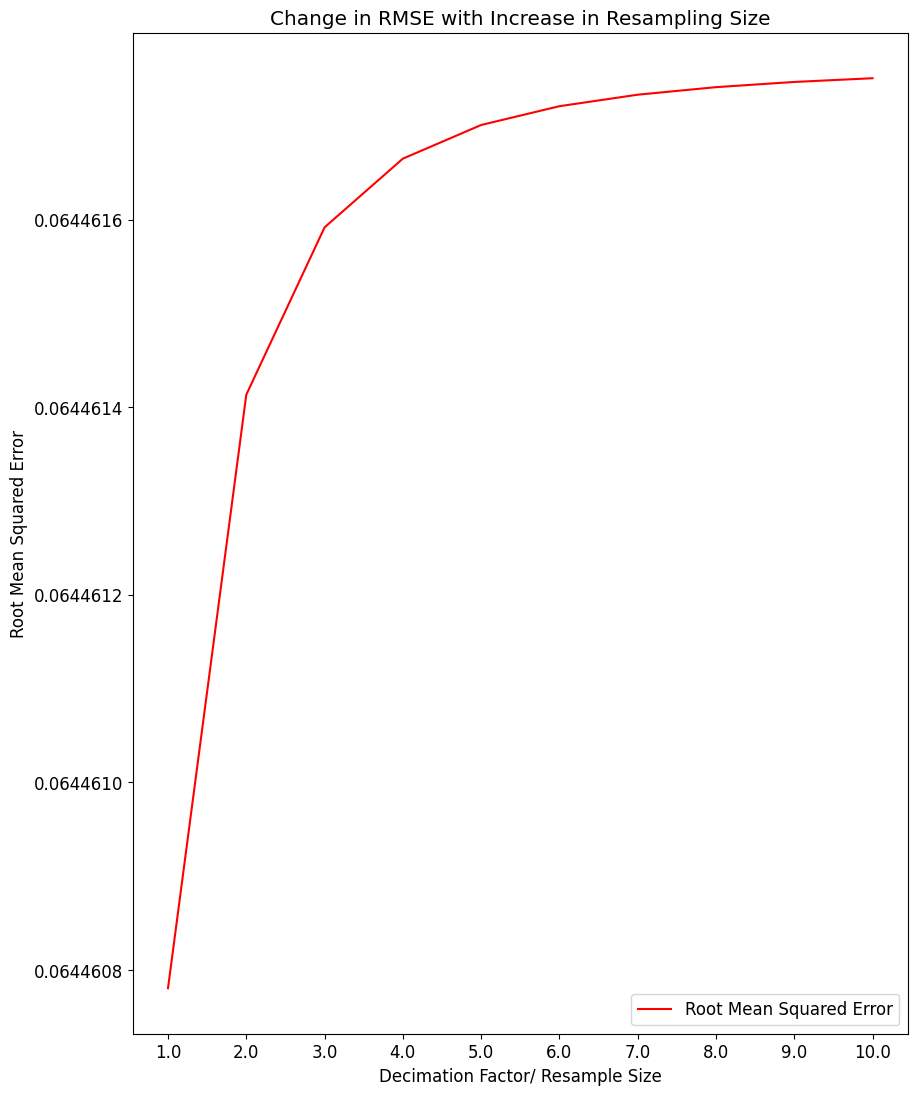

In [ ]:
cols =['interval','timestamp','x', 'y', 'z']
xl_df = pd.DataFrame(xl_stack.T, columns=cols)
# mg_df = pd.DataFrame(mg_dat, columns=cols)
gy_df = pd.DataFrame(gy_stack.T, columns=cols)

xl_group = xl_df.groupby('interval')
# mg_group = mg_df.groupby('interval')
gy_group = gy_df.groupby('interval')

resample_sizes = []
mean_squared_list = []
decimate_sizes = []

total_interval_vals =[] # a list of lists of all MSE values per decimation factor

for i in range(1, 11, 1):
    xl_global = []
    xl_w = []
    counter = 0
    total_mse = 0
    check = False
    interval_vals = [] # a list of all MSE values per decimation factor
    for (name, xl_grp), (name, mg_grp), (name, gy_grp) in zip(xl_group, mg_group, gy_group):
        xl_required = correct_data(xl_grp.drop(columns=['interval']).values)
        xl_required = clip_xl(xl_required[:,1:], 2)
        xl_test = xl_required * 9.810665  # ground truth data 

        xl_w.append(xl_test)

        if len(xl_w) > 3: #build window  
            xl_w.pop(0)
    
        if len(xl_w) != 3:
            continue

        new_xl_w = [] # to unpack all 3 intervals for the window
        len_w = []
        for j, itvl in enumerate(xl_w):
            new_xl_w.append(itvl)
            len_w.append(len(itvl)) 
        
        new_xl_w = np.vstack(new_xl_w)

        if (new_xl_w.shape[0] == 3000):
            check = True
            xl_simulate = new_xl_w[1000:2000,:]

            xl_missing = keep_every_k_of_n(xl_simulate, 400, 500) # removes 200 data points for each 1000 point interval
            xl_to_use = np.vstack([new_xl_w[0:1000], xl_missing, new_xl_w[2000:3000]])

            xl_r = resample(xl_to_use, num = 1200*i, axis = 0)
            factor = xl_r.shape[0]/1200
            # factor = round(factor, 2)
            factor_rounded = int(xl_r.shape[0]/1200) # this ensures that data is always downsampled to 1200
            xl_d = decimate(xl_r, q = factor_rounded, axis = 0)  

            interval_mse = mean_squared_error(np.array(xl_d[100:1100]), new_xl_w[1000:2000,:])
            counter += 1
            total_mse += interval_mse
            
            interval_vals.append(interval_mse)

    if len(xl_w) != 3:
        continue

    if (check == True):
        average_mse = total_mse / counter
        resample_sizes.append(1200*i)
        decimate_sizes.append(factor)

        mean_squared_list.append(average_mse)

        total_interval_vals.append(interval_vals)

root_mean_squared_list = np.sqrt(mean_squared_list)
print(root_mean_squared_list)
print(decimate_sizes)
print(total_interval_vals)
print(np.array(total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
# ax_t = ax1.twinx()
ax1.plot(decimate_sizes, root_mean_squared_list, label = "Root Mean Squared Error", c= 'red')
# ax_t.plot(decimate_sizes, root_mean_squared_list, label = "Mean Absolute Error", c="red")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xticks(decimate_sizes, labels=list(decimate_sizes))
# ax1.set_yticks(resample_sizes, labels=list(resample_sizes))
ax1.set_xlabel("Decimation Factor/ Resample Size")
ax1.set_ylabel("Root Mean Squared Error")
ax1.set_title("Change in RMSE with Increase in Resampling Size")
ax1.legend(loc = "lower right")
# ax_t.legend()
plt.show()

Total Variance of RMSE for Accelerometer
8.148967396594709e-14
---------------------------
Individual RMSE Standard Deviation List
[np.float64(3.8045634219762434e-05), np.float64(3.804391600248196e-05), np.float64(3.804384530347211e-05), np.float64(3.804383162489132e-05), np.float64(3.8043827379390696e-05), np.float64(3.804382567482036e-05), np.float64(3.804382486223936e-05), np.float64(3.8043824424242674e-05), np.float64(3.804382416537402e-05), np.float64(3.8043824001249315e-05)]
---------------------------


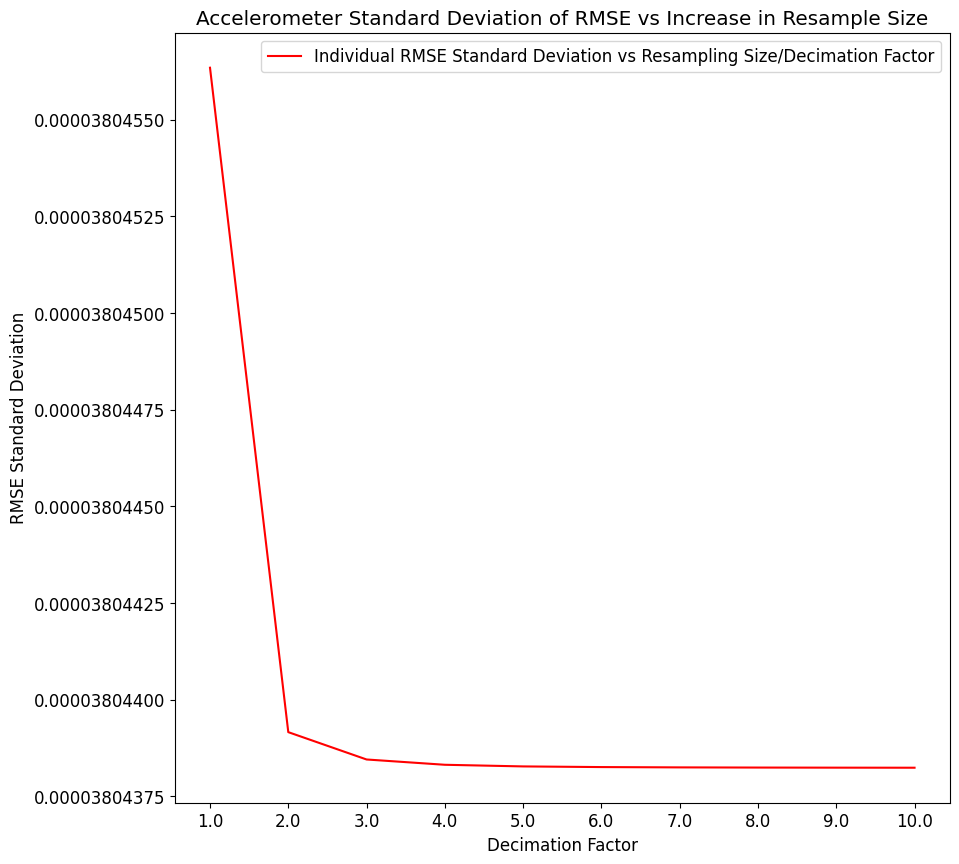

In [100]:
mse_variance_xl = np.var(root_mean_squared_list)
print("Total Variance of RMSE for Accelerometer")
print(mse_variance_xl)
print("---------------------------")

#  Calculating Individual RMSE Variance/Standard Deviation for Accelerometer
variance_list = []
for interval in total_interval_vals:
    interval_var = np.std(interval)
    variance_list.append(interval_var)

print("Individual RMSE Standard Deviation List")
print(variance_list)
print("---------------------------")
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(10)
# ax_t = ax1.twinx()
ax1.plot(decimate_sizes, variance_list, label="Individual RMSE Standard Deviation vs Resampling Size/Decimation Factor", c="red")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xticks(decimate_sizes, labels=list(decimate_sizes))
# ax1.set_yticks(resample_sizes, labels=list(resample_sizes))
ax1.set_xlabel("Decimation Factor")
ax1.set_ylabel("RMSE Standard Deviation")
ax1.set_title("Accelerometer Standard Deviation of RMSE vs Increase in Resample Size")
plt.legend()
plt.show()

874
874
874
874
874
874
874
874
874
874
[0.00122659 0.0012276  0.00122765 0.00122767 0.00122768 0.00122768
 0.00122768 0.00122769 0.00122769 0.00122769]
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
[[1.6501762899191916e-06, 1.484002333209053e-06, 1.3963279115584478e-06, 1.8374864072259294e-06, 1.4684023032796161e-06, 1.2916430202859628e-06, 1.723647318635833e-06, 1.5761654095561947e-06, 1.430706142616141e-06, 1.2716730365883752e-06, 1.3377603566872352e-06, 1.3358523953796615e-06, 1.5225624829362938e-06, 1.4625618398678993e-06, 1.2367227799026605e-06, 1.2240506848990574e-06, 1.4478811570830961e-06, 1.5241557669710856e-06, 1.398135405418141e-06, 1.7391957515816422e-06, 1.454531084269718e-06, 1.4165373099877645e-06, 1.546528129142869e-06, 1.4633866108519885e-06, 1.4689978344389511e-06, 1.5580407623905633e-06, 1.3826903523857221e-06, 1.7303217888657018e-06, 1.839495847965298e-06, 1.5080515721738689e-06, 1.4033601282036144e-06, 1.638763126483425e-06, 1.3687774278259377e-06, 1.3694236

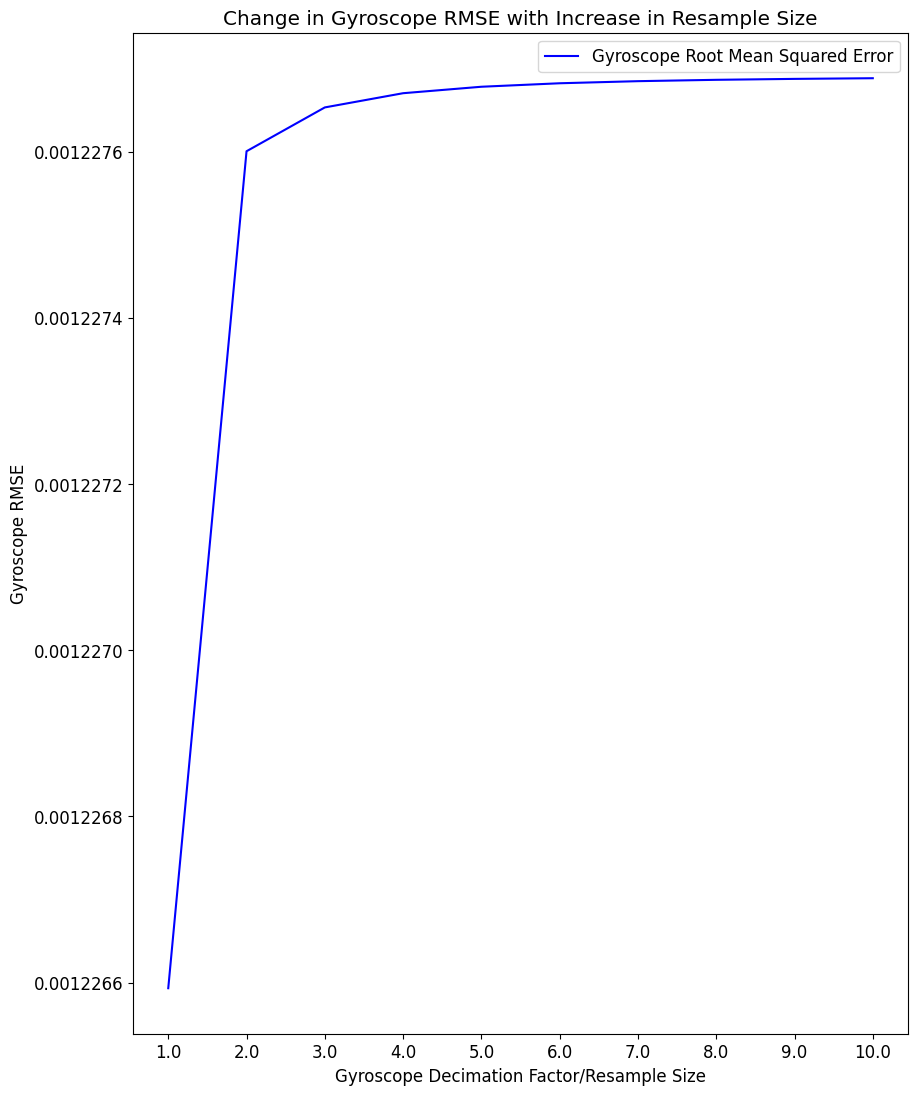

In [104]:
# Resampling and Decimating Gyroscope Data

plt.rcParams.update({'font.size': 12})
gy_resample_sizes = []
gy_mean_squared_list = []
gy_decimate_sizes = []

gy_total_interval_vals = [] # a list of lists of all MSE values per decimation factor
for i in range(1, 11, 1):
    gy_global = []
    gy_w = []
    gy_counter = 0
    gy_total_mse = 0
    gy_check = False
    gy_interval_vals = [] # a list of all MSE values for per decimation factor
    for (name, xl_grp), (name2, mg_grp), (name3, gy_grp) in zip(xl_group, mg_group, gy_group):
        gy_required = correct_data(gy_grp.drop(columns=['interval']).values)
        gy_test = gyr_offset_radians(gy_required[:,1:], np.array([.58, .42, -.3]))

        gy_w.append(gy_test)

        if len(gy_w) > 3: #build window  
            gy_w.pop(0)
  
        if len(gy_w) != 3:
            continue

        new_gy_w = [] # to unpack all 3 intervals for the window
        gy_len_w = []
        for gy_j, gy_itvl in enumerate(gy_w):
            new_gy_w.append(gy_itvl)
            gy_len_w.append(len(gy_itvl)) 
        
        new_gy_w = np.vstack(new_gy_w)

        if (new_gy_w.shape[0] == 3000):
            gy_check = True
            gy_simulate = new_gy_w[1000:2000]

            gy_missing = keep_every_k_of_n(gy_simulate, 400, 500) # removes 200 data points for each 1000 point interval
            gy_to_use = np.vstack([new_gy_w[0:1000], gy_missing, new_gy_w[2000:3000]])

            gy_r = resample(gy_to_use, num = 3000*i, axis = 0)
            gy_factor = gy_r.shape[0]/3000
            gy_factor = round(gy_factor, 2)
            gy_factor_rounded = int(gy_r.shape[0]/3000) # this ensures that data is always downsampled to 3000
            gy_d = decimate(gy_r, q = gy_factor_rounded, axis = 0)  

            gy_interval_mse = mean_squared_error( new_gy_w[1000:2000,:], np.array(gy_d[1000:2000]))
            gy_counter += 1
            gy_total_mse += gy_interval_mse
            
            gy_interval_vals.append(gy_interval_mse)

    if len(gy_w) != 3:
        continue

    if (gy_check == True):
        print(gy_counter)
        gy_total_interval_vals.append(gy_interval_vals)
        gy_average_mse = gy_total_mse / gy_counter
        gy_resample_sizes.append(3000*i)
        gy_decimate_sizes.append(gy_factor)

        gy_mean_squared_list.append(gy_average_mse)

gy_root_mean_squared_list = np.sqrt(gy_mean_squared_list)
print(gy_root_mean_squared_list)
print(gy_decimate_sizes)

print(gy_total_interval_vals)
print(np.array(gy_total_interval_vals).shape)

plt.rcParams.update({'font.size': 12})
fig, ax1 = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(13)
# ax_t = ax1.twinx()
ax1.plot(gy_decimate_sizes, gy_root_mean_squared_list, label = "Gyroscope Root Mean Squared Error", c = "blue")
# ax_t.plot(gy_decimate_sizes, gy_mean_squared_list, label="Gyroscope Mean Absolute Error", c="brown")
formatter = ScalarFormatter(useOffset=False)
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xticks(gy_decimate_sizes, labels=list(gy_decimate_sizes))
# ax1.set_yticks(gy_resample_sizes, labels=list(gy_resample_sizes))
ax1.set_xlabel("Gyroscope Decimation Factor/Resample Size")
ax1.set_ylabel("Gyroscope RMSE")
ax1.legend(loc = "lower right")
ax1.set_title("Change in Gyroscope RMSE with Increase in Resample Size")
ax_t.legend()
plt.legend()
plt.show()

0.1275801729185443
0.1275801729185443
PCA for the raw xl1 Dataset


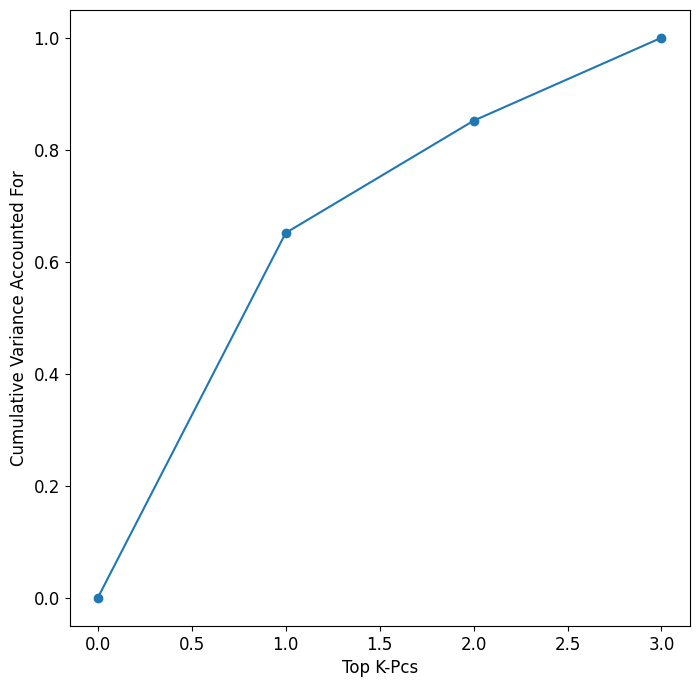

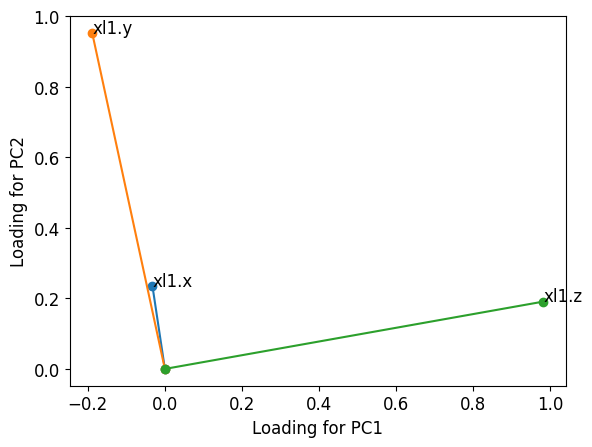

0.22885135489765626
0.22885135489765626
PCA for the Gyroscope Dataset


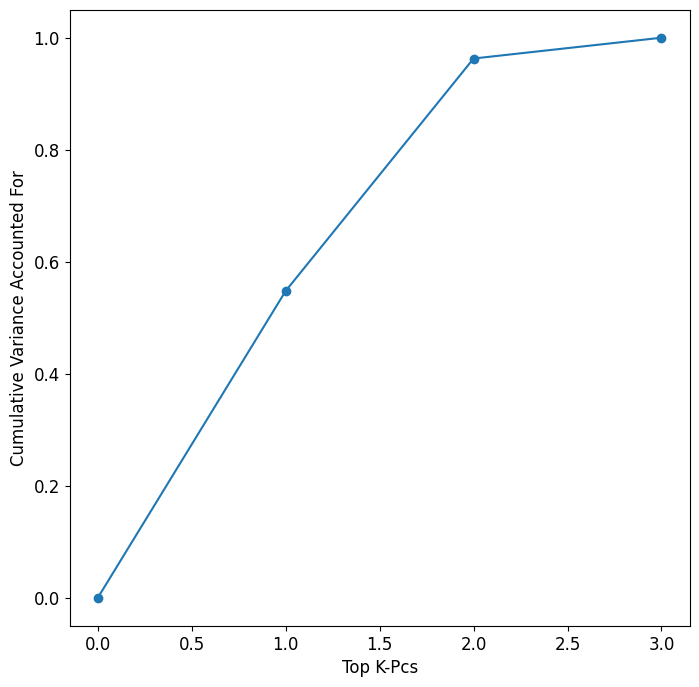

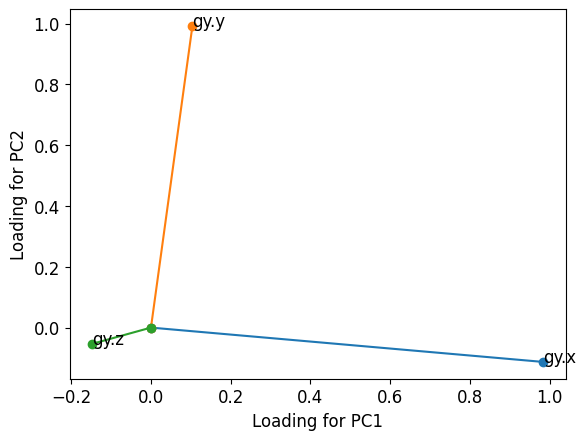

        timestamp                           interval_id  Node[1].LLH.Lat  \
0      46757787.0  19a20625-a974-468e-9487-2400b055d571        32.756010   
1      46757787.2  19a20625-a974-468e-9487-2400b055d571        32.755998   
2      46757787.4  19a20625-a974-468e-9487-2400b055d571        32.755986   
3      46757787.6  19a20625-a974-468e-9487-2400b055d571        32.755974   
4      46757787.8  19a20625-a974-468e-9487-2400b055d571        32.755962   
...           ...                                   ...              ...   
17605  46761384.0  738039cf-45a0-48ca-9966-11ca045b681d        32.605854   
17606  46761384.2  738039cf-45a0-48ca-9966-11ca045b681d        32.605853   
17607  46761384.4  738039cf-45a0-48ca-9966-11ca045b681d        32.605851   
17608  46761384.6  738039cf-45a0-48ca-9966-11ca045b681d        32.605850   
17609  46761384.8  738039cf-45a0-48ca-9966-11ca045b681d        32.605848   

       Node[1].LLH.Lon  Node[1].LLH.Height  Node[1].LLH.HeightMSL  \
0           -79.86

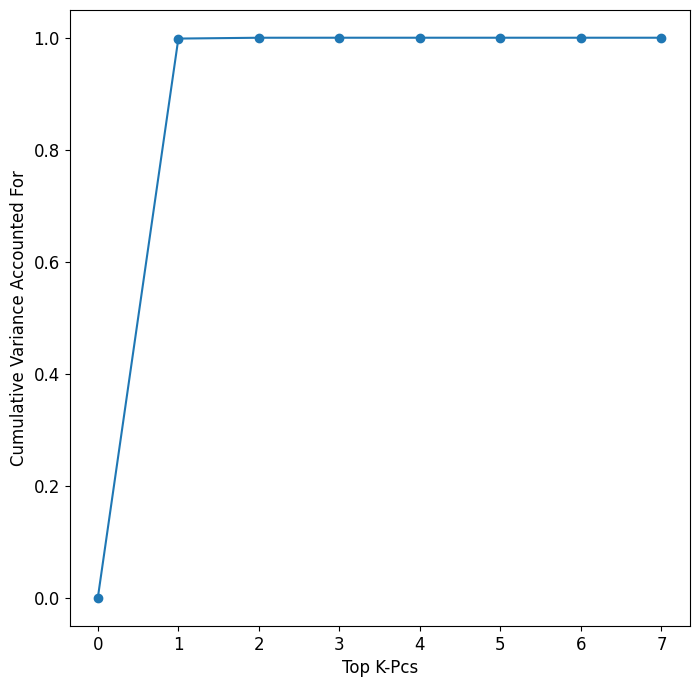

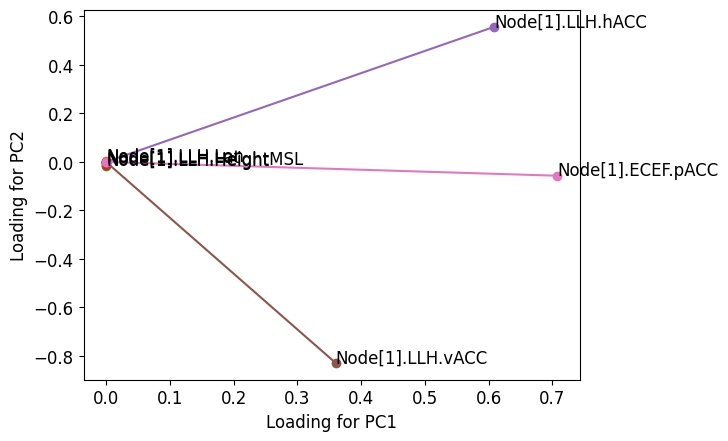

In [21]:
# Implementing PCA on xl1_ned and xl1_dat

xl_pca = pca.PCA(xl1)
xl_pca.fit(["xl1.x", "xl1.y", "xl1.z"])
xl_pca.elbow_plot()

print("PCA for the raw xl1 Dataset")

plt.subplots()
xl_pca.loading_plot()
plt.show()

gy_pca = pca.PCA(gy)
gy_pca.fit(["gy.x", "gy.y", "gy.z"])
gy_pca.elbow_plot()

print("PCA for the Gyroscope Dataset")

plt.subplots()
gy_pca.loading_plot()
plt.show()


gps_gf = np.load("gps_data.npy")
gps_df = pd.DataFrame(gps_gf[1:,:], columns=gps_gf[0,:])
cols_to_convert = gps_df.columns[gps_df.columns != 'interval_id']
gps_df[cols_to_convert] = gps_df[cols_to_convert].apply(pd.to_numeric, errors='coerce') 

gps_pca = pca.PCA(gps_df)
print(gps_df)
column_list = list(gps_df.columns)
print(column_list)
gps_first_node = column_list[2:9] + column_list[12:15]
gps_first_node = gps_first_node[:6] + [gps_first_node[7]]
print(gps_first_node)
gps_pca.fit(gps_first_node)
gps_pca.elbow_plot()

print("PCA for the GPS Dataset")

plt.subplots()
gps_pca.loading_plot()
plt.show()

(99800, 3)
(99800, 3)


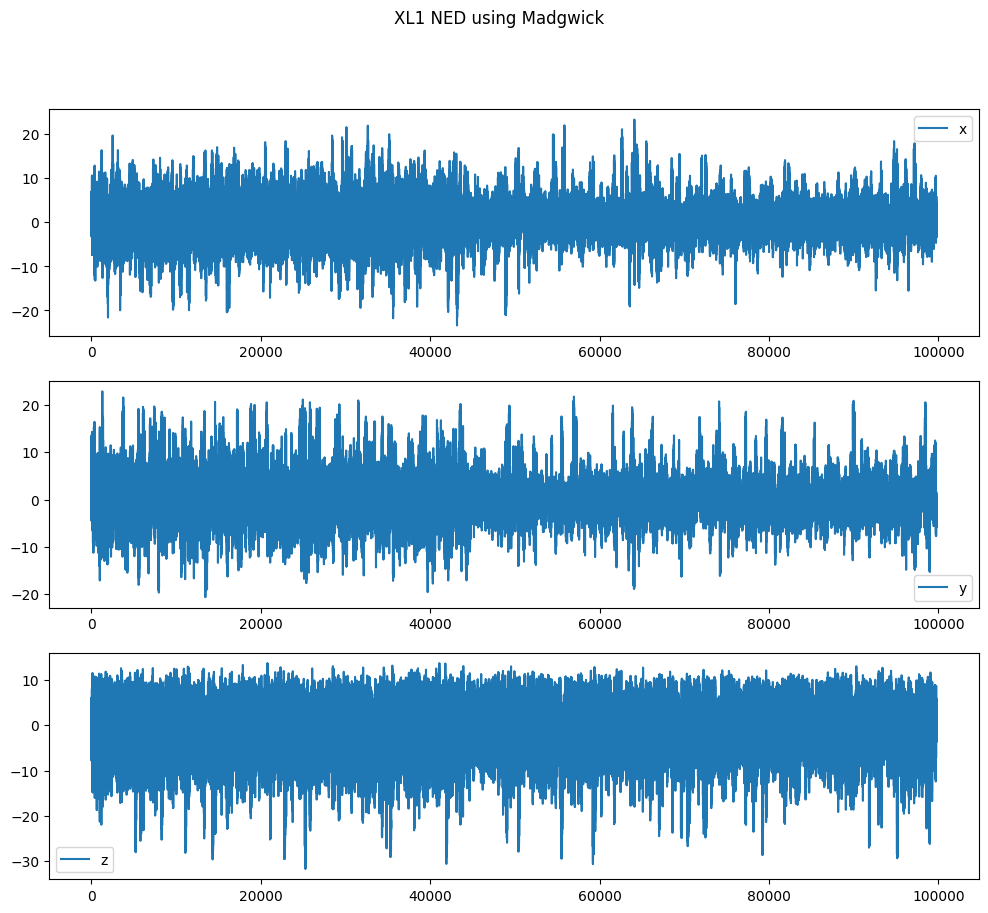

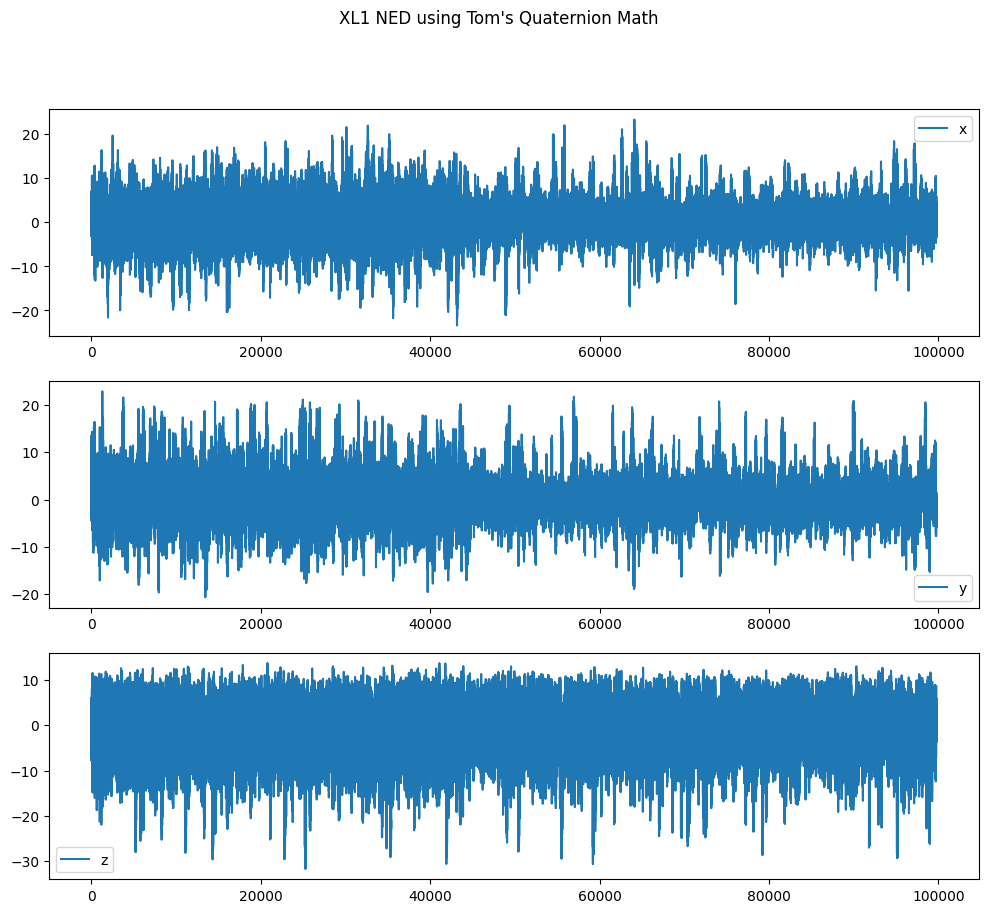

Velocity using Madgwick:


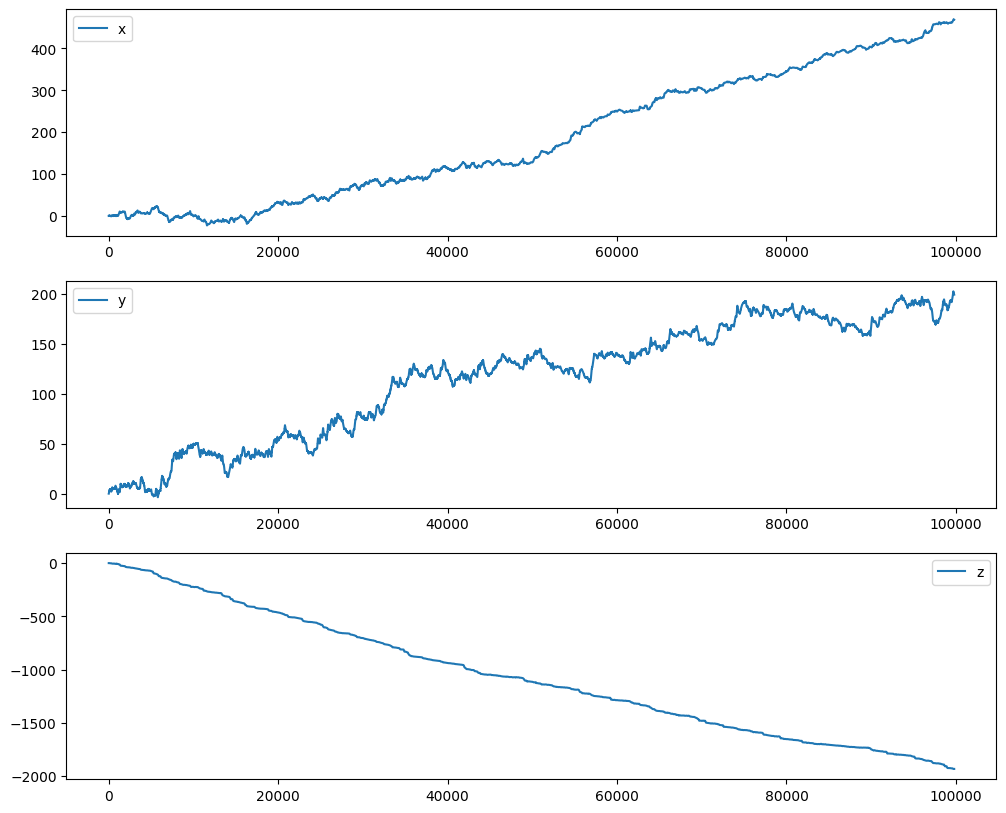

Velocity using Tom's Quaternion Math


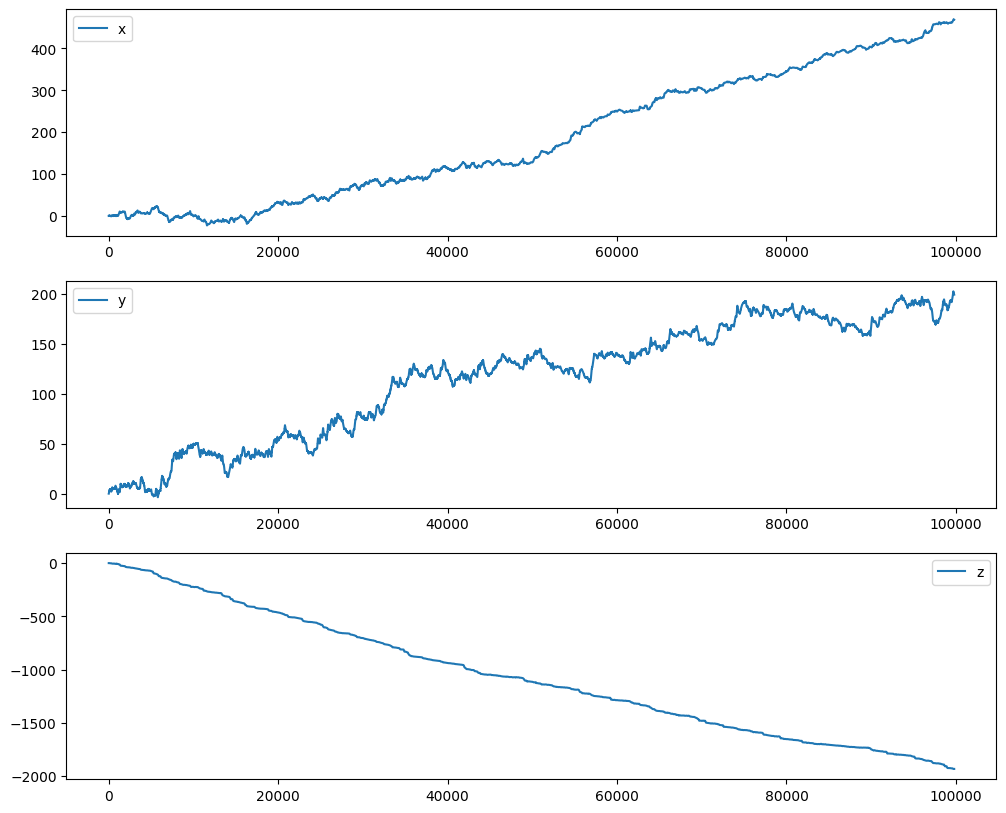

Calculating Errors:


In [16]:
# Comparing Madgwick and Quaternion Math

xl_ned_m = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100, madg = True))
print(np.array(xl_ned).shape)

xl_ned_q = np.array(imu_processing(xl_dat, mg_dat, gy_dat, interval_odr=100, madg = False))
print(np.array(xl_ned).shape)

xl_ned_q_test = np.round(xl_ned_q, decimals = 3).tolist()
xl_ned_m_test = np.round(xl_ned_m, decimals = 3).tolist()

assert xl_ned_q_test == xl_ned_m_test, "Fail"

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned_m[:,0], label='x')
axes[1].plot(xl_ned_m[:,1], label='y')
axes[2].plot(xl_ned_m[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle('XL1 NED using Madgwick')
plt.show()

fig, axes = plt.subplots(3, figsize = (12,10))
axes[0].plot(xl_ned_q[:,0], label='x')
axes[1].plot(xl_ned_q[:,1], label='y')
axes[2].plot(xl_ned_q[:,2], label='z')

for ax in axes: 
    ax.legend()
fig.suptitle("XL1 NED using Tom's Quaternion Math")
plt.show()


print("Velocity using Madgwick:")
imu_dead_reckoning(xl_ned_m, 1/100)

print("Velocity using Tom's Quaternion Math")
imu_dead_reckoning(xl_ned_q, 1/100)

print("Calculating Errors:")

(930064, 5)
(18427, 5)
(933740, 5)


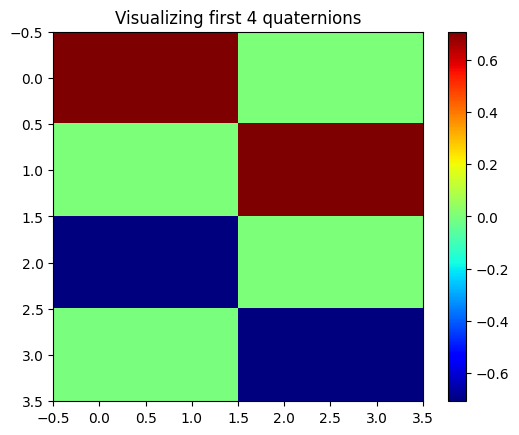

In [19]:
# Visualizing first 4 quaternions using raw data
# I repeated the Madgwick operation to generate a heatmap using the first four vectors.
# This result will be compared using the time aligned and processed imu data for comparison.

print(xl_dat.shape)
print(mg_dat.shape)
print(gy_dat.shape)
new_xl = xl_dat[:18427,:3]
new_gy = gy_dat[:18427,:3]

new_quaternions = Madgwick(acc = new_xl, mqt = mg_dat[:,:3], gyr=new_gy)
quart_array = []
for q,x in zip(new_quaternions.Q, new_xl):
        mag = np.linalg.norm(x)
        norm_vec = x / mag
        ned_vec = rotate_to_ned(q, norm_vec, madg = True)
        ned_vec = ned_vec*mag
        quart_array.append(q)

new_quart_array = np.array(quart_array)
new_quart_array = new_quart_array[:4,:]
plt.imshow(new_quart_array, cmap="jet")
plt.colorbar()
plt.title("Visualizing first 4 quaternions")
plt.show()


In [20]:
print(ned_vec)
print(ned_vec.shape)

[-7.33995451e+06  2.43923388e+01 -4.61781059e+07]
(3,)


Text(0.5, 1.0, 'Resampling 32 data points of the sin function')

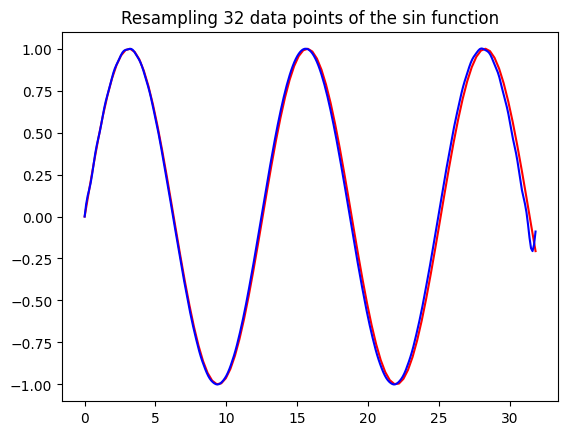

In [21]:
# Visualizing the effects of resampling

test_interval = 100
sample_x_vals = np.linspace(0, (100/np.pi), 100)
sample_y_vals = np.sin((sample_x_vals/2))

data_r = resample(sample_y_vals, test_interval*3)
sample_x_r_vals = np.linspace(0, (100/np.pi), 300)

plt.plot(sample_x_vals, sample_y_vals, 'r')
plt.plot(sample_x_r_vals, data_r, 'b')

plt.title("Resampling 32 data points of the sin function")


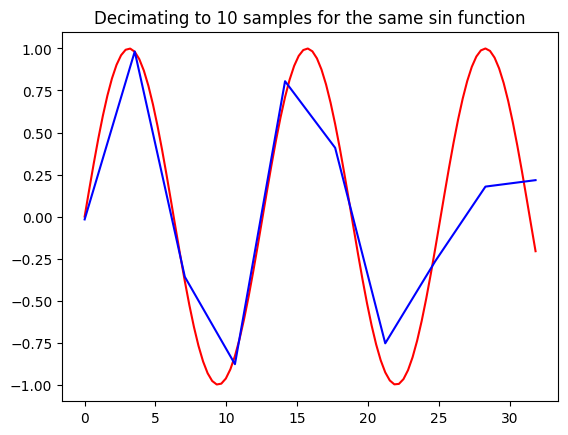

In [22]:
# Visualizing the effects of decimating

data_d = decimate(data_r, q=test_interval//3, axis=0)

plt.plot(sample_x_vals, sample_y_vals, 'r')
plt.plot(np.linspace(0,(100/np.pi),10), data_d, 'b')

plt.title("Decimating to 10 samples for the same sin function")
plt.show()

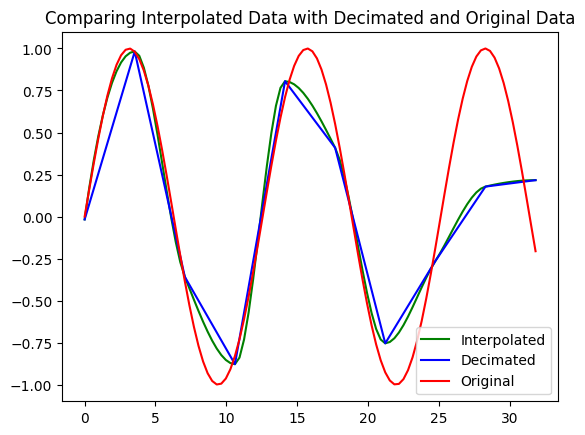

In [23]:
# Interpolating on the decimated sample data, i.e data_d
spline = PchipInterpolator(np.linspace(0,(100/np.pi),10), data_d)
interp_data = spline(np.linspace(0,(100/np.pi),100))

plt.plot(np.linspace(0,(100/np.pi),100), interp_data, 'g', label="Interpolated")
plt.plot(np.linspace(0,(100/np.pi),10), data_d, 'b', label="Decimated")
plt.plot(sample_x_vals, sample_y_vals, 'r', label="Original")

plt.title("Comparing Interpolated Data with Decimated and Original Data")
plt.legend()
plt.show()



In [24]:
# Storing the imu data inside a custom data class

import data

imu_data = data.Data("modified_xl1.csv")
print(imu_data)


 -------------------------------
modified_xl1.csv (930064x5)
Headers: 
  interval    timestamp    xl1.x    xl1.y    xl1.z  
Showing first 5/930064 rows.
0.0     46757786.0008     -0.39365234375     -0.60496875     1.1908125     
0.0     46757786.0018     0.27239453125     0.32833984375     0.9079453125     
0.0     46757786.0028     0.5186640625     0.7189375     1.0464765625     
0.0     46757786.0038     0.5548671875     0.10870703125     1.96628125     
0.0     46757786.0048     0.09496484375     0.002421875     0.63576953125     



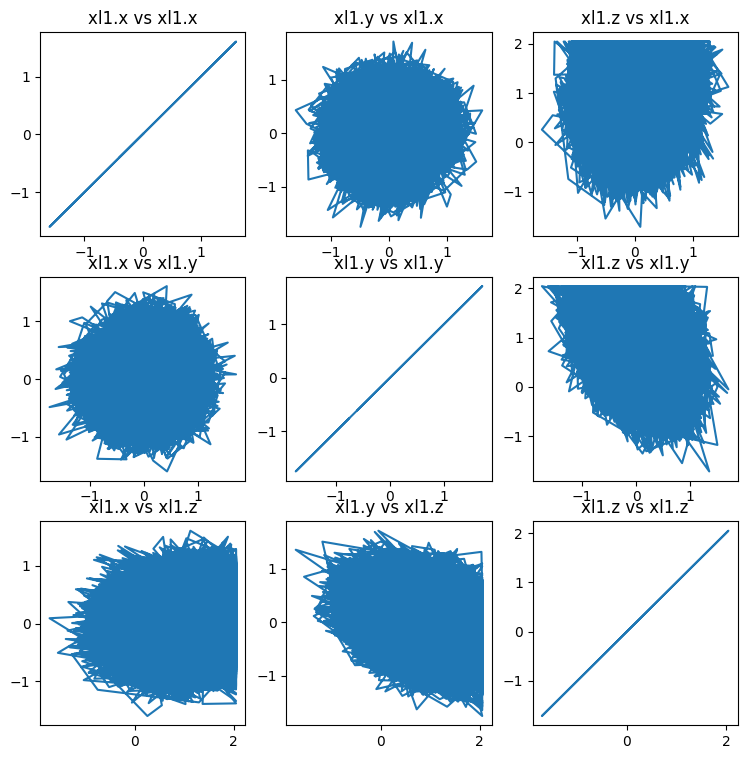

In [25]:
header_list = ["xl1.x", "xl1.y", "xl1.z"]
imu_copy = imu_data.select_data(headers = header_list, rows = list(np.arange(0, 200000, 1)))
fig, axes = plt.subplots(3,3)
fig.set_figheight(9)
fig.set_figwidth(9)

for i in range(3):
    for j in range(3):
        axes[i][j].plot(imu_copy[:,i], imu_copy[:,j])
        axes[i][j].set_title(header_list[j] + " vs " + header_list[i])
